# <font color=green> Credit Card Fraud Detection

### <font color=darkblue> Business Objective:</font>
#### To identify and predict fraudulent credit card transactions with the help of Machine learning models.

## <font color=brown>Stepwise Approach:</font>
### <font color=darkblue>Data Preparation: <br></font>
1. `EDA`: Data understanding, cleaning, univariate and bivariate analysis.
2. `Unnecessary columns` are `removed`.
3. `Stratified train test split` is performed to create train and test datasets.
4. `Skewness mitigation` in data is done using Power Transformer.
5. `Defined functions wherever necessary` to maintain `conciseness in coding.`

### <font color=darkblue>Model Building and Evaluation Approach:</font><br>
1. For this `large dataset`, `RandomizedSearchCV with StratifiedKFold cross-validator is used` to find the optimal hyperparameters along with the best estimator.<br><br>
2. `Imblearn pipelines are used`:
    - Pipelines assemble several steps that can be cross-validated together while setting different parameters.
    - `Advantange: Pipelines make sure that VALIDATION sets are NOT OVERSAMPLED within folds while upsampling as a part of cross-validation`.<br><br>
3. `Class imbalances are dealt (internally) within pipelines.`<br><br>
4. `Different models are built on raw imbalanced dataset as well as on balanced datasets. All models are built for all the 4 stages:`
    - (1) Imbalanced Dataset (oversampling: None)
    - Balanced Datasets (2) RandomOversampler (3) SMOTE (4) ADASYN <br><br>
5. `Logistic Regression, Decision Tree, Random Forest and XGBoost models are built` for all 4 stages.<br><br>
6. `SVM:` It is `computatationally intensive` and impractical on oversampled datasets. Hence, we `train SVM on imbalanced dataset using complete train data, and for balanced datasets on stratified-subset of train data. Models are further evaluated on actual test data.`<br><br>
7. `KNN:` KNN is a lazy learner, works well on small datasets, and is `impractical on large datasets`. Hence, `due to limited available computational resources, KNN models are built on stratified-subset of train data and evaluated on actual test data.` <br><br>
8. `Appropriate evaluation metrics` are used `to select the best model` from both the categories.


### <font color=purple>Install all the necessary packages

In [ ]:
## Install all the necessary packages to run the code (ignore if already installed)
'''
a. simple_colors ## For printing BOLD text
b. chardet: for checking file encoding
c. imblearn and/or imbalanced-learn: For over_sampling and for imblearn pipeline
d. update seaborn: for new features
e. scikit-learn: for model building and associated elements
f. xgboost: for xgboost

'''
!pip install numpy
!pip install pandas
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install simple_colors
!pip install chardet
!pip install xgboost
!pip install imblearn
!pip install imbalanced-learn
!pip install -U seaborn

### <font color=purple>Importing all the necessary libraries

In [ ]:
## Importing all the necessary libraries

## To suppress warnings
import warnings
warnings.filterwarnings("ignore")

import numpy as np
np.random.seed(0)   ## set random seed
import pandas as pd
import chardet
import os
import pickle
from collections import Counter

# For plots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# sklearn packages (for pre-processing, model-building, evaluators, cross-validators, etc.)
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, roc_auc_score, f1_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit

# Imblearn packages (for over_sampling and imblearn pipelines)
from imblearn import over_sampling
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.pipeline import Pipeline, make_pipeline  ## Using packages from imblearn.pipeline for making pipelines

## xgboost packages
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

## time and datetime
import datetime
import time

## for bold text
from simple_colors import *

## Pandas DataFrame display options
pd.set_option('display.max_columns', None)
pd.set_option("max_colwidth", None)
pd.set_option("display.max_rows", None)
pd.set_option('display.max_seq_items', None) #For printing a long-sequence

In [ ]:
##Defining a function to plot confusion matrix

def plot_confusion_matrix(cm):
    """
    This function prints and plots the confusion matrix.
    """
    classes=['Non-Fraudulent','Fraudulent']
    cmap=plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix', fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes, rotation=90)
    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label', fontsize= 10)
    plt.xlabel('Predicted label', fontsize=10)


def print_model_metrics(y_test,y_pred):
    print(" Model Stats Scores Summary : ")
    cp = confusion_matrix(y_test,y_pred)
    plt.figure(figsize=(5,5))
    plot_confusion_matrix(cp)
    plt.show()

In [ ]:
##Defining a function for coloring NaN and Non-NaN values (Useful for missing values treatment)
def color_style(value):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for value
    greater than 5% NaNs, and green for safer values
    and black for anything otherwise.
    """
    if value>0:
        color= 'red'
    elif value==0:
        color='green'
    else:
        color='black'
    return 'color: %s' % color

In [ ]:
## Defining a function for percentage of missing values dataframe: null_prcnt_df
def null_prcnt_df(input_data):
    df= input_data.copy()
    missing = pd.DataFrame(100*df.isnull().sum()/len(df.index))
    missing.rename(columns={0:'Null_Percentage'}, inplace=True)
    missing = pd.DataFrame(missing.Null_Percentage).sort_values(by='Null_Percentage',ascending=False).style.applymap(color_style)
    return missing

## <font color=green>Exploratory Data Analysis (EDA)

### <font color=Brown>Checking File Encoding

In [ ]:
##Confirming the encoding of the 'creditcard.csv' (dataset) file
file_path = os.path.join('creditcard.csv')
raw_data = open(file_path, 'rb').readline()

encoding = chardet.detect(raw_data)
print("File encoding details:\n",encoding)

File encoding details:
 {'encoding': 'ascii', 'confidence': 1.0, 'language': ''}


**Observation:** Since the coding is 'ASCII', we can now proceed with reading the dataset.

### <font color=Brown>Reading the dataset

In [ ]:
## Read the dataset: 'creditcard.csv'
df = pd.read_csv("creditcard.csv")
df.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10       V11       V12       V13       V14  \
0  0.098698  0.363787  0.090794 -0.551600 -0.617801 -0.991390 -0.311169   
1  0.085102 -0.255425 -0.166974  1.612727  1.065235  0.489095 -0.143772   
2  0.247676 -1.514654  0.207643  0.624501  0.066084  0.717293 -0.165946   
3  0.377436 -1.387024 -0.054952 -0.226487  0.178228  0.507757 -0.287924   
4 -0.270533  0.817739  0.753074 -0.822843  0.538196  1.345852 -1.119670   

        V15       V16       V17       V18       V19       V20       V21  \
0  1.468177 -0.470401  0.207971  0.025791  0.403993  0.251412 -0.018307   
1  0.635558  0.463917 -0.114805 -0.183361 -0.145783 -0.069083 -0.225775   
2  2.345865 -2.890083  1.109969 -0.121359 -2.261857  0.524980  0.247998   
3 -0.631418 -1.059647 -0.684093  1.965775 -1.232622 -0.208038 -0.108300   
4  0.175121 -0.451449 -0.237033 -0.038195  0.803487  0.408542 -0.009431   

        V22       V23       V24       V25       V26       V27       V28  \
0  0.277838 -0.110474  0.066928  0.128539 -0.189115  0.133558 -0.021053   
1 -0.638672  0.101288 -0.339846  0.167170  0.125895 -0.008983  0.014724   
2  0.771679  0.909412 -0.689281 -0.327642 -0.139097 -0.055353 -0.059752   
3  0.005274 -0.190321 -1.175575  0.647376 -0.221929  0.062723  0.061458   
4  0.798278 -0.137458  0.141267 -0.206010  0.502292  0.219422  0.215153   

   Amount  Class  
0  149.62      0  
1    2.69      0  
2  378.66      0  
3  123.50      0  
4   69.99      0

In [ ]:
df.tail()

Time         V1         V2        V3        V4        V5  \
284802  172786.0 -11.881118  10.071785 -9.834783 -2.066656 -5.364473   
284803  172787.0  -0.732789  -0.055080  2.035030 -0.738589  0.868229   
284804  172788.0   1.919565  -0.301254 -3.249640 -0.557828  2.630515   
284805  172788.0  -0.240440   0.530483  0.702510  0.689799 -0.377961   
284806  172792.0  -0.533413  -0.189733  0.703337 -0.506271 -0.012546   

              V6        V7        V8        V9       V10       V11       V12  \
284802 -2.606837 -4.918215  7.305334  1.914428  4.356170 -1.593105  2.711941   
284803  1.058415  0.024330  0.294869  0.584800 -0.975926 -0.150189  0.915802   
284804  3.031260 -0.296827  0.708417  0.432454 -0.484782  0.411614  0.063119   
284805  0.623708 -0.686180  0.679145  0.392087 -0.399126 -1.933849 -0.962886   
284806 -0.649617  1.577006 -0.414650  0.486180 -0.915427 -1.040458 -0.031513   

             V13       V14       V15       V16       V17       V18       V19  \
284802 -0.689256  4.626942 -0.924459  1.107641  1.991691  0.510632 -0.682920   
284803  1.214756 -0.675143  1.164931 -0.711757 -0.025693 -1.221179 -1.545556   
284804 -0.183699 -0.510602  1.329284  0.140716  0.313502  0.395652 -0.577252   
284805 -1.042082  0.449624  1.962563 -0.608577  0.509928  1.113981  2.897849   
284806 -0.188093 -0.084316  0.041333 -0.302620 -0.660377  0.167430 -0.256117   

             V20       V21       V22       V23       V24       V25       V26  \
284802  1.475829  0.213454  0.111864  1.014480 -0.509348  1.436807  0.250034   
284803  0.059616  0.214205  0.924384  0.012463 -1.016226 -0.606624 -0.395255   
284804  0.001396  0.232045  0.578229 -0.037501  0.640134  0.265745 -0.087371   
284805  0.127434  0.265245  0.800049 -0.163298  0.123205 -0.569159  0.546668   
284806  0.382948  0.261057  0.643078  0.376777  0.008797 -0.473649 -0.818267   

             V27       V28  Amount  Class  
284802  0.943651  0.823731    0.77      0  
284803  0.068472 -0.053527   24.79      0  
284804  0.004455 -0.026561   67.88      0  
284805  0.108821  0.104533   10.00      0  
284806 -0.002415  0.013649  217.00      0

### <font color=Brown>Data Understanding, Cleaning and Manipulation

In [ ]:
## Check number of records and feature columns (df.shape)
df.shape

(284807, 31)

In [ ]:
## Columns in the DataFrame
df= df.rename(columns=lambda x: x.strip())   ##Removing whitespaces in column names (if any)
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [ ]:
## Observing different feature types present in the data (dataframe summary)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

**Observations:**<br>(i) The `features (V1, V2, V3, up to V28)` are the `principal components` *(numerical input components)* obtained using `PCA`.<br>
(ii) The `feature 'Time'` *contains the seconds* elapsed between the first transaction in the data set and the subsequent transactions.<br>
(iii) The `feature 'Amount'` is the *transaction amount*.<br>
(iv) The `feature 'Class'` represents *class labelling*. (0: Normal Transactions, 1: Fraud Transactions)<br>

In [ ]:
# Statistics summary
df.describe()

Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.487313e-15 -5.556467e-16  1.213481e-16 -2.406331e-15   
std    1.380247e+00  1.332271e+00  1.237094e+00  1.194353e+00  1.098632e+00   
min   -1.137433e+02 -2.616051e+01 -4.355724e+01 -7.321672e+01 -1.343407e+01   
25%   -6.915971e-01 -7.682956e-01 -5.540759e-01 -2.086297e-01 -6.430976e-01   
50%   -5.433583e-02 -2.741871e-01  4.010308e-02  2.235804e-02 -5.142873e-02   
75%    6.119264e-01  3.985649e-01  5.704361e-01  3.273459e-01  5.971390e-01   
max    3.480167e+01  7.330163e+01  1.205895e+02  2.000721e+01  1.559499e+01   

                V10           V11           V12           V13           V14  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   2.239053e-15  1.673327e-15 -1.247012e-15  8.190001e-16  1.207294e-15   
std    1.088850e+00  1.020713e+00  9.992014e-01  9.952742e-01  9.585956e-01   
min   -2.458826e+01 -4.797473e+00 -1.868371e+01 -5.791881e+00 -1.921433e+01   
25%   -5.354257e-01 -7.624942e-01 -4.055715e-01 -6.485393e-01 -4.255740e-01   
50%   -9.291738e-02 -3.275735e-02  1.400326e-01 -1.356806e-02  5.060132e-02   
75%    4.539234e-01  7.395934e-01  6.182380e-01  6.625050e-01  4.931498e-01   
max    2.374514e+01  1.201891e+01  7.848392e+00  7.126883e+00  1.052677e+01   

                V15           V16           V17           V18           V19  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   4.887456e-15  1.437716e-15 -3.772171e-16  9.564149e-16  1.039917e-15   
std    9.153160e-01  8.762529e-01  8.493371e-01  8.381762e-01  8.140405e-01   
min   -4.498945e+00 -1.412985e+01 -2.516280e+01 -9.498746e+00 -7.213527e+00   
25%   -5.828843e-01 -4.680368e-01 -4.837483e-01 -4.988498e-01 -4.562989e-01   
50%    4.807155e-02  6.641332e-02 -6.567575e-02 -3.636312e-03  3.734823e-03   
75%    6.488208e-01  5.232963e-01  3.996750e-01  5.008067e-01  4.589494e-01   
max    8.877742e+00  1.731511e+01  9.253526e+00  5.041069e+00  5.591971e+00   

                V20           V21           V22           V23           V24  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   6.406204e-16  1.654067e-16 -3.568593e-16  2.578648e-16  4.473266e-15   
std    7.709250e-01  7.345240e-01  7.257016e-01  6.244603e-01  6.056471e-01   
min   -5.449772e+01 -3.483038e+01 -1.093314e+01 -4.480774e+01 -2.836627e+00   
25%   -2.117214e-01 -2.283949e-01 -5.423504e-01 -1.618463e-01 -3.545861e-01   
50%   -6.248109e-02 -2.945017e-02  6.781943e-03 -1.119293e-02  4.097606e-02   
75%    1.330408e-01  1.863772e-01  5.285536e-01  1.476421e-01  4.395266e-01   
max    3.942090e+01  2.720284e+01  1.050309e+01  2.252841e+01  4.584549e+00   

                V25           V26           V27           V28         Amount  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  284807.000000   
mean   5.340915e-16  1.683437e-15 -3.660091e-16 -1.227390e-16      88.349619   
std    5.212781e-01  4.822270e-01  4.036325e-01  3.300833e-01     250.120109   
min   -1.029540e+01 -2.604551e+00 -2.256568e+01 -1.543008e+01       0.000000   
25%   -3.171451e-01 -3.269839e-01 -7.083953e-02

In [ ]:
## Checking percentage of missing values in the dataset
null_prcnt_df(df)             ##Using null_prcnt_df function

**Observation:** No missing values found in the feature columns and output class.

Here we will observe the distribution of our classes.

In [ ]:
## Observing distribution of classes (0: Normal Transactions, 1: Fraud Transactions)

classes=df['Class'].value_counts()
normal_share=classes[0]/df['Class'].count()*100
fraud_share=classes[1]/df['Class'].count()*100

pattern_line= "*"*80
print(f"{pattern_line}\n{pattern_line}\n"+ \
      black("Distribution of Classes: (0: Normal Transactions, 1: Fraud Transactions)\n",'bold')+ \
      f"{classes}\n\n{pattern_line}")

print(black(f"Percentage of Normal Share i.e. Non-Fraudulent Transactions(%):\n",'bold')+ \
      f"{round(normal_share,4)} %"+ f"\n\n{pattern_line}")

print(black(f"Percentage of Fraud Share i.e. Fraudulent Transactions(%):\n",'bold')+ \
      f"{round(fraud_share,4)} %"+ f"\n\n{pattern_line}")

********************************************************************************
********************************************************************************
Distribution of Classes: (0: Normal Transactions, 1: Fraud Transactions)
0    284315
1       492
Name: Class, dtype: int64

********************************************************************************
Percentage of Normal Share i.e. Non-Fraudulent Transactions(%):
99.8273 %

********************************************************************************
Percentage of Fraud Share i.e. Fraudulent Transactions(%):
0.1727 %

********************************************************************************


### <font color=purple>Univariate and Bivariate Analysis

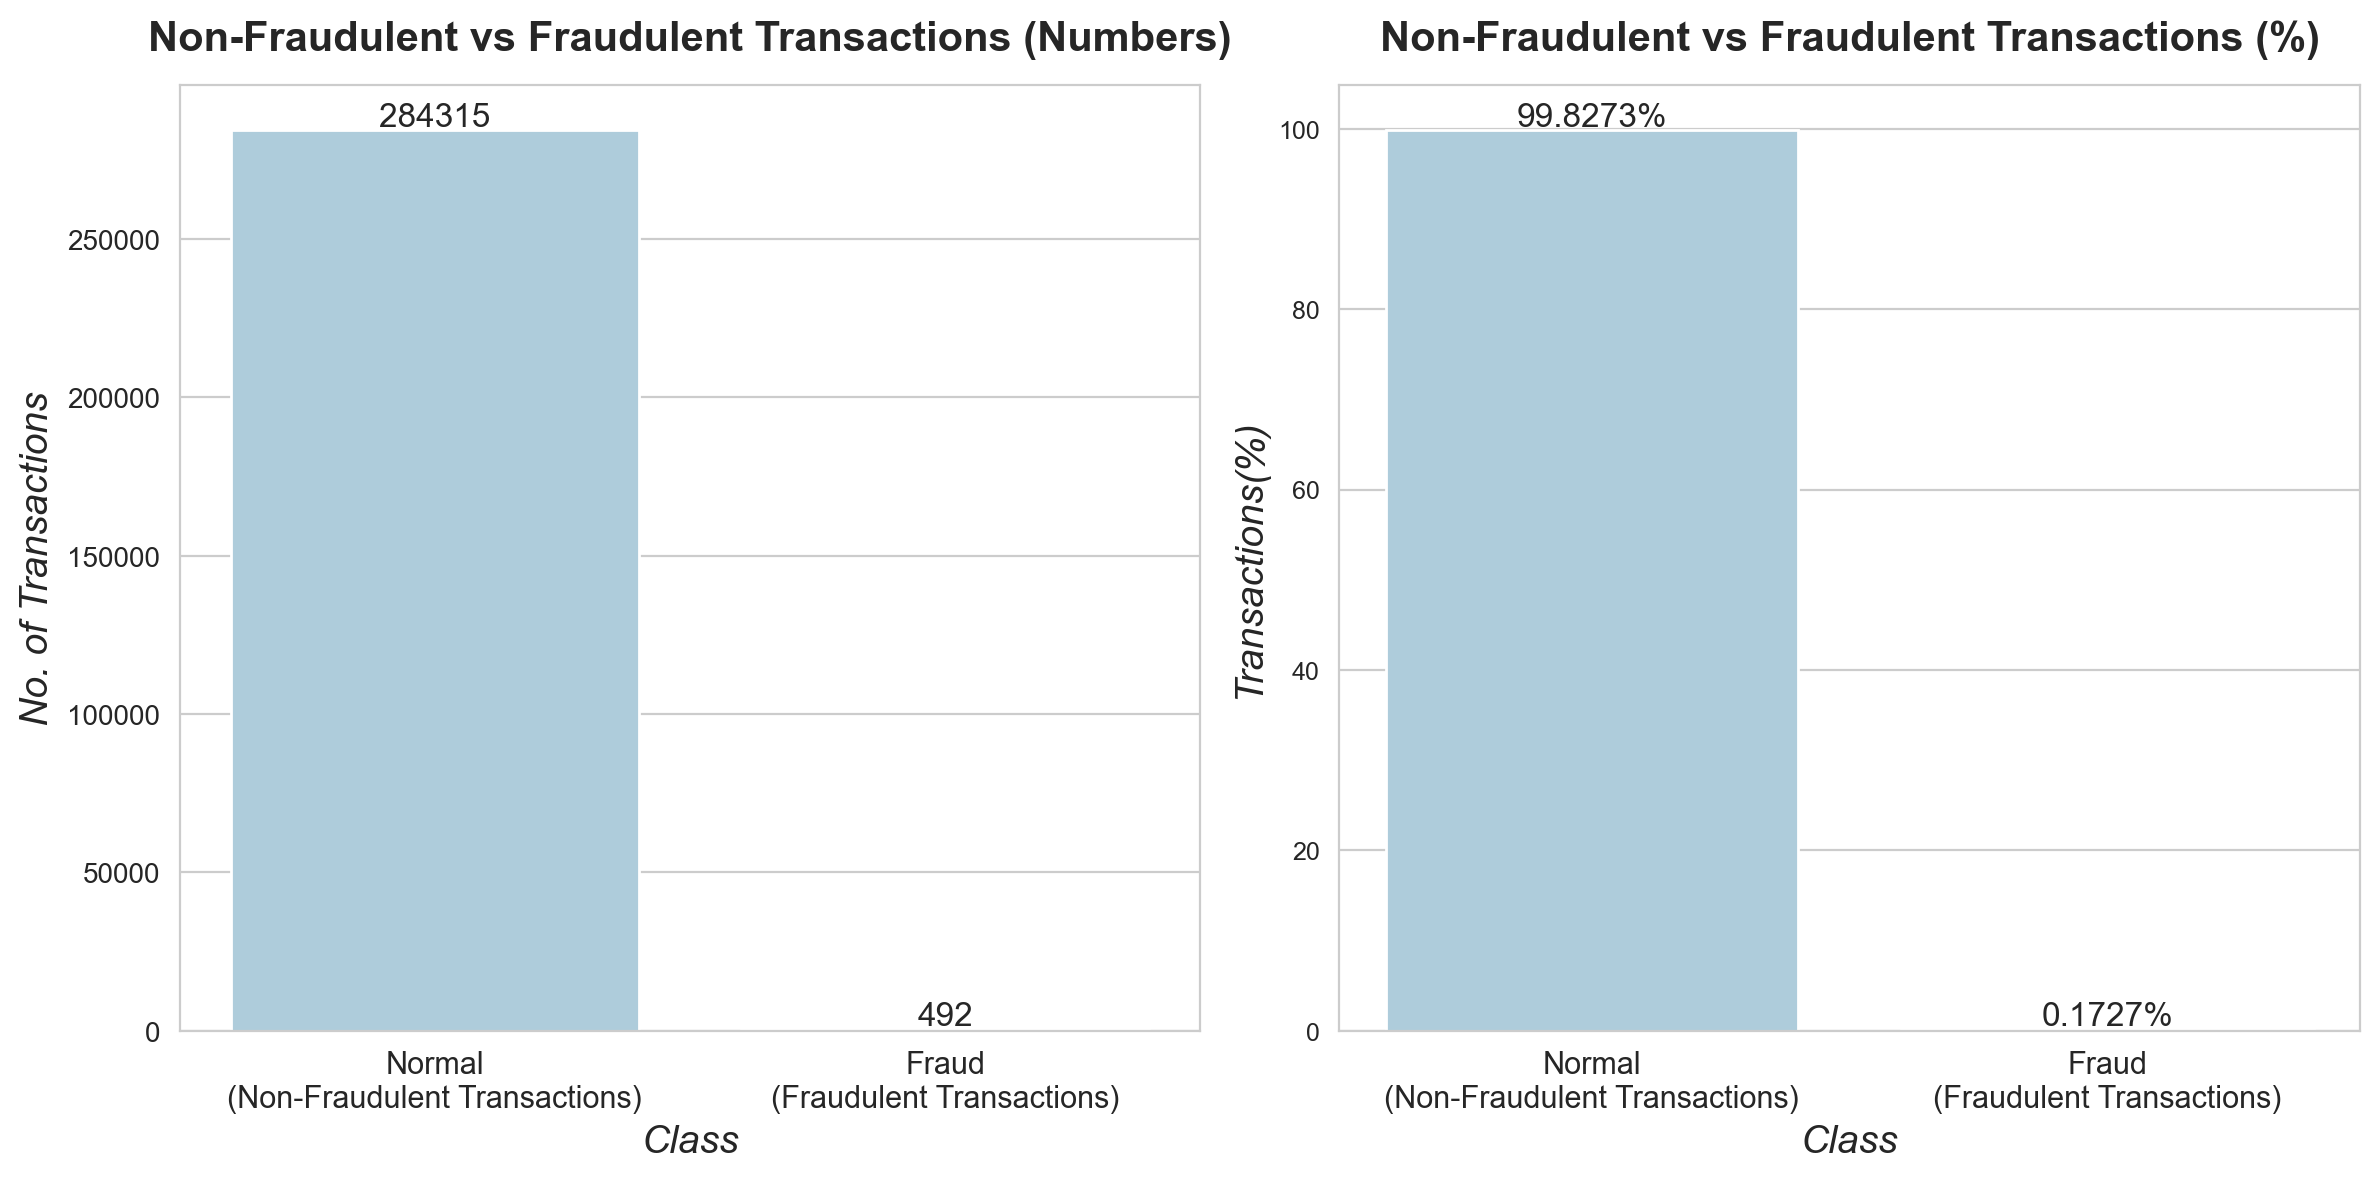

In [ ]:
# Create a bar plot for the number and percentage of non-fraudulent transcations vs fraudulent transactions


## Creating a dataframe containing number and percentage of classes
class_data= [["Normal (Non-Fraudulent)", classes[0], normal_share],\
             ["Fraud (Fraudulent)", classes[1], fraud_share]]
df_class= pd.DataFrame(class_data, columns=["Class", "num_transactions", "prcnt_transactions"])


plt.figure(figsize=(12,6), dpi=200)
sns.set_style("whitegrid")


##Subplot_121 (Barplot for Number of non-fraudulent transactions vs fraudulent transactions)
plt.subplot(1,2,1)
ax_1= sns.barplot(data = df_class,x= "Class", y="num_transactions", palette=("Paired"))
ax_1.set_xticklabels(labels=['Normal\n(Non-Fraudulent Transactions)','Fraud\n(Fraudulent Transactions)'], fontsize=11)
plt.title("Non-Fraudulent vs Fraudulent Transactions (Numbers)", fontsize=15, fontweight='bold', y=1.02)
plt.ylabel("No. of Transactions", fontsize=14, fontstyle='italic')
plt.xlabel("Class", fontsize=14, fontstyle='italic')
plt.yticks(fontsize=10)

for i in ax_1.patches:
    ax_1.annotate("{0:.0f}".format(i.get_height()), (i.get_x() + i.get_width() / 2.\
                                                 , i.get_height()), ha = 'center'\
        , va = 'top' , xytext = (0, 10), textcoords = 'offset points',rotation=0, fontsize=12)


##Subplot_122 (Barplot for Percentage of non-fraudulent transactions vs fraudulent transactions)
plt.subplot(1,2,2)
ax_2= sns.barplot(data = df_class,x= "Class", y="prcnt_transactions", palette=("Paired"))
ax_2.set_xticklabels(labels=['Normal\n(Non-Fraudulent Transactions)','Fraud\n(Fraudulent Transactions)'], fontsize=11)
plt.title("Non-Fraudulent vs Fraudulent Transactions (%)", fontsize=15, fontweight='bold', y=1.02)
plt.ylabel("Transactions(%)", fontsize=14, fontstyle='italic')
plt.xlabel("Class", fontsize=14, fontstyle='italic')
plt.yticks(fontsize=9)

for j in ax_2.patches:
    ax_2.annotate("{0:.4f}".format(j.get_height())+"%", (j.get_x() + j.get_width() / 2.\
                                                 , j.get_height()), ha = 'center'\
        , va = 'top' , xytext = (0, 10), textcoords = 'offset points',rotation=0, fontsize=12)

plt.tight_layout()
plt.autoscale()
plt.show()

**Observation:**<br>Out of a `total of 2,84,807 transactions`, `492 were fraudulent`. This data set is highly unbalanced, with the positive class (`frauds`) accounting for `approximately 0.172%` of the total transactions.

In [ ]:
## Let's define a function for scatter plot
def scatter_plot(my_figsize, title, my_data, x, y, x_unit):
    fig = plt.figure(figsize= my_figsize)
    cmap = sns.color_palette('Set1')

    df= my_data.copy()
    plt.figure(figsize=(10,5), dpi=100)
    sns.set_style("whitegrid")
    sns.scatterplot(x= x, y= y, data=df)
    plt.title((f"{title}"), fontweight='bold', fontsize=15, y=1.02)
    plt.xlabel(x+f" {x_unit}", fontsize=13, fontstyle='italic')
    plt.ylabel(y, fontsize=13, fontstyle='italic')

    plt.grid(True)
    plt.autoscale()
    plt.tight_layout()
    plt.show()

<Figure size 864x1008 with 0 Axes>

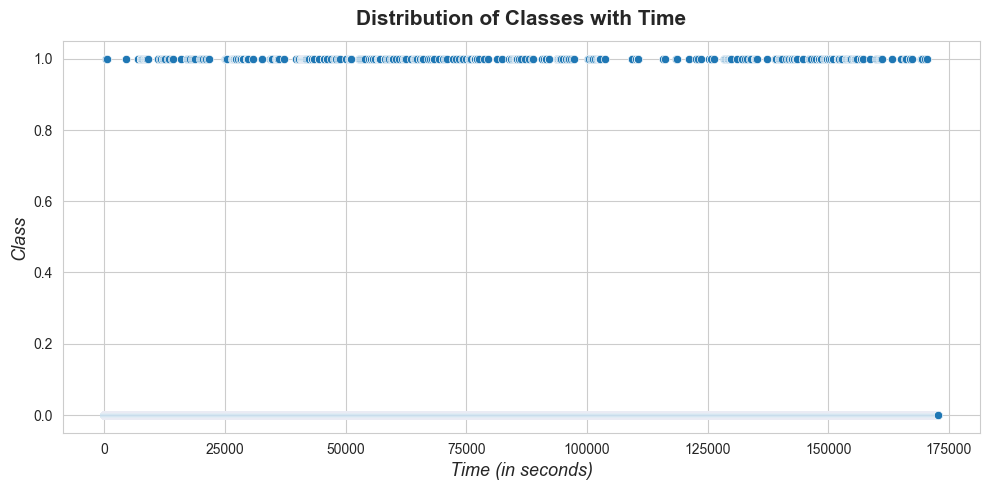

In [ ]:
# Create a scatter plot to observe the distribution of classes with Time
scatter_plot(my_figsize=(12,14), title= "Distribution of Classes with Time", my_data=df,\
             x="Time", x_unit="(in seconds)", y="Class")

**Observation:** <br>Clearly we see the distinction in the number of fraud cases (Class Label:1) with respect to normal cases (Class Label: 0) where the latter being extremely high in number in comparison to the former class.

**Note:**<br> The dataset contains transactions made by credit cards in September 2013 by european cardholders, it would be safe to assume the default Currency for 'Amount' feature as **EURO (EUR)** i.e. **€** .

<Figure size 864x1008 with 0 Axes>

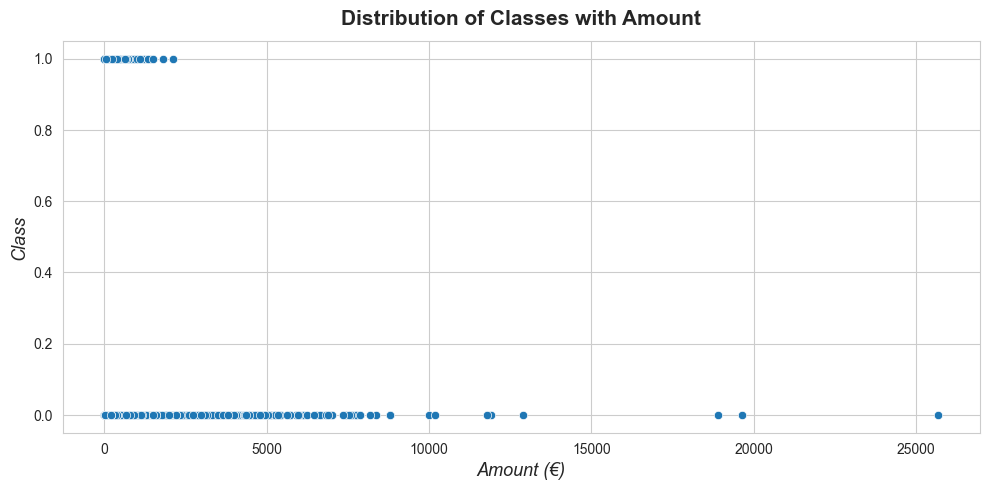

In [ ]:
# Create a scatter plot to observe the distribution of classes with Amount
scatter_plot(my_figsize=(12,14), title= "Distribution of Classes with Amount", my_data=df,\
             x="Amount", x_unit="(€)", y="Class")

(Observation mentioned after analysis of statistical summary and visualization of `'Amount'` feature.)

In [ ]:
## Let's find the maximum transaction amount in Fraud Cases (Class Label: 1).
max_trnsctn_fraud= df[df.Class==1]["Amount"].max()
print(f"Maximum fraud transaction amount: €{max_trnsctn_fraud}")

Maximum fraud transaction amount: €2125.87


In [ ]:
## Statistical summary of 'Amount' feature for different classes
summary_class_0= df[df.Class==0].Amount.describe([0.1,0.25,0.5,0.75,0.9,0.95,0.99,1])
print(black(f"Statistical summary of 'Amount' feature (Normal Transactions):\n\n",'bold'),summary_class_0)

summary_class_1= df[df.Class==1].Amount.describe([0.1,0.25,0.5,0.75,0.9,0.95,0.99,1])
print(black(f"\nStatistical summary of 'Amount' feature (Fraud Transactions):\n\n",'bold'),summary_class_1)

Statistical summary of 'Amount' feature (Normal Transactions):

 count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
10%           1.000000
25%           5.650000
50%          22.000000
75%          77.050000
90%         202.724000
95%         364.409000
99%        1016.966400
100%      25691.160000
max       25691.160000
Name: Amount, dtype: float64

Statistical summary of 'Amount' feature (Fraud Transactions):

 count     492.000000
mean      122.211321
std       256.683288
min         0.000000
10%         0.760000
25%         1.000000
50%         9.250000
75%       105.890000
90%       346.746000
95%       640.905000
99%      1357.427900
100%     2125.870000
max      2125.870000
Name: Amount, dtype: float64


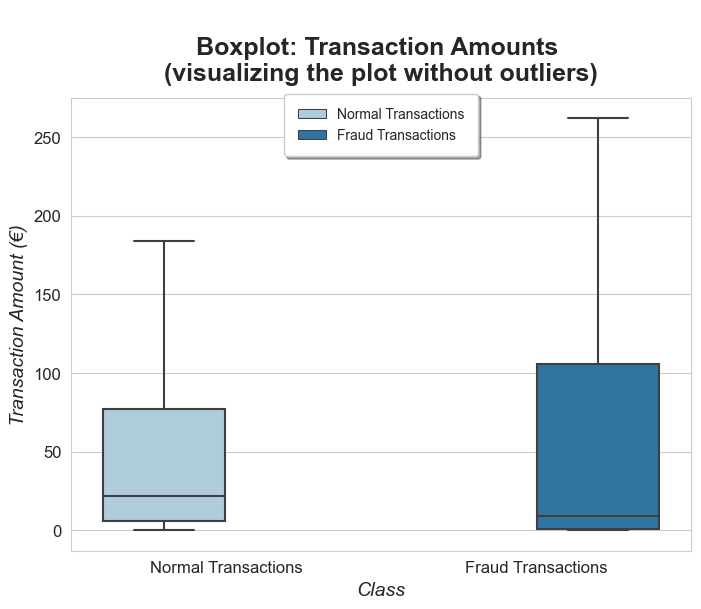

In [ ]:
## Visualising the statistics of transaction amounts
plt.figure(figsize=(8,6), dpi=100)
sns.set_style("whitegrid")

 ## Note: Set (showflier=False) to eliminate the effect of outliers in the transaction amounts
ax_31= sns.boxplot(data=df, y="Amount", x="Class", hue="Class",showfliers=False, palette=("Paired"))
ax_31.set_xticklabels(labels=['Normal Transactions','Fraud Transactions'], fontsize=12)
plt.title(f"\nBoxplot: Transaction Amounts \n(visualizing the plot without outliers)", fontsize=18, fontweight='bold', y=1.02)
plt.ylabel("Transaction Amount (€)", fontsize=14, fontstyle='italic')
plt.xlabel("Class", fontsize=14, fontstyle='italic')
plt.yticks(fontsize=12)

#legend
L31= ax_31.legend(loc='center', bbox_to_anchor=(0.5, 0.94), fancybox=True, framealpha=1, shadow=True, borderpad=1)
L31.get_texts()[0].set_text('Normal Transactions')
L31.get_texts()[1].set_text('Fraud Transactions')

plt.show()

**Note:**<br>
In the above boxplot, we have eliminated the effect of outliers in the transaction amounts. This helps us in better understanding the range of most of the values.

**Observations:**
<br>(i) From the plot of distribution of classes with respect to transaction amount, it is quite evident that the `transaction amounts for fraud cases were lesser than approximately €2200`.
<br>(ii) Precisely, `average fraud transaction amount is approximately €122` (from statistical summary) and `maximum fraud transaction amount is €2125.87`.
<br>(iii) `Normal transactions have a wide-range of amounts with certain outliers` (as seen from the plot of Distribution of Class with Amount).

**Analyzing the `Time` variable before we come to any conclusion.**

In [ ]:
df.Time.head()

0    0.0
1    0.0
2    1.0
3    1.0
4    2.0
Name: Time, dtype: float64

In [ ]:
df.Time.tail()

284802    172786.0
284803    172787.0
284804    172788.0
284805    172788.0
284806    172792.0
Name: Time, dtype: float64

In [ ]:
## Using pandas 'to_timedelta' to convert pandas Series from a recognized timedelta format / value into a Timedelta type
Time_Delta= pd.to_timedelta(df.Time, unit='s')
Time_Delta.head()

0   0 days 00:00:00
1   0 days 00:00:00
2   0 days 00:00:01
3   0 days 00:00:01
4   0 days 00:00:02
Name: Time, dtype: timedelta64[ns]

In [ ]:
Time_Delta.tail()

284802   1 days 23:59:46
284803   1 days 23:59:47
284804   1 days 23:59:48
284805   1 days 23:59:48
284806   1 days 23:59:52
Name: Time, dtype: timedelta64[ns]

**Deriving new 'Time' features for analysis**

In [ ]:
## Extracting the number of days, hours and minutes from 'Time_Delta' variable.
df['Time_Days']= (Time_Delta.dt.components.days).astype(int) ## Number of days
df['Time_Hours']= (Time_Delta.dt.components.hours).astype(int) ## Number of hours
df['Time_Minutes']= (Time_Delta.dt.components.minutes).astype(int) ## Number of minutes

df[['Time', 'Time_Days', 'Time_Hours', 'Time_Minutes']].tail()  ##Checking the tail for verifying successful operations

Time  Time_Days  Time_Hours  Time_Minutes
284802  172786.0          1          23            59
284803  172787.0          1          23            59
284804  172788.0          1          23            59
284805  172788.0          1          23            59
284806  172792.0          1          23            59

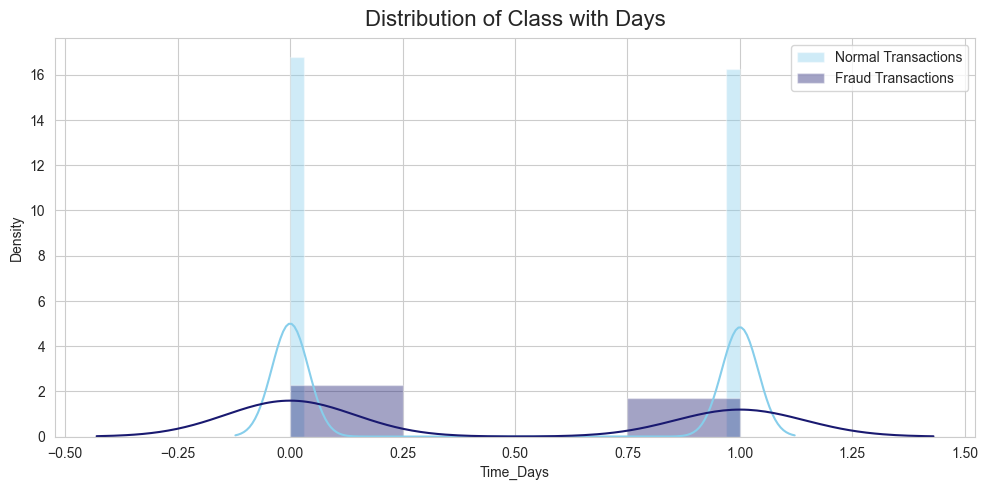

In [ ]:
## Analyzing distribution of classes with days

plt.figure(figsize=(10,5), dpi=100)

sns.distplot(df[df.Class == 0]["Time_Days"], label= "Normal Transactions", color='skyblue')
sns.distplot(df[df.Class == 1]["Time_Days"], label= "Fraud Transactions", color= 'midnightblue')

plt.title('Distribution of Class with Days', fontsize=16, y=1.01)
plt.legend()
plt.tight_layout()
plt.show()

**Observation:** <br>(i) It is `obvious that the density of non-fraudulent (normal) transactions is very high` in comparison to the fradulent transactions. <br>(ii) `Time_Days` feature `doesn't offer much insights as we only have the records for day 0 and day 1` respectively.

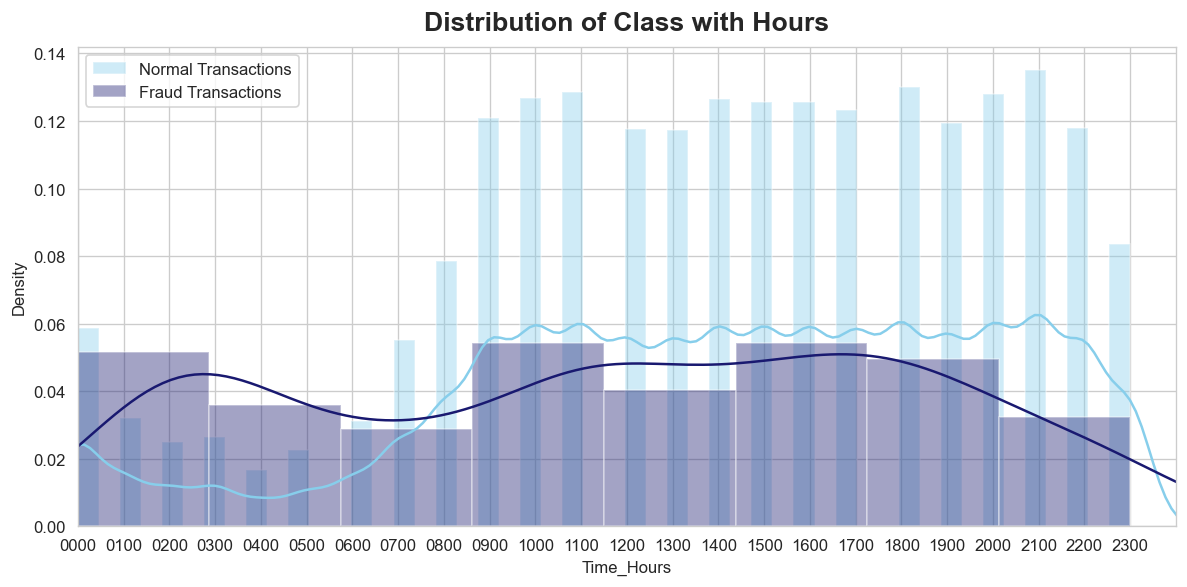

In [ ]:
## Analyzing distribution of classes with hours

fig= plt.figure(figsize=(10,5), dpi=120)
ax_4= fig.add_subplot(1,1,1)
sns.set_style("whitegrid")

ax_4= sns.distplot(df[df.Class == 0]["Time_Hours"], label= "Normal Transactions", color='skyblue')  # Distplot for normal transactions
ax_4= sns.distplot(df[df.Class == 1]["Time_Hours"], label= "Fraud Transactions", color= 'midnightblue')  #Distplot for fraud transactions

ax_4.set_title('Distribution of Class with Hours', fontsize=16, fontweight='bold', pad=10)
plt.xlim(0,24)                          ## Limitng the x-axis to number of hours in a day
ax_4.set_xticks(np.arange(0,24))

## List Labels
list_a= ['0'+str(i) for i in list(np.arange(0,10))]
list_b= [str(i) for i in list(np.arange(10,24))]
list_a.extend(list_b)
list_hours= [str(j)+"00" for j in list_a]
ax_4.set_xticklabels(list_hours)

plt.legend()
plt.tight_layout()
plt.show()

(Observations are mentioned after checking the number of frauds at different hours.)

In [ ]:
## Checking the hour at which most frauds occur
num_fraud_hrs= df[df.Class==1]['Time_Hours'].value_counts()
num_fraud_hrs

2     57
11    53
18    33
17    29
15    26
4     23
7     23
14    23
16    22
23    21
19    19
20    18
13    17
12    17
3     17
9     16
21    16
5     11
1     10
8      9
6      9
22     9
10     8
0      6
Name: Time_Hours, dtype: int64

In [ ]:
## Check total number of hours (must round to 24)
len(num_fraud_hrs)

24

**Observations:**<br>(i) `No distinct fixed pattern (w.r.t. fraud transactions) can be seen from the hours.`<br>(ii) From the distribution plot of normal transactions we can infer that `most number of normal transactions took place from 0800 hours till midnight (0000 hours)`. <br>
(iii) `Normal transactions are less in number during night-time` (from midnight (i.e. 00 hours) till 0800 hours).<br>
(iv) `Most number of Fraud Transactions took place at 0200 (no. of txns= 57), 1100 (no. of txns= 53) and 1800 (no. of txns= 33) hours respectively.` `No Fraud Transactions` occurred early morning `at 0600 hours`.<br>


As this is `not a time-series problem` and `no further insights` can be `derived from the 'Time' feature and associated derived time features`, we can `drop all the time variables-> "Time","Time_Days", "Time_Hours" and "Time_Minutes" feature columns`.

In [ ]:
# Drop unnecessary columns
drop_columns= ["Time","Time_Days","Time_Hours", "Time_Minutes"]  # (all time variables - original and derived ones)
df.drop(drop_columns, axis=1, inplace= True)
df.head()

V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10       V11       V12       V13       V14  \
0  0.098698  0.363787  0.090794 -0.551600 -0.617801 -0.991390 -0.311169   
1  0.085102 -0.255425 -0.166974  1.612727  1.065235  0.489095 -0.143772   
2  0.247676 -1.514654  0.207643  0.624501  0.066084  0.717293 -0.165946   
3  0.377436 -1.387024 -0.054952 -0.226487  0.178228  0.507757 -0.287924   
4 -0.270533  0.817739  0.753074 -0.822843  0.538196  1.345852 -1.119670   

        V15       V16       V17       V18       V19       V20       V21  \
0  1.468177 -0.470401  0.207971  0.025791  0.403993  0.251412 -0.018307   
1  0.635558  0.463917 -0.114805 -0.183361 -0.145783 -0.069083 -0.225775   
2  2.345865 -2.890083  1.109969 -0.121359 -2.261857  0.524980  0.247998   
3 -0.631418 -1.059647 -0.684093  1.965775 -1.232622 -0.208038 -0.108300   
4  0.175121 -0.451449 -0.237033 -0.038195  0.803487  0.408542 -0.009431   

        V22       V23       V24       V25       V26       V27       V28  \
0  0.277838 -0.110474  0.066928  0.128539 -0.189115  0.133558 -0.021053   
1 -0.638672  0.101288 -0.339846  0.167170  0.125895 -0.008983  0.014724   
2  0.771679  0.909412 -0.689281 -0.327642 -0.139097 -0.055353 -0.059752   
3  0.005274 -0.190321 -1.175575  0.647376 -0.221929  0.062723  0.061458   
4  0.798278 -0.137458  0.141267 -0.206010  0.502292  0.219422  0.215153   

   Amount  Class  
0  149.62      0  
1    2.69      0  
2  378.66      0  
3  123.50      0  
4   69.99      0

### <font color=purple> Correlation Analysis

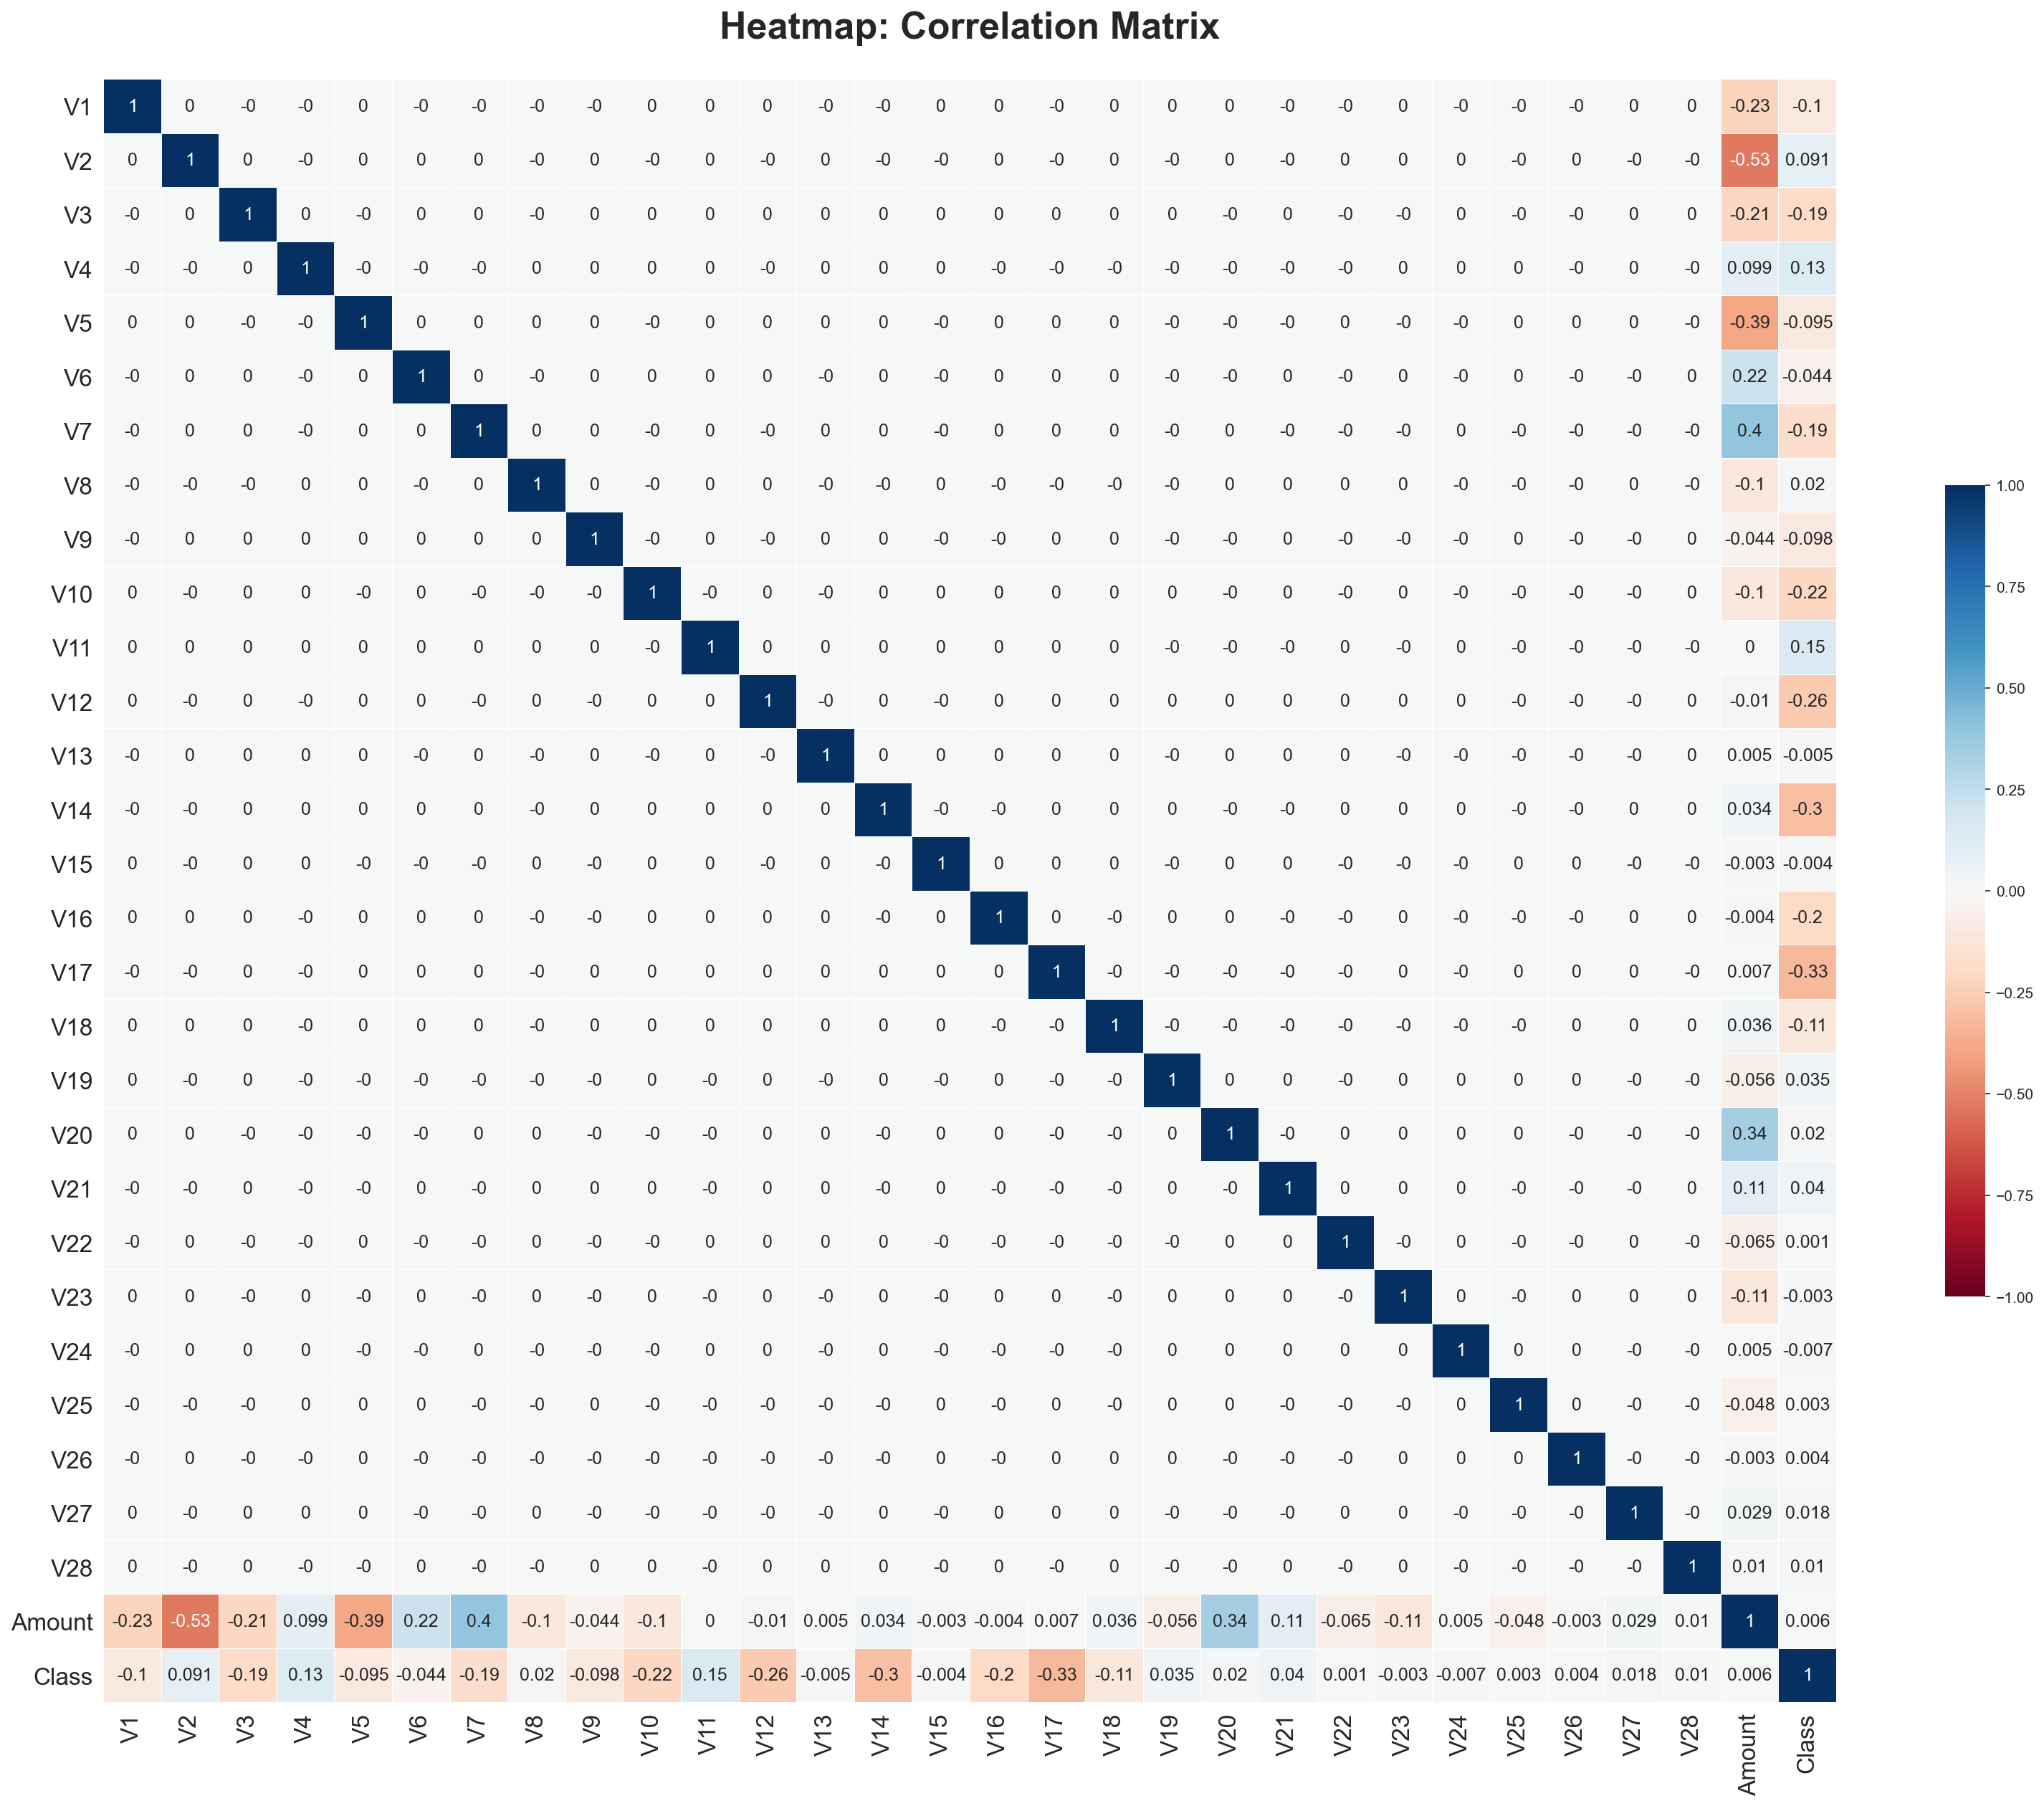

In [ ]:
##Let's check the correlation between all the feature variables to see if there is pattern between variables

#Plotting a heatmap to understand the correlation between the independent variables
corr_matrix = df.corr()
corr_matrix_round= round(corr_matrix, 3)
f, ax_corr = plt.subplots(figsize=(26,20), dpi=150)
ax_corr = sns.heatmap(corr_matrix_round,annot=True,cmap="RdBu", cbar_kws={"shrink": .5}, vmin= -1, vmax=1, center=0,\
             linewidths=0.01, annot_kws={"size":12})
plt.xticks(fontsize=16, rotation=90)
plt.yticks(fontsize=16, rotation=0)
plt.title("Heatmap: Correlation Matrix", y=1.02, fontsize=25, fontweight='bold')
plt.show()

**Observations:**<br>
(i) `PCA components (V1, V2 upto V28) clearly don't show any sign of multi-collinearity with each other`.<br>
(ii) `Some degree of correlation` can be seen `between PCA Components and the 'Amount' feature`.

In [ ]:
## Analyzing Top 10 correlated PCA components with 'Class'
corr_matrix_class_only= pd.DataFrame(corr_matrix['Class'])
corr_matrix_class_only["absolute_corr_val"]= corr_matrix_class_only.apply(lambda x: abs(x))

## Sorting in descending order (of absolute values of correlation coefficients)
corr_matrix_top10_class_only= corr_matrix_class_only.sort_values(by="absolute_corr_val", ascending=False)[1:11]
print(black(f"Top 10 feature variables related with Class:\n {list(corr_matrix_top10_class_only.index)}",'bold') );print()

## Top 10 correlated variables with class (except Class variable)
top10_df= pd.DataFrame({"Rank": np.arange(1,11), "Top10_Feature_Variables": corr_matrix_top10_class_only.index, \
                       "Correlation_with_Class": corr_matrix_top10_class_only.Class})
top10_df.set_index("Rank", inplace=True)
top10_df

Top 10 feature variables related with Class:
 ['V17', 'V14', 'V12', 'V10', 'V16', 'V3', 'V7', 'V11', 'V4', 'V18']



Top10_Feature_Variables  Correlation_with_Class
Rank                                                
1                        V17               -0.326481
2                        V14               -0.302544
3                        V12               -0.260593
4                        V10               -0.216883
5                        V16               -0.196539
6                         V3               -0.192961
7                         V7               -0.187257
8                        V11                0.154876
9                         V4                0.133447
10                       V18               -0.111485

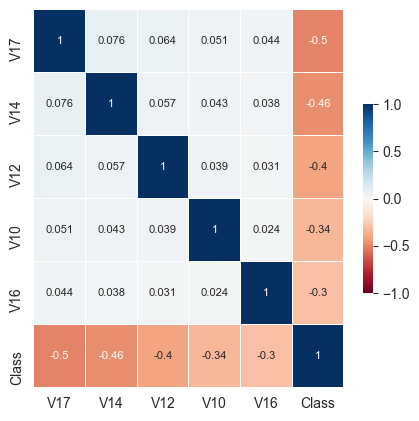

In [ ]:
## Visualizing correlation of Top5 feature variables with 'Class'
top5_features= list(corr_matrix_top10_class_only.index)[0:5]
top5_features.append('Class')
corr_matrix_top= corr_matrix[top5_features].corr()
plt.figure(figsize=(5,5),dpi=100)
sns.heatmap(corr_matrix_top, cmap= "RdBu", annot= True,cbar_kws={"shrink": .5}, vmin= -1, vmax=1, center=0,\
             linewidths=0.01, annot_kws={"size":8})
plt.show()

**Observation:** `Top 5 feature variables correlated with the dependent variable 'Class'` are **`V17, V14, V12, V10 and V16`** respectively.

#### Understanding the Distribution of Input Feature Variables

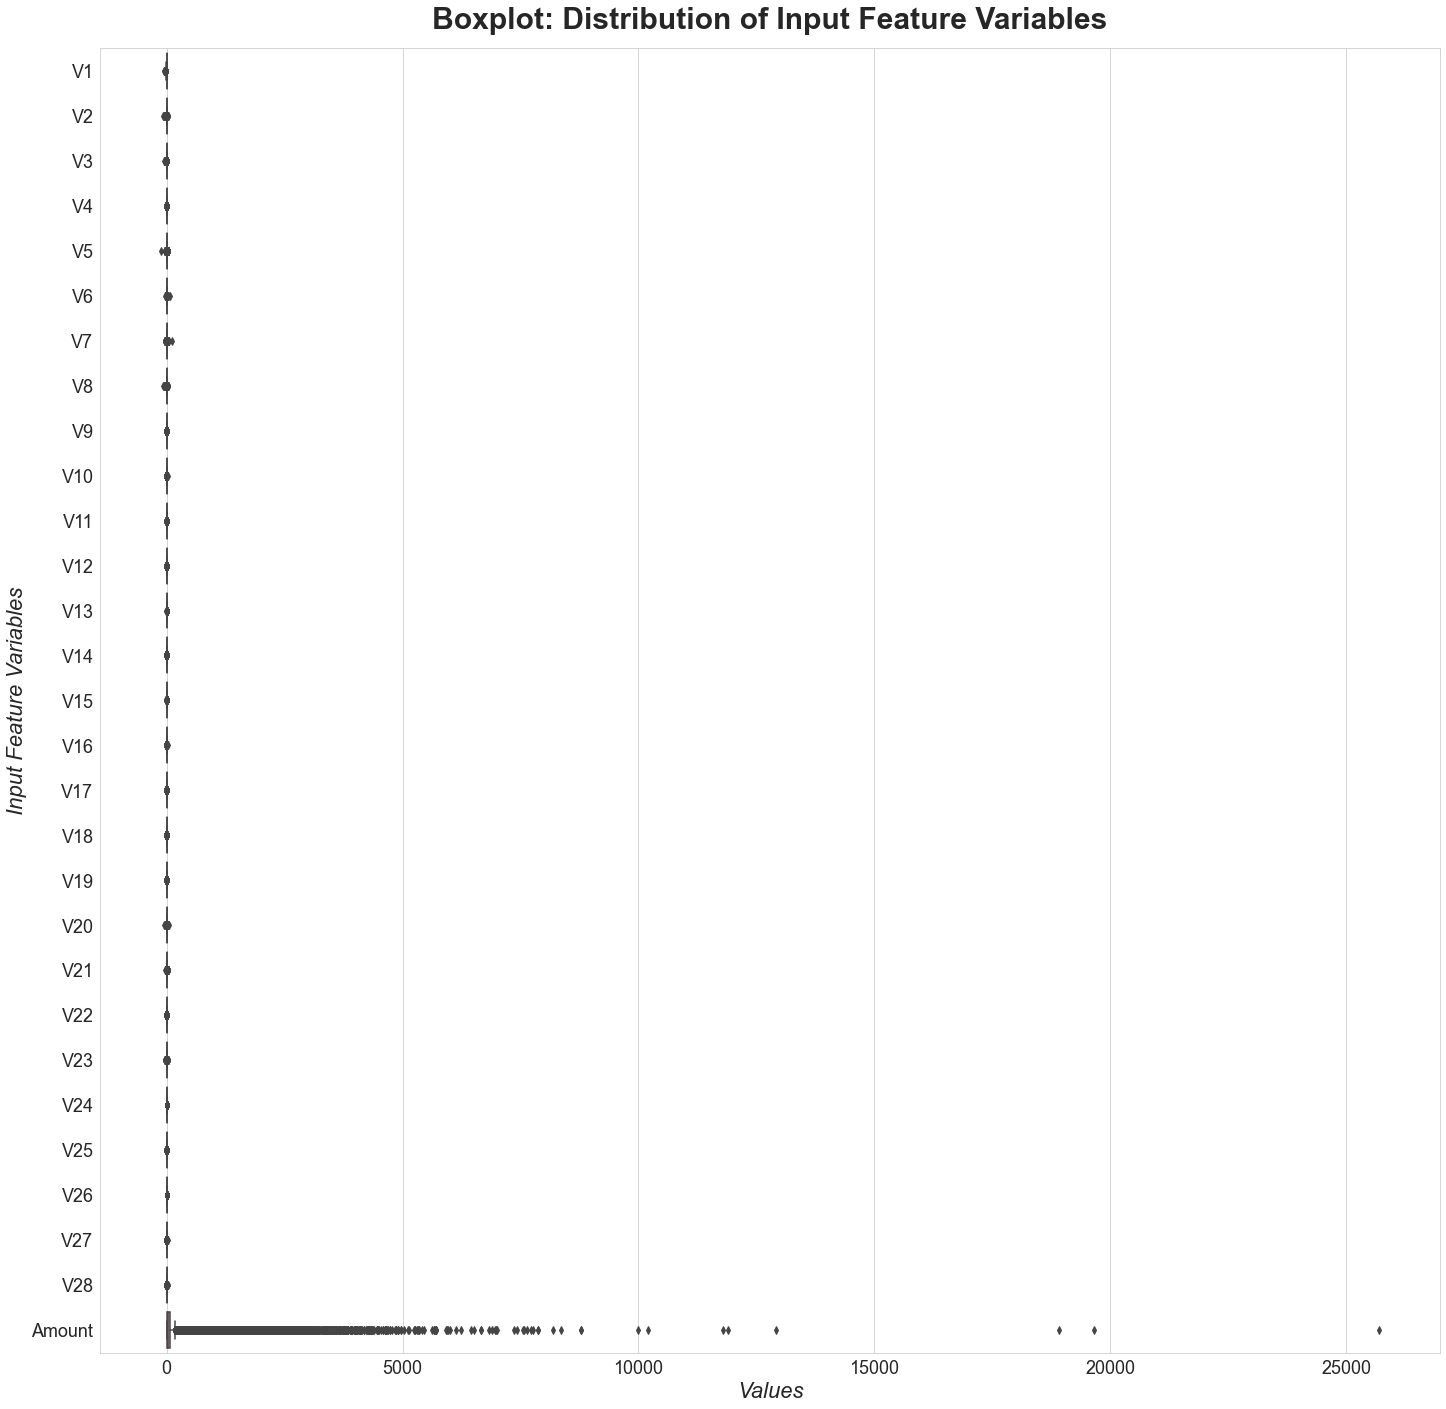

In [ ]:
# Boxplot to understand the distribution of numerical attributes :
numeric_feature_variables= df.select_dtypes(include=['float64','int64', 'int32'])

## Exluding dependent variables "Class" from the list
numeric_feature_variables= [i for i in numeric_feature_variables if i!="Class"]

plt.figure(figsize=(24,24))
sns.boxplot(data= df[numeric_feature_variables], orient= "h")
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("Boxplot: Distribution of Input Feature Variables", y=1.01, fontsize=30, fontweight='bold')
plt.ylabel("Input Feature Variables", fontstyle='italic', fontsize=22)
plt.xlabel("Values", fontstyle='italic', fontsize=22)
plt.show()

**Observation:**<br>(i) Among the input numerical variables, the `PCA features variables are centered across the mean 0`.  However, `skewness in the distribution has to be checked` in-depth. <br>(ii) `'Amount'` feature is `not centered across mean 0`.

## <font color=green>Splitting the data into train & test data

The class labels are binary encoded. So retaining them as is.

In [ ]:
## Create X and y dataset for independent and dependent data
y= df['Class']        #Class variable
X= df.drop("Class", axis=1)

### <font color=brown>Stratified Train-Test Split

In [ ]:
## Splitting the data into train and test data  (80:20)

## Create a STRATIFIED train-test (Hence, passing the argument 'stratify= y')
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.20, stratify= y)

In [ ]:
## Checking class distribution in stratified train-test split
print(black("In y dataset:",'bold'), Counter(y))
print(black("\nIn y_train set:",'bold'), Counter(y_train))
print(black("\nIn y_test set:",'bold'), Counter(y_test))

In y dataset: Counter({0: 284315, 1: 492})

In y_train set: Counter({0: 227451, 1: 394})

In y_test set: Counter({0: 56864, 1: 98})


**Observation:** We have successfully **split the imbalanced dataset in the train-test split ratio (80:20) using stratified train-test-split**.

##### <font color=purple>Preserve X_test & y_test to evaluate on the test data once you build the model

In [ ]:
# Note: The stratified train-test split ratio wasn't mentioned in the starter code.
# Considering train_test_split ratio (80:20)

print(np.sum(y))
print(np.sum(y_train))
print(np.sum(y_test))

492
394
98


### <font color=purple>Plotting the distribution of variables (visualization)

**(Check skewness in the TRAIN data) - Examining the distribution of all the input feature variables**

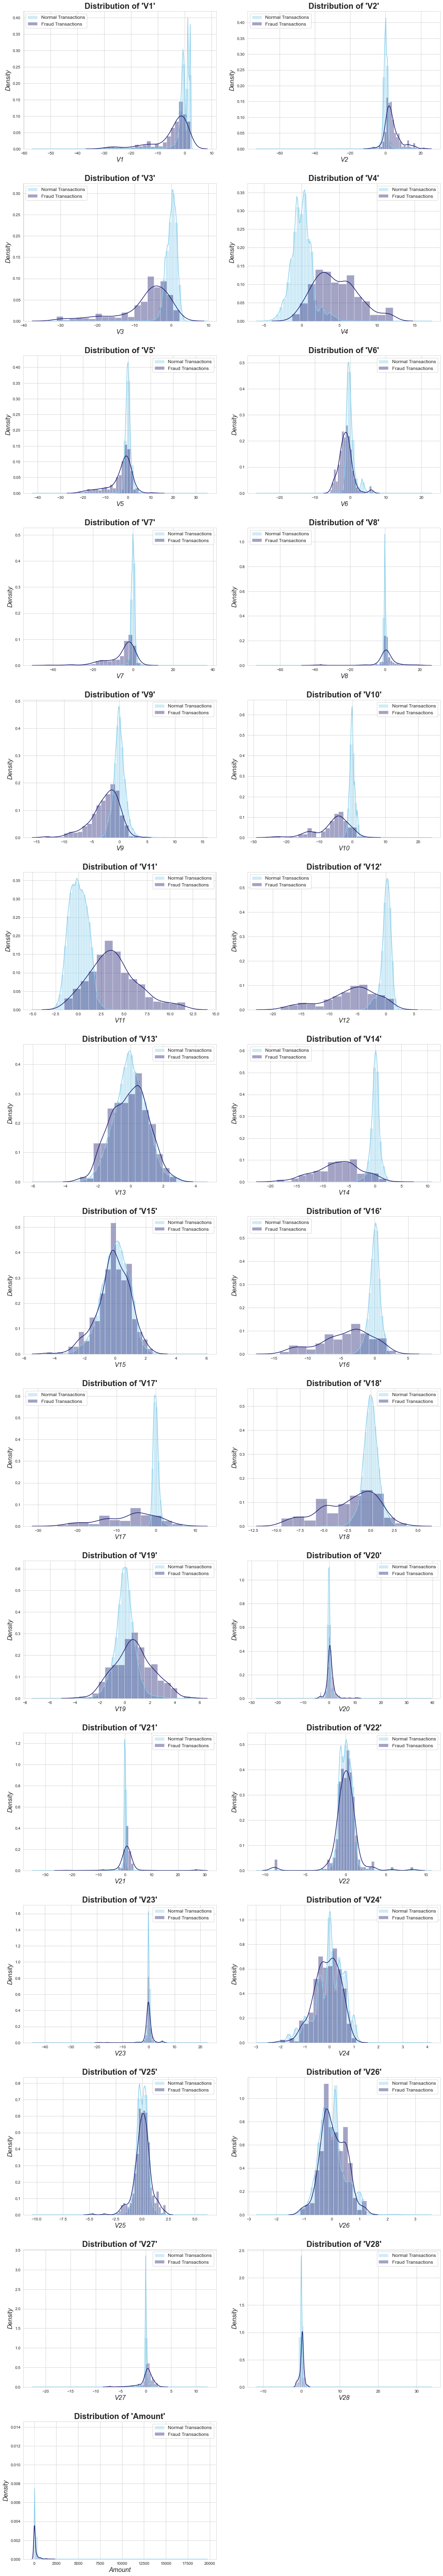

In [ ]:
# Plotting histograms to check the distribution of variables (in train data) for skewness

# Define a function for the plot
def plot_histograms_distribution_of_variables(check_data):
    input_feature_list= list(X.columns)       # list of input feature variables (analyzing entire dataset)

    f1, ax_skew1 = plt.subplots(15,2, figsize=(16,90))
    f1.delaxes(ax_skew1[14,1])    ## Passing indices of axes--This line will delete the last axis (used for odd-subplots)

    for index, feature in enumerate(input_feature_list):
        plt.subplot(15,2,index+1)
        sns.distplot(check_data[feature][df.Class == 0], label= "Normal Transactions", color='skyblue')       ## Distplot for feature density in Normal Transactions
        sns.distplot(check_data[feature][df.Class == 1], label= "Fraud Transactions", color= 'midnightblue')  ## Distplot for feature density in Fraud Transactions
        plt.title(f"Distribution of '{feature}'", fontsize= 20, fontweight='bold')
        plt.xlabel(feature, fontsize=16, fontstyle= 'italic')
        plt.ylabel("Density", fontsize=16, fontstyle= 'italic')
        plt.tight_layout(pad=3.0)   ##Increase spacing between subplots
        plt.legend(fontsize= 12)
    plt.show()

# Plotting histograms to check the distribution of variables (in train dataset) for skewness
plot_histograms_distribution_of_variables(X_train)

**Observation:** From the above graphs, `it is evident that skewness exists in the distribution of many variables within the train data. Also, we need to center the 'Amount' feature variable around mean 0.` Similarly, `we can expect to see  skewness in the test data`.

### <font color=purple>As we see that skewness is present in the distribution, we will be using:
- <b>Power Transformer</b> package present in the <b>preprocessing library provided by sklearn</b> to make distribution more gaussian

### <font color=Brown>Skewness Mitigation:</font>

**Dealing with skewness in the data using Power Transformer to make distribution more Gaussian**

In [ ]:
# - Apply : preprocessing.PowerTransformer(copy=False) to fit & transform the train data & transform the test data

## For X dataset (train and test)
pt = PowerTransformer(copy=False)                  ## Instantiate an object of PowerTransformer() class
X_train_pt= pt.fit_transform(X_train)              ## fit_transform train set
X_test_pt = pt.transform(X_test)                   ## Transform only: test set

In [ ]:
## Create a dataframes for PowerTransformed 'X_train' and 'X_test' respectively (to be used later)
X_train_pt_df= pd.DataFrame(data= X_train_pt, columns= list(X.columns))
X_test_pt_df= pd.DataFrame(data= X_test_pt, columns= list(X.columns))

#### <font color= purple> Rechecking and Visualizing (Plotting) the distribution of input feature variables (after using PowerTransformer).

**1. Visualising the distribution of variables (Train Data)**

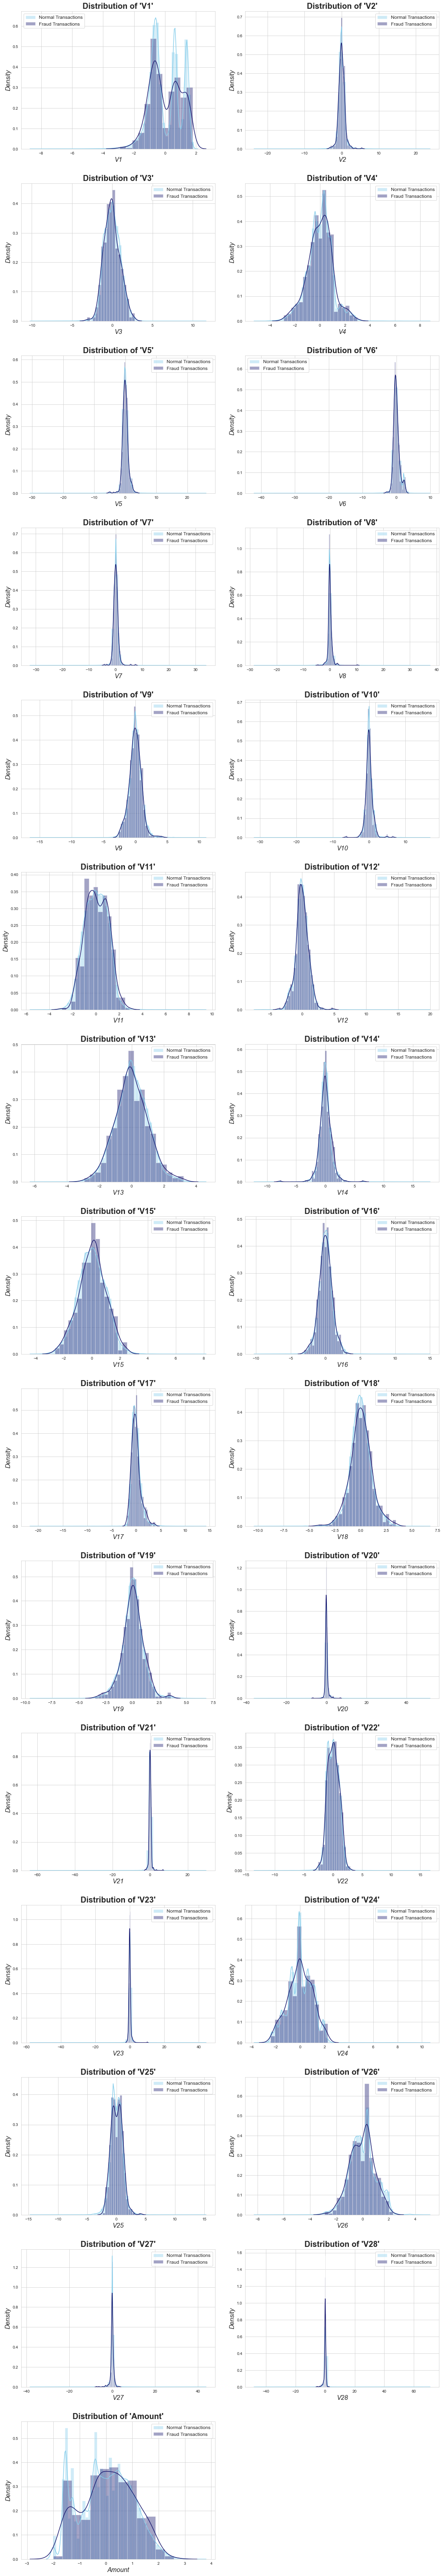

In [ ]:
# Plotting histograms to check the distribution of variables (in power transformed 'X_train_pt_df' set) for skewness
plot_histograms_distribution_of_variables(X_train_pt_df)

**Observation:** The `distribution of variables from the TRAIN dataset` is now `more gaussian in nature` and all feature variables are `centered about mean 0.` Thus, `skewness in the distribution of variables in the TRAIN dataset is mitigated successfully`.

**2. Visualising the distribution of variables (Test Data)**

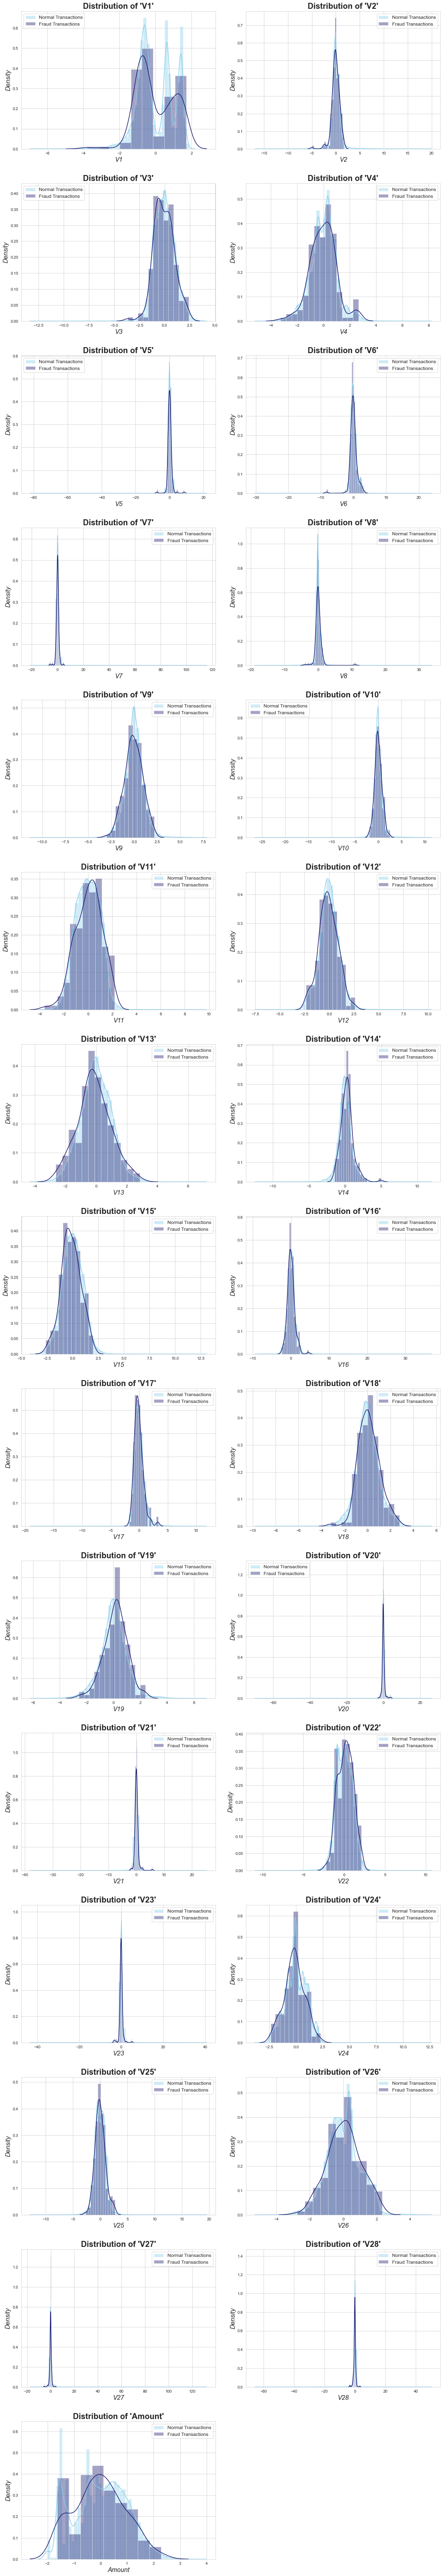

In [ ]:
# Plotting histograms to check the distribution of variables (in power transformed 'X_test_pt_df' set) for skewness
plot_histograms_distribution_of_variables(X_test_pt_df)

**Observation:** The `distribution of variables from the TEST dataset` is now `more gaussian in nature` and and all feature variables are `centered about mean 0.` Thus, `skewness in the distribution of variables in the TEST dataset is mitigated successfully`.

## <font color=green>**Model Building**
- Build different models on the imbalanced dataset and see the result

In [ ]:
#Create a pandas dataframe to store model results
results_df = pd.DataFrame(columns=['Data Handling Technique','Model', 'ROC_AUC_cv', 'ROC_AUC_test', 'Threshold', 'Precision','Recall','F1 score'])

In [ ]:
## Define a function to plot ROC_AUC curve
def plot_roc_auc_curve(fpr, tpr, roc_auc):
    print(f"ROC for test dataset {round(roc_auc*100,3)}%")
    plt.figure(figsize=(5,5))
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.plot(fpr,tpr,'b',label="Test ROC_AUC="+str(round(roc_auc,3)))
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('True Positive Rate (TPR)')
    plt.xlabel('False Positive Rate (FPR)')
    plt.legend(loc='lower right')
    plt.show()

In [ ]:
## Function for printing the cross-validation results:
def best_cross_val_results(clf,data_handling_technique, model_name):
    print(black(f"\nData Handling Technique: {data_handling_technique}\nModel Name: {model_name}",'bold'))
    print(black("\n\nEvaluation results from cross-validation and optimal hyperparameters",'bold'))
    # Best Model and optimal hyperparameters
    print("Best Estimator:\n", clf.best_estimator_._final_estimator)
    print("Best ROC_AUC (mean cross-validated score):", clf.best_score_)
    print("Best (Optimal) Parameters:", clf.best_params_)

In [ ]:
# Function for prediction and evaluation results on test data:
def prediction_evaluation_results(clf,X_train,y_train,X_test,y_test, data_handling_technique,model_name,results_df):
    print(black("\nPrediction and Evaluation results: On Actual TEST SET",'bold'))
    y_pred= clf.predict(X_test)                                             # Find predicted values
    y_pred_probs = clf.predict_proba(X_test)[:,1]                           # Find predicted probabilities
    precision = metrics.precision_score(y_pred=y_pred, y_true=y_test)           # Precision and Recall Scores
    recall= metrics.recall_score(y_pred=y_pred, y_true=y_test)
    f1_score= metrics.f1_score(y_pred=y_pred, y_true=y_test)                    # f1_score
    test_roc_auc = metrics.roc_auc_score(y_score= y_pred_probs, y_true=y_test)  # Test ROC_AUC
    print(f"\nTest ROC_AUC: {test_roc_auc}")
    test_accuracy = metrics.accuracy_score(y_pred=y_pred, y_true=y_test)        # test accuracy
    print(f"Test Accuracy: {test_accuracy}");print()
    print("Confusion Matrix")                                                   # print confusion matrix
    print_model_metrics(y_test, y_pred)
    print("Classification Report")                                              # Print classification report
    print(classification_report(y_test, y_pred))
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs)              # fpr, tpr and threshold
    threshold= thresholds[np.argmax(tpr-fpr)]                                   # Find the optimal threshold value
    print("Optimal Threshold:", threshold)
    plot_roc_auc_curve(fpr, tpr, test_roc_auc)                                  # Plot ROC_AUC curve for test dataset (using defined function)
    ## Store results
    results_store_df= pd.DataFrame({'Data Handling Technique': [data_handling_technique],'Model': [model_name],
                            'ROC_AUC_cv': [clf.best_score_],'ROC_AUC_test': [test_roc_auc],'Threshold': [threshold],
                                    'Precision': [precision],'Recall': [recall],'F1 score':[f1_score]})
    return results_store_df

### <font color=purple>Defining functions to build the following ML models:</font>
1. Logistic Regression
2. Decision Tree
3. XGBoost
4. Random Forest
5. SVM
6. KNN

In [ ]:
## All necessary steps below are covered within model building functions:

# perform cross validation (stratified cross-validation)
# perform hyperparameter tuning
# print the evaluation result by choosing a evaluation metric
# print the optimum value of hyperparameters

**Proceed with the model which shows the best result***
- Apply the best hyperparameter on the model
- Predict on the test dataset

#### <font color=darkblue>1. Logistic Regression Model with StratifiedKFoldCV

*(Note: num_C and cv_num are defined in the function LogisticRegression_StratifiedKFoldCV_Model()* - (below)

In [ ]:
## Define a function LogisticRegression_StratifiedKFoldCV_Model()-- to cross-validate, tune hyperparameters,
## build optimal model and provide evaluation results.

def LogisticRegression_StratifiedKFoldCV_Model(sampling_technique, X_train, y_train, X_test, y_test, data_handling_technique, model_name, results_df):
    start= time.time();print("*"*100)
    np.random.seed(0)
    num_C= list(np.power(10.0, np.arange(-4,5)))                           #--> ## list of values -- num_C (i.e. Cs values) (Hyperparameter of LogisticRegression Model)
    # Performing cross-validation and hyperparameter tuning
    cv_num= 3                                                              # Note: cv_num: number of cross-validation splits
    skf = StratifiedKFold(n_splits= cv_num, random_state=0, shuffle=True)  # StratifiedKFold cross-validator

    # Create a pipeline:
    if sampling_technique==None:
        pipe_lr= make_pipeline(LogisticRegression(n_jobs=-1,max_iter=1000,random_state=0))
    else:
        pipe_lr = make_pipeline(sampling_technique, LogisticRegression(n_jobs=-1,max_iter=1000,random_state=0))
    # Param_distributions (Create both estimators: find optimal estimator- L1/L2 regularization)
    params_lr= [{
                "logisticregression__penalty": ['l2'],
                "logisticregression__C":num_C,
                "logisticregression__solver":['newton-cg', 'lbfgs', 'sag', 'saga', 'liblinear'] # solvers that allow L2 penalty
                },
                {
                "logisticregression__penalty": ['l1'],
                "logisticregression__C":num_C,
                "logisticregression__solver":['saga', 'liblinear']  # solvers that allow L1 penalty
                }]
    clf= RandomizedSearchCV(                                               ## Performs Cross-validation
                          estimator=pipe_lr,
                          param_distributions=params_lr,                   ## Hyperparameters to be tuned
                          n_jobs=-1,
                          cv=skf,
                          scoring='roc_auc',                               ## Scoring metric 'roc_auc'
                          verbose = 1,
                          return_train_score=True,
                          error_score=0)
    clf.fit(X_train_pt,y_train)
    optimal_solver= clf.best_params_['logisticregression__solver']  ## Storing optimal hyperparameters in variables
    optimal_penalty= clf.best_params_['logisticregression__penalty']
    optimal_C= float(clf.best_params_['logisticregression__C'])
    best_cross_val_results(clf,data_handling_technique, model_name)        ## Get best cross_validation result
    ##Initialize the classifier with optimal hyperparameters
    clf_opt= clf.best_estimator_._final_estimator    ## Best estimator already found out above, after fitting on (X_train,y_train)

    print(black("\nOptimal hyperparameters:",'bold'))
    print("Best C value:", optimal_C)
    print("Best penalty:", optimal_penalty)
    print("Best solver:", optimal_solver)
    # prediction and evaluation results on actual TEST data
    results_store_df= prediction_evaluation_results(clf, X_train, y_train, X_test, y_test,
                                                data_handling_technique, model_name, results_df)
    results_df= results_df.append(results_store_df, ignore_index=True)   ## Appending the results to 'results_df' dataframe
    end= time.time()
    time_req_mins = (end-start)/60
    print(f"\nTime required to train the model: {round(time_req_mins)} minutes");print("*"*100)
    return results_df, clf_opt

#### <font color=darkblue>2. Decision Tree Model with StratifiedKFoldCV

In [ ]:
## Defining a function for building a  DecisionTree_StratifiedKFoldCV_Model() - to cross-validate, tune hyperparameters,
##  build optimal model and provide evaluation results.

def DecisionTree_StratifiedKFoldCV_Model(sampling_technique,X_train, y_train, X_test, y_test, data_handling_technique, model_name, results_df):
    start= time.time()
    print("*"*100)

    np.random.seed(0)
    ## StratifiedKFold cross-validator
    cv_num=3
    skf = StratifiedKFold(n_splits= cv_num, random_state=0, shuffle=True)       ## Note: number of cross-validation splits, cv_num=3 (defined previously)
    ## Perform cross-validation and hyperparameter tuning

    # Create a pipeline: (Advatange: Flow of code and pipelines also make sure that validation sets are not oversampled within folds)
    if sampling_technique==None:
        pipe_dt= make_pipeline(DecisionTreeClassifier(random_state=0))                          # Defining the model
    else:
        pipe_dt= make_pipeline(sampling_technique, DecisionTreeClassifier(random_state=0))

    max_depth=list(range(3,10,1))                                        ## Hyperparameter: max_depth to be tuned
    min_samples_leaf= [1,2,4,10,20,30]                                   ## Hyperparameter: min_samples_leaf to be tuned
    criterion= ['gini','entropy']                                        ## Hyperparameter: criterion to be tuned
    max_features=['sqrt','log2',None]                                    ## Hyperparameter: max_features to be tuned
    min_samples_split=[2,3,5,10,20,30,50]
    # Params_distributions
    params_dt={
                'decisiontreeclassifier__min_samples_split': min_samples_split,
                'decisiontreeclassifier__min_samples_leaf':min_samples_leaf,
                'decisiontreeclassifier__max_features':max_features,
                'decisiontreeclassifier__max_depth':max_depth,
                'decisiontreeclassifier__criterion':criterion}

    clf= RandomizedSearchCV(                                                    # Performing cross-validation
                            estimator=pipe_dt,
                            param_distributions=params_dt,
                            n_jobs=-1,
                            cv=skf,
                            scoring='roc_auc',                                  ## Scoring metric 'roc_auc'
                            verbose = 1,
                            n_iter=50,
                            return_train_score=True,
                            error_score=0)
    clf.fit(X_train, y_train)
    optimal_min_samples_split=int(clf.best_params_['decisiontreeclassifier__min_samples_split'])  ## Storing optimal hyperparameters
    optimal_min_samples_leaf=int(clf.best_params_['decisiontreeclassifier__min_samples_leaf'])
    optimal_max_features= clf.best_params_['decisiontreeclassifier__max_features']
    optimal_max_depth= int(clf.best_params_['decisiontreeclassifier__max_depth'])
    optimal_criterion= clf.best_params_['decisiontreeclassifier__criterion']
    best_cross_val_results(clf,data_handling_technique, model_name)          # Get best cross_validation results
    # Initialize the model with optimal hyperparameters
    clf_opt= clf.best_estimator_._final_estimator     ## Best estimator already found out above, after fitting on (X_train,y_train)

    print(black("\nOptimal hyperparameters:",'bold'))
    print("Best min_samples_split:", optimal_min_samples_split)
    print("Best min_samples_leaf:", optimal_min_samples_leaf)
    print("Best max_features:", optimal_max_features)
    print("Best max_depth:", optimal_max_depth)
    print("Best criterion:", optimal_criterion)
    # prediction and evaluation results on actual TEST data
    results_store_df= prediction_evaluation_results(clf, X_train, y_train, X_test, y_test,
                                                    data_handling_technique, model_name, results_df)
    results_df= results_df.append(results_store_df, ignore_index=True)  ## Appending the results to 'results_df' dataframe
    end= time.time()
    time_req_mins = (end-start)/60
    print(f"\nTime required to train the model: {round(time_req_mins)} minutes")
    print("*"*100)
    return results_df, clf_opt

#### <font color=darkblue>3. XGBoost Model with StratifiedKFoldCV

In [ ]:
## Define a function for XGBoost_StratifiedKFoldCV_Model()-- to cross-validate, tune hyperparameters,
## build optimal model and provide evaluation results.

def XGBoost_StratifiedKFoldCV_Model(sampling_technique,X_train, y_train, X_test, y_test, data_handling_technique, model_name, results_df):
    start= time.time()
    print("*"*100)

    np.random.seed(0)
    ## StratifiedKFold cross-validator
    cv_num=3
    skf = StratifiedKFold(n_splits= cv_num, random_state=0, shuffle=True)       ## Note: number of cross-validation splits, cv_num=3 (defined previously)
    ## Perform cross-validation and hyperparameter tuning
    # Create a pipeline:
    if sampling_technique==None:
        pipe_xgb= make_pipeline(XGBClassifier(objective='binary:logistic',    # Defining the model
                                              n_jobs=-1,verbosity=0, random_state=0))
    else:
        pipe_xgb = make_pipeline(sampling_technique, XGBClassifier(objective='binary:logistic',
                                              n_jobs=-1,verbosity=0, random_state=0))
    learning_rate= [0.05, 0.1, 0.2, 0.3]                            # Hyperparameter: (learning_rate) to be tuned
    n_estimators= [10,50,100,200,300,500,700,900,1000,1200]         # Hyperparameter: n_estimators to be tuned
    max_depth= list(range(3,10,2))                                  # Hyperparameter: 'max_depth' to be tuned
    # Param_distributions
    params_xgb={
                'xgbclassifier__n_estimators':n_estimators,
                'xgbclassifier__max_depth': max_depth,
                'xgbclassifier__learning_rate':learning_rate}
    clf= RandomizedSearchCV(                                             ## Performs Cross-validation
                            estimator=pipe_xgb,
                            param_distributions=params_xgb,
                            n_jobs=-1,
                            cv=skf,
                            scoring='roc_auc',                           ## Scoring metric 'roc_auc'
                            verbose=1,
                            return_train_score=True,
                            error_score=0)
    clf.fit(X_train, y_train)
    optimal_n_estimators= int(clf.best_params_['xgbclassifier__n_estimators'])
    optimal_max_depth= int(clf.best_params_['xgbclassifier__max_depth'])
    optimal_learning_rate= float(clf.best_params_['xgbclassifier__learning_rate'])
    best_cross_val_results(clf,data_handling_technique, model_name)     ## Get best cross_validation results
    ##Initialize the classifier with optimal hyperparameters
    clf_opt = clf.best_estimator_._final_estimator      ## Best estimators found earlier, already fit on (X_train, y_train)

    print(black("\nOptimal hyperparameters:",'bold'))
    print("Best number of trees:", optimal_n_estimators)
    print("Best max depth:", optimal_max_depth)
    print("Best learning rate:", optimal_learning_rate)
    # prediction and evaluation results on actual TEST data
    results_store_df= prediction_evaluation_results(clf, X_train, y_train, X_test, y_test,
                                                data_handling_technique, model_name, results_df)
    results_df= results_df.append(results_store_df, ignore_index=True)   ## Appending the results to 'results_df' dataframe
    end= time.time()
    time_req_mins = (end-start)/60
    print(f"\nTime required to train the model: {round(time_req_mins)} minutes")
    print("*"*100)
    return results_df, clf_opt

#### <font color=darkblue>4. Random Forest Model with StratifiedKFoldCV

In [ ]:
## Define a function for RandomForest_StratifiedKFoldCV_Model()-- to cross-validate, tune hyperparameters,
## build optimal model and provide evaluation results.

def RandomForest_StratifiedKFoldCV_Model(sampling_technique,class_weight_input, X_train, y_train, X_test, y_test, data_handling_technique, model_name, results_df):
    start= time.time()
    print("*"*100)
    np.random.seed(0)

    ## StratifiedKFold cross-validator
    cv_num=3
    skf = StratifiedKFold(n_splits= cv_num, random_state=0, shuffle=True)    ## Note: number of cross-validation splits, cv_num=3 (defined previously)
    ## Perform cross-validation and hyperparameter tuning
    # Create a pipeline:
    if sampling_technique==None:
        pipe_rfc= make_pipeline(RandomForestClassifier(class_weight=class_weight_input,          # Defining the model
                            warm_start=True,verbose=0,n_jobs=-1,random_state=0))
    else:
        pipe_rfc= make_pipeline(sampling_technique, RandomForestClassifier(class_weight=class_weight_input,
                            warm_start=True,verbose=0,n_jobs=-1,random_state=0))
    n_estimators=[100,300,500,600,700,850,1000,1200]              ## Hyperparameter: n_estimators to be tuned
    min_samples_split=[2,5,7,10]                                  ## Hyperparameter: min_samples_split to be tuned
    min_samples_leaf= [1,2,4]                                     ## Hyperparameter: min_samples_leaf to be tuned
    max_features=['auto', 'sqrt', 'log2', None]                   ## Hyperparameter: max_features to be tuned
    max_depth= [3,5,7,9]                                          ## Hyperparameter: max_depth to be tuned
    criterion= ['gini','entropy']                                 ## Hyperparameter: criterion to be tuned
    ## Param_distributions
    params_rfc={
                'randomforestclassifier__n_estimators': n_estimators,
                'randomforestclassifier__min_samples_split':min_samples_split,
                'randomforestclassifier__min_samples_leaf':min_samples_leaf,
                'randomforestclassifier__max_features': max_features,
                'randomforestclassifier__max_depth':max_depth,
                'randomforestclassifier__criterion': criterion}
    clf= RandomizedSearchCV(                                              ## Performing cross-validation
                            estimator=pipe_rfc,
                            param_distributions=params_rfc,
                            n_jobs=-1,
                            cv=skf,
                            scoring='roc_auc',                            ## Scoring metric 'roc_auc'
                            verbose = 1,
                            return_train_score=True,
                            error_score=0)
    clf.fit(X_train, y_train)
    optimal_n_estimators= int(clf.best_params_['randomforestclassifier__n_estimators'])
    optimal_min_samples_split= int(clf.best_params_['randomforestclassifier__min_samples_split'])
    optimal_min_samples_leaf= int(clf.best_params_['randomforestclassifier__min_samples_leaf'])
    optimal_max_features= clf.best_params_['randomforestclassifier__max_features']
    optimal_max_depth= int(clf.best_params_['randomforestclassifier__max_depth'])
    optimal_criterion= clf.best_params_['randomforestclassifier__criterion']
    best_cross_val_results(clf,data_handling_technique, model_name)      # Get best cross_validation results
    ##Initialize the classifier with optimal hyperparameters
    clf_opt = clf.best_estimator_._final_estimator      ## Best estimators found earlier, already fit on (X_train, y_train)

    print(black("\nOptimal hyperparameters:",'bold'))
    print("Best number of trees:", optimal_n_estimators)
    print("Best min_samples_split:", optimal_min_samples_split)
    print("Best min_samples_leaf:", optimal_min_samples_leaf)
    print("Best max_features:", optimal_max_features)
    print("Best max_depth:", optimal_max_depth)
    print("Best criterion:", optimal_criterion)
    # prediction and evaluation results on actual TEST data
    results_store_df= prediction_evaluation_results(clf, X_train, y_train, X_test, y_test,
                                                data_handling_technique, model_name, results_df)
    results_df= results_df.append(results_store_df, ignore_index=True)   ## Appending the results to 'results_df' dataframe
    end= time.time()
    time_req_mins = (end-start)/60
    print(f"\nTime required to train the model: {round(time_req_mins)} minutes")
    print("*"*100)
    return results_df, clf_opt

#### <font color=darkblue>5. SVM Model with StratifiedKFoldCV

In [ ]:
## Defining a function for building a SVM_StratifiedKFoldCV_Model() - to cross-validate, tune hyperparameters,
## build optimal model and provide evaluation results.

def SVM_StratifiedKFoldCV_Model(sampling_technique,X_train, y_train, X_test, y_test, data_handling_technique, model_name, results_df):
    start= time.time()
    print("*"*100)

    np.random.seed(0)
    ## StratifiedKFold cross-validator
    cv_num=3
    skf = StratifiedKFold(n_splits= cv_num, random_state=0, shuffle=True)  ## Note: number of cross-validation splits, cv_num=3 (defined previously)
    ## Perform cross-validation and hyperparameter tuning
    # Create a pipeline:
    if sampling_technique==None:
        pipe_svc= make_pipeline(SVC(kernel='rbf',gamma='scale',       # Defining the model
                   probability= True,verbose=True,random_state=0))    # IMP: Enable probability estimates for predict_proba
    else:
        pipe_svc= make_pipeline(sampling_technique, SVC(kernel='rbf',gamma='scale',
                   probability= True,verbose=True,random_state=0))
    num_C= list(np.power(10.0, np.arange(-3,4)))                  # Hyperparameter: C values (in float) - ALL positive only!
    params_svc={'svc__C':num_C}                                   # Param_distributions
    clf= RandomizedSearchCV(                                      # Performing cross-validation
                            estimator=pipe_svc,
                            param_distributions=params_svc,
                            n_jobs=-1,
                            cv=skf,
                            scoring='roc_auc',                          ## Scoring metric 'roc_auc'
                            verbose = 1,
                            return_train_score=True,
                            error_score=0)
    clf.fit(X_train, y_train)
    optimal_C= float(clf.best_params_['svc__C'])                        ## Optimal C
    best_cross_val_results(clf,data_handling_technique, model_name)     ## Get best cross_validation results
    ##Initialize the classifier with optimal hyperparameters
    clf_opt = clf.best_estimator_._final_estimator                      ## Best estimators found earlier, already fit on (X_train, y_train)

    print(black("\nOptimal hyperparameters:",'bold'))
    print("Best C:", optimal_C)
    # prediction and evaluation results on actual TEST data
    results_store_df= prediction_evaluation_results(clf, X_train, y_train, X_test, y_test,
                                                data_handling_technique, model_name, results_df)
    results_df= results_df.append(results_store_df, ignore_index=True)   ## Appending the results to 'results_df' dataframe
    end= time.time()
    time_req_mins = (end-start)/60
    print(f"\nTime required to train the model: {round(time_req_mins)} minutes")
    print("*"*100)
    return results_df, clf_opt

#### <font color=darkblue>6. KNN Model with StratifiedKFoldCV

In [ ]:
## Defining a function for building a KNN_StratifiedKFoldCV_Model() - - to cross-validate, tune hyperparameters,
## build optimal model and provide evaluation results.

def KNN_StratifiedKFoldCV_Model(sampling_technique,X_train, y_train, X_test, y_test, data_handling_technique, model_name, results_df):
    start= time.time()
    print("*"*100)

    np.random.seed(0)
    # Performing cross-validation and hyperparameter tuning
    cv_num= 3
    k_range = list(range(3,35,2))                                    ## Iterating over range of odd K values from 3 to 33
    # StratifiedKFold  cross-validator
    skf = StratifiedKFold(n_splits= cv_num, random_state=0, shuffle=True)        ## Note: number of cross-validation splits, cv_num=3 (defined previously)

    # Create a pipeline:
    if sampling_technique==None:
        pipe_knn= make_pipeline(KNeighborsClassifier(n_jobs=-1))                # Defining the model
    else:
        pipe_knn= make_pipeline(sampling_technique, KNeighborsClassifier(n_jobs=-1))
    # Param_distributions
    params_knn= {'kneighborsclassifier__n_neighbors': k_range}                   ## List of hyperparameters to be tuned
    clf= RandomizedSearchCV(                                                     ## Performs Cross-validation
                            estimator=pipe_knn,
                            param_distributions=params_knn,
                            n_jobs=-1,
                            cv=skf,
                            scoring='roc_auc',                                   ## Scoring metric 'roc_auc'
                            verbose = 1,
                            n_iter=20,                                           ## Perform more iterations
                            return_train_score=True,
                            error_score=0)
    clf.fit(X_train, y_train)
    optimal_n_neighbors= int(clf.best_params_['kneighborsclassifier__n_neighbors'])
    best_cross_val_results(clf,data_handling_technique, model_name)
    ##Initialize the classifier with optimal hyperparameters
    clf_opt= clf.best_estimator_._final_estimator    ## Best estimator found earlier and already fit on (X_train,y_train)

    print(black("\nOptimal hyperparameters:",'bold'))
    print("Best n_neighbors (K):", optimal_n_neighbors)
    # prediction and evaluation results on actual TEST data
    results_store_df= prediction_evaluation_results(clf, X_train, y_train, X_test, y_test,
                                                data_handling_technique, model_name, results_df)
    results_df= results_df.append(results_store_df, ignore_index=True)   ## Appending the results to 'results_df' dataframe
    end= time.time()
    time_req_mins = (end-start)/60
    print(f"\nTime required to train the model: {round(time_req_mins)} minutes")
    print("*"*100)
    return results_df, clf_opt

### <font color=Brown>**Model building on Imbalanced Dataset**

#### <font color=DarkBlue> **1. Logistic Regression Model (Imbalanced Dataset)**

In [ ]:
## Logistic Regression
num_C = list(np.power(10.0, np.arange(-4,5)))    #--> ## list of values

# StratifiedKFold cross-validator
cv_num =3   ## Note: cv_num->number of cross-validation splits
skf = StratifiedKFold(n_splits= cv_num, random_state=0, shuffle=True)

#### perfom cross validation on the X_train & y_train to create:
- X_train_cv
- X_test_cv
- y_train_cv
- y_test_cv

**Perform StratifiedKFold Cross Validation on X_train (i.e. X_train_pt_df) and y_train**

In [ ]:
## Let's perform StratifiedKFold strategy and check the results of folds (splits)
cv_num= 3                  ## Specify num of cv splits in cv_num
skf = StratifiedKFold(n_splits= cv_num, random_state=0, shuffle=True)

# 'X_train_pt_df' is the feature set (Power Transformed X_train dataframe) and y_train is the target train set
print("Overview of StratifiedKFoldCV splits:")
for train_index, test_index in skf.split(X_train_pt_df,y_train):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train_cv, X_test_cv = X_train_pt_df.iloc[train_index], X_train_pt_df.iloc[test_index]
    y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]

Overview of StratifiedKFoldCV splits:
TRAIN: [     0      1      3 ... 227841 227842 227844] TEST: [     2      4      6 ... 227829 227836 227843]
TRAIN: [     1      2      3 ... 227842 227843 227844] TEST: [     0      9     12 ... 227837 227838 227841]
TRAIN: [     0      2      4 ... 227838 227841 227843] TEST: [     1      3      5 ... 227840 227842 227844]


*We will be performing cross-validation `using RandomizedSearchCV and passing model via 'imblearn pipeline'` as stated in the modeling approach `(which performs the StratifiedKFold cross-validation in a similar fashion as seen above)`.*

#### <font color=DarkBlue> **1.1 Logistic Regression Model (Imbalanced Dataset)**

****************************************************************************************************
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Data Handling Technique: Power Transformer (Imbalanced Dataset)
Model Name: Logistic Regression with StratifiedKFoldCV


Evaluation results from cross-validation and optimal hyperparameters
Best Estimator:
 LogisticRegression(C=0.01, max_iter=1000, n_jobs=-1, random_state=0)
Best ROC_AUC (mean cross-validated score): 0.9796472926534644
Best (Optimal) Parameters: {'logisticregression__solver': 'lbfgs', 'logisticregression__penalty': 'l2', 'logisticregression__C': 0.01}

Optimal hyperparameters:
Best C value: 0.01
Best penalty: l2
Best solver: lbfgs

Prediction and Evaluation results: On Actual TEST SET

Test ROC_AUC: 0.9753631651028447
Test Accuracy: 0.9991748885221726

Confusion Matrix
 Model Stats Scores Summary : 


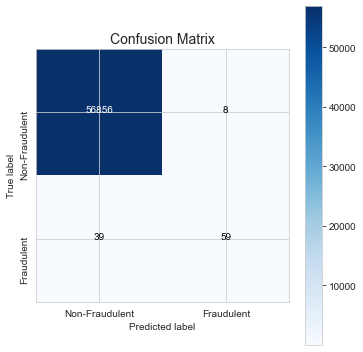

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.88      0.60      0.72        98

    accuracy                           1.00     56962
   macro avg       0.94      0.80      0.86     56962
weighted avg       1.00      1.00      1.00     56962

Optimal Threshold: 0.004026606186147013
ROC for test dataset 97.536%


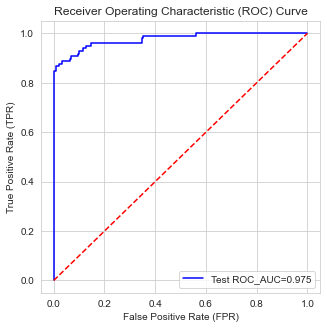


Time required to train the model: 3 minutes
****************************************************************************************************


In [ ]:
# LOGISTIC REGRESSION MODEL (IMBALANCED DATASET)
# Building Model and Evaluating Results
results_df, clf_lr_imbal_data= LogisticRegression_StratifiedKFoldCV_Model(None, X_train_pt, y_train,
                                            X_test_pt, y_test, "Power Transformer (Imbalanced Dataset)",
                                        "Logistic Regression with StratifiedKFoldCV", results_df)

#### <font color=DarkBlue> **1.2 Decision Tree Model (Imbalanced Dataset)**

****************************************************************************************************
Fitting 3 folds for each of 50 candidates, totalling 150 fits

Data Handling Technique: Power Transformer (Imbalanced Dataset)
Model Name: Decision Tree with StratifiedKFoldCV


Evaluation results from cross-validation and optimal hyperparameters
Best Estimator:
 DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=30,
                       min_samples_split=5, random_state=0)
Best ROC_AUC (mean cross-validated score): 0.9696500652674303
Best (Optimal) Parameters: {'decisiontreeclassifier__min_samples_split': 5, 'decisiontreeclassifier__min_samples_leaf': 30, 'decisiontreeclassifier__max_features': None, 'decisiontreeclassifier__max_depth': 5, 'decisiontreeclassifier__criterion': 'entropy'}

Optimal hyperparameters:
Best min_samples_split: 5
Best min_samples_leaf: 30
Best max_features: None
Best max_depth: 5
Best criterion: entropy

Prediction and Evaluation result

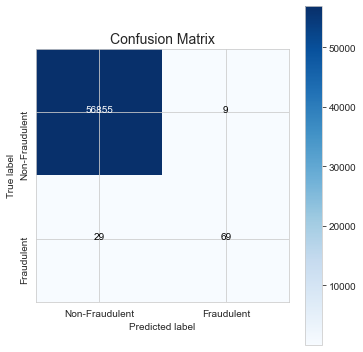

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.88      0.70      0.78        98

    accuracy                           1.00     56962
   macro avg       0.94      0.85      0.89     56962
weighted avg       1.00      1.00      1.00     56962

Optimal Threshold: 0.022727272727272728
ROC for test dataset 95.278%


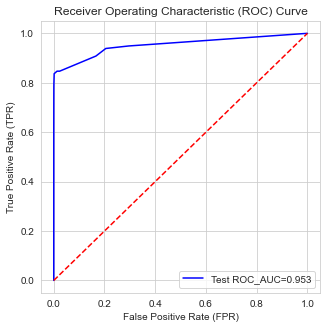


Time required to train the model: 2 minutes
****************************************************************************************************


In [ ]:
## Decision Tree Model [Imbalanced Dataset]
results_df, clf_dt_imbal_data = DecisionTree_StratifiedKFoldCV_Model(None,X_train_pt, y_train, X_test_pt, y_test,
                         "Power Transformer (Imbalanced Dataset)", "Decision Tree with StratifiedKFoldCV", results_df)

#### <font color=DarkBlue> **1.3 XGBoost Model (Imbalanced Dataset)**

****************************************************************************************************
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Data Handling Technique: Power Transformer (Imbalanced Dataset)
Model Name: XGBoost with StratifiedKFoldCV


Evaluation results from cross-validation and optimal hyperparameters
Best Estimator:
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=700, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0)
Best ROC_AUC (mean cross-validated score): 0.9792871336863312
Best (Op

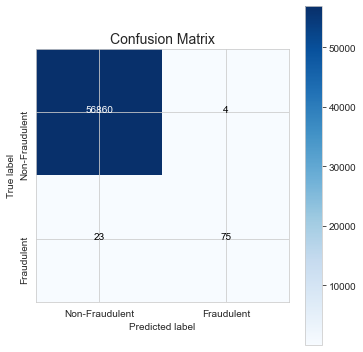

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.95      0.77      0.85        98

    accuracy                           1.00     56962
   macro avg       0.97      0.88      0.92     56962
weighted avg       1.00      1.00      1.00     56962

Optimal Threshold: 0.00029941503
ROC for test dataset 97.847%


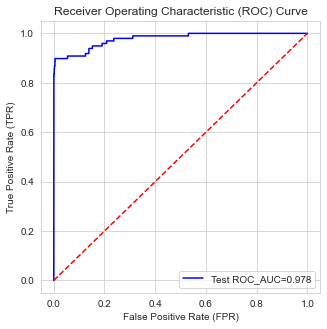


Time required to train the model: 31 minutes
****************************************************************************************************


In [ ]:
## XGBoost Model [Imbalanced Dataset]
results_df, clf_xgb_imbal_data = XGBoost_StratifiedKFoldCV_Model(None, X_train_pt_df, y_train, X_test_pt_df, y_test,
                         "Power Transformer (Imbalanced Dataset)", "XGBoost with StratifiedKFoldCV", results_df)

#### <font color=DarkBlue> **1.4 Random Forest Model (Imbalanced Dataset)**

****************************************************************************************************
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Data Handling Technique: Power Transformer (Imbalanced Dataset)
Model Name: Random Forest with StratifiedKFoldCV


Evaluation results from cross-validation and optimal hyperparameters
Best Estimator:
 RandomForestClassifier(criterion='entropy', max_depth=9, min_samples_leaf=2,
                       min_samples_split=5, n_estimators=700, n_jobs=-1,
                       random_state=0, warm_start=True)
Best ROC_AUC (mean cross-validated score): 0.9805393832284063
Best (Optimal) Parameters: {'randomforestclassifier__n_estimators': 700, 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__max_depth': 9, 'randomforestclassifier__criterion': 'entropy'}

Optimal hyperparameters:
Best number of trees: 700
Best min_sam

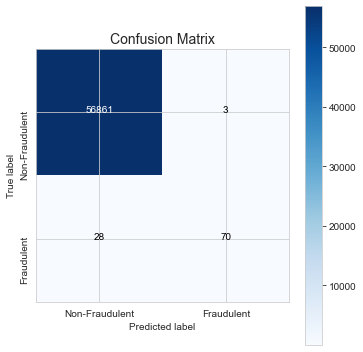

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.71      0.82        98

    accuracy                           1.00     56962
   macro avg       0.98      0.86      0.91     56962
weighted avg       1.00      1.00      1.00     56962

Optimal Threshold: 0.0025769135685187504
ROC for test dataset 98.173%


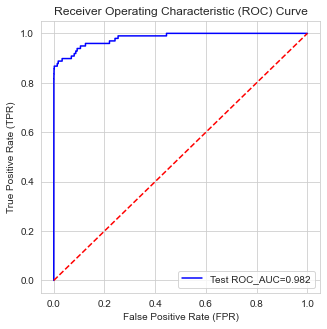


Time required to train the model: 128 minutes
****************************************************************************************************


In [ ]:
## Random Forest Model [Imbalanced Dataset]
results_df, clf_rfc_imbal_data = RandomForest_StratifiedKFoldCV_Model(None,None, X_train_pt, y_train, X_test_pt, y_test,
                         "Power Transformer (Imbalanced Dataset)", "Random Forest with StratifiedKFoldCV", results_df)

#### <font color=DarkBlue> **1.5 SVM Model (Imbalanced Dataset)**

****************************************************************************************************
Fitting 3 folds for each of 7 candidates, totalling 21 fits
[LibSVM]
Data Handling Technique: Power Transformer (Imbalanced Dataset)
Model Name: SVM with StratifiedKFoldCV


Evaluation results from cross-validation and optimal hyperparameters
Best Estimator:
 SVC(C=100.0, probability=True, random_state=0, verbose=True)
Best ROC_AUC (mean cross-validated score): 0.9646974091639565
Best (Optimal) Parameters: {'svc__C': 100.0}

Optimal hyperparameters:
Best C: 100.0

Prediction and Evaluation results: On Actual TEST SET

Test ROC_AUC: 0.9658619778806289
Test Accuracy: 0.9993679997191109

Confusion Matrix
 Model Stats Scores Summary : 


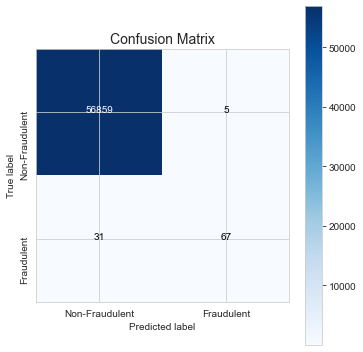

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.93      0.68      0.79        98

    accuracy                           1.00     56962
   macro avg       0.97      0.84      0.89     56962
weighted avg       1.00      1.00      1.00     56962

Optimal Threshold: 0.0062533841330037615
ROC for test dataset 96.586%


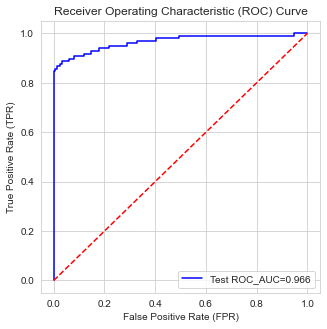


Time required to train the model: 125 minutes
****************************************************************************************************


In [ ]:
## SVM Model [Imbalanced Dataset]
results_df, clf_svm_imbal_data = SVM_StratifiedKFoldCV_Model(None, X_train_pt, y_train, X_test_pt, y_test,
                         "Power Transformer (Imbalanced Dataset)", "SVM with StratifiedKFoldCV", results_df)

#### <font color=DarkBlue> **1.6 KNN Model (Imbalanced Dataset)**

**Creating a stratified subset of train data using StratifiedShuffleSplit - (for KNN)**

In [ ]:
## Importing the split class
from sklearn.model_selection import StratifiedShuffleSplit

## Instantiating the class and splitting
## For creating a small stratified subset for training knn
split_knn= StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0)

## Creating a simple loop to create stratified sets
for train_index, test_index in split_knn.split(X_train_pt_df,y_train):
    X_train_split_knn, X_test_split_knn = X_train_pt_df.iloc[train_index], X_train_pt_df.iloc[test_index]
    y_train_split_knn, y_test_split_knn = y_train.iloc[train_index], y_train.iloc[test_index]

## Note: Since there are tens of throusands of samples,
## we will be using this stratified set for training (10% of actual train data) and then testing it on actual TEST data
X_train_knn= X_test_split_knn.copy()
y_train_knn= y_test_split_knn.copy()
print("Shape of X_train_knn:", X_train_knn.shape)
print("Shape of y_train_knn:", y_train_knn.shape)
print("\nChecking for stratified classes in y_train_knn (subset):", Counter(y_train_knn))

Shape of X_train_knn: (22785, 29)
Shape of y_train_knn: (22785,)

Checking for stratified classes in y_train_knn (subset): Counter({0: 22746, 1: 39})


**Perform StratifiedKFoldCV on X_train_knn and y_train_knn**

In [ ]:
## Let's perform StratifiedKFold strategy and check the results of folds (splits)
cv_num= 3               ## Number of cross-validation splits
skf = StratifiedKFold(n_splits=cv_num, random_state=0, shuffle=True)

for train_index, test_index in skf.split(X_train_knn,y_train_knn):   ## Note: using X_train_knn and y_train_knn here
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train_knn_cv, X_test_knn_cv = X_train_knn.iloc[train_index], X_train_knn.iloc[test_index]
    y_train_knn_cv, y_test_knn_cv = y_train_knn.iloc[train_index],  y_train_knn.iloc[test_index]

TRAIN: [    0     1     2 ... 22781 22782 22783] TEST: [    6    11    20 ... 22764 22771 22784]
TRAIN: [    0     2     6 ... 22779 22781 22784] TEST: [    1     3     4 ... 22780 22782 22783]
TRAIN: [    1     3     4 ... 22782 22783 22784] TEST: [    0     2     7 ... 22777 22779 22781]


*We will be performing cross-validation `using RandomizedSearchCV and passing model via 'imblearn pipeline'` as stated in the modeling approach `(which performs the StratifiedKFold cross-validation in a similar fashion as seen above).`*

****************************************************************************************************
Fitting 3 folds for each of 16 candidates, totalling 48 fits

Data Handling Technique: Power Transformer (Imbalanced Dataset)
Model Name: KNN with StratifiedKFoldCV


Evaluation results from cross-validation and optimal hyperparameters
Best Estimator:
 KNeighborsClassifier(n_jobs=-1, n_neighbors=27)
Best ROC_AUC (mean cross-validated score): 0.9482377290343527
Best (Optimal) Parameters: {'kneighborsclassifier__n_neighbors': 27}

Optimal hyperparameters:
Best n_neighbors (K): 27

Prediction and Evaluation results: On Actual TEST SET

Test ROC_AUC: 0.9279148315206781
Test Accuracy: 0.9989817773252344

Confusion Matrix
 Model Stats Scores Summary : 


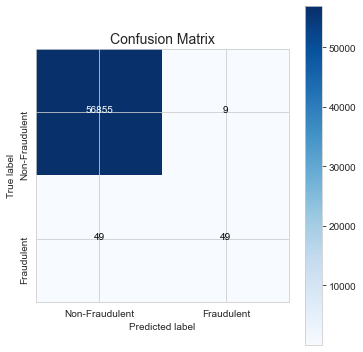

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.84      0.50      0.63        98

    accuracy                           1.00     56962
   macro avg       0.92      0.75      0.81     56962
weighted avg       1.00      1.00      1.00     56962

Optimal Threshold: 0.037037037037037035
ROC for test dataset 92.791%


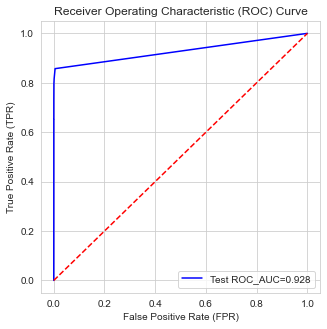


Time required to train the model: 12 minutes
****************************************************************************************************


In [ ]:
## KNN Model [Imbalanced Dataset]
results_df, clf_knn_imbal_data = KNN_StratifiedKFoldCV_Model(None, X_train_knn, y_train_knn, X_test_pt, y_test,
                         "Power Transformer (Imbalanced Dataset)", "KNN with StratifiedKFoldCV", results_df)

**Results from Model Building on Imbalanced dataset**

In [ ]:
## Results from model building on Imbalanced dataset
results_imbal_df= results_df.copy()
results_imbal_df

Data Handling Technique  \
0  Power Transformer (Imbalanced Dataset)   
1  Power Transformer (Imbalanced Dataset)   
2  Power Transformer (Imbalanced Dataset)   
3  Power Transformer (Imbalanced Dataset)   
4  Power Transformer (Imbalanced Dataset)   
5  Power Transformer (Imbalanced Dataset)   

                                        Model  ROC_AUC_cv  ROC_AUC_test  \
0  Logistic Regression with StratifiedKFoldCV    0.979647      0.975363   
1        Decision Tree with StratifiedKFoldCV    0.969650      0.952778   
2              XGBoost with StratifiedKFoldCV    0.979287      0.978473   
3        Random Forest with StratifiedKFoldCV    0.980539      0.981732   
4                  SVM with StratifiedKFoldCV    0.964697      0.965862   
5                  KNN with StratifiedKFoldCV    0.948238      0.927915   

   Threshold  Precision    Recall  F1 score  
0   0.004027   0.880597  0.602041  0.715152  
1   0.022727   0.884615  0.704082  0.784091  
2   0.000299   0.949367  0.765306  0.847458  
3   0.002577   0.958904  0.714286  0.818713  
4   0.006253   0.930556  0.683673  0.788235  
5   0.037037   0.844828  0.500000  0.628205

**Inference:**<br><br>
(i) `Random Forest with StratifiedKFoldCV` (Test AUC: 98.17%) and `XGBoost with StratifiedKFoldCV` (Test AUC: 97.85%) are `competitive models based on ROC_AUC_test`. `Precision-Recall curves (PR Curves and PR AUC) are recommended` for high class imbalance domains where ROC curves (and `ROC AUC) may provide an exessively optimistic view of performance`.<br><br>
(ii) Our `model evaluation criteria is to accurately identify the fraudulent transactions as fraudulent than the non-fradulent ones`. We don't want to label/predict a fraudulent transaction (True Positive) as non-fraudulent (False Negative). This is because the consequences will be far worse than a False Positive (incorrectly labelling a non-fraudulent transaction as fraudulent). `So, in addition, we would also focus on our recall score, PR-AUC (represents the minority samples better in imbalanced dataset) and F1 Score which keeps a balance between Precision and Recall.`<br><br>.

In [ ]:
## Function to calculate Precision-Recall AUC (PR_AUC)
def calc_print_PR_AUC(model_name,my_clf, y_true):
    y_pred_proba= my_clf.predict_proba(X_test_pt)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
    pr_auc= auc(recall, precision)
    print(f"PR_AUC ({model_name}) = ", pr_auc)
    return pr_auc

In [ ]:
## Also, checking Precision-Recall AUCs for all models as it is trained on imbalanced dataset

pr_auc_imbal_logreg= calc_print_PR_AUC("Logistic Regression [Imbalanced Dataset]", clf_lr_imbal_data, y_test)
pr_auc_imbal_dt= calc_print_PR_AUC("Decision Tree [Imbalanced Dataset]", clf_dt_imbal_data, y_test)
pr_auc_imbal_xgb= calc_print_PR_AUC("XGBoost [Imbalanced Dataset]", clf_xgb_imbal_data, y_test)
pr_auc_imbal_rfc= calc_print_PR_AUC("Random Forest [Imbalanced Dataset]", clf_rfc_imbal_data, y_test)
pr_auc_imbal_svm= calc_print_PR_AUC("SVM [Imbalanced Dataset]", clf_svm_imbal_data, y_test)
pr_auc_imbal_knn= calc_print_PR_AUC("KNN [Imbalanced Dataset]", clf_knn_imbal_data, y_test)

PR_AUC (Logistic Regression [Imbalanced Dataset]) =  0.7249803583919917
PR_AUC (Decision Tree [Imbalanced Dataset]) =  0.781075765464102
PR_AUC (XGBoost [Imbalanced Dataset]) =  0.8447407966020684
PR_AUC (Random Forest [Imbalanced Dataset]) =  0.8367611198988375
PR_AUC (SVM [Imbalanced Dataset]) =  0.806147023531516
PR_AUC (KNN [Imbalanced Dataset]) =  0.7151612375808872


**Observation:** <br>(i) `XGBoost shows a good ROC_AUC (97.847%)` along with best possible `Recall (76.53%)` and `F1-score (84.745%)`.<br>(ii) In `PR_AUC score evaluation`(for models built on imbalanced dataset), `XGBoost with StratifiedKFoldCV gives best performance (84.474% PR_AUC)`.


**<font color=purple>Best Model (Imbalanced Dataset)**<br><br>
Based on our analysis, **XGBoost with StratifiedKFold CV - (on Imbalanced Dataset)** gives the best overall results.

In [ ]:
# Best Model -- XGBoost with StratifiedKFold CV - (Imbalanced Dataset)

#initialise the model with optimum hyperparameters
clf = clf_xgb_imbal_data      # Best Model   (already obtained after fitting on X_train_pt and y_train)
#clf.fit(X_train_pt_df, y_train)

print('Train auc (mean cross-validation score) = ', results_imbal_df['ROC_AUC_cv'][2])
print('Train auc (best estimator) =', metrics.roc_auc_score(y_true= y_train, y_score= clf.predict_proba(X_train_pt)[:,1]));print()

# Evaluation results on test set
y_pred_best_imbal= clf.predict(X_test_pt_df)                                       # Find predicted values
y_pred_probs_best_imbal= clf.predict_proba(X_test_pt_df)[:,1]
print("Test auc (ROC_AUC)=", metrics.roc_auc_score(y_true= y_test, y_score= y_pred_probs_best_imbal))
fpr, tpr, thresholds = metrics.roc_curve(y_true= y_test, y_score= y_pred_probs_best_imbal)
threshold = thresholds[np.argmax(tpr-fpr)]
#Print threshold
print("Threshold =",threshold)
print("PR-AUC = ", pr_auc_imbal_xgb)
print("\nF1 Score:", metrics.f1_score(y_pred=y_pred_best_imbal, y_true=y_test))
print("Recall:", metrics.recall_score(y_pred=y_pred_best_imbal, y_true=y_test))
print("Precision:", metrics.precision_score(y_pred=y_pred_best_imbal, y_true=y_test))

Train auc (mean cross-validation score) =  0.979287134
Train auc (best estimator) = 1.0

Test auc (ROC_AUC)= 0.9784728044284681
Threshold = 0.00029941503
PR-AUC =  0.8447407966020684

F1 Score: 0.8474576271186441
Recall: 0.7653061224489796
Precision: 0.9493670886075949


In [ ]:
# Initialize the results_df to store new model results
results_df = pd.DataFrame(columns=['Data Handling Technique','Model', 'ROC_AUC_cv', 'ROC_AUC_test', 'Threshold', 'Precision','Recall','F1 score'])

### <font color=purple>Print the important features of the best model to understand the dataset

Top var = 17
2nd Top var = 14
3rd Top var = 10


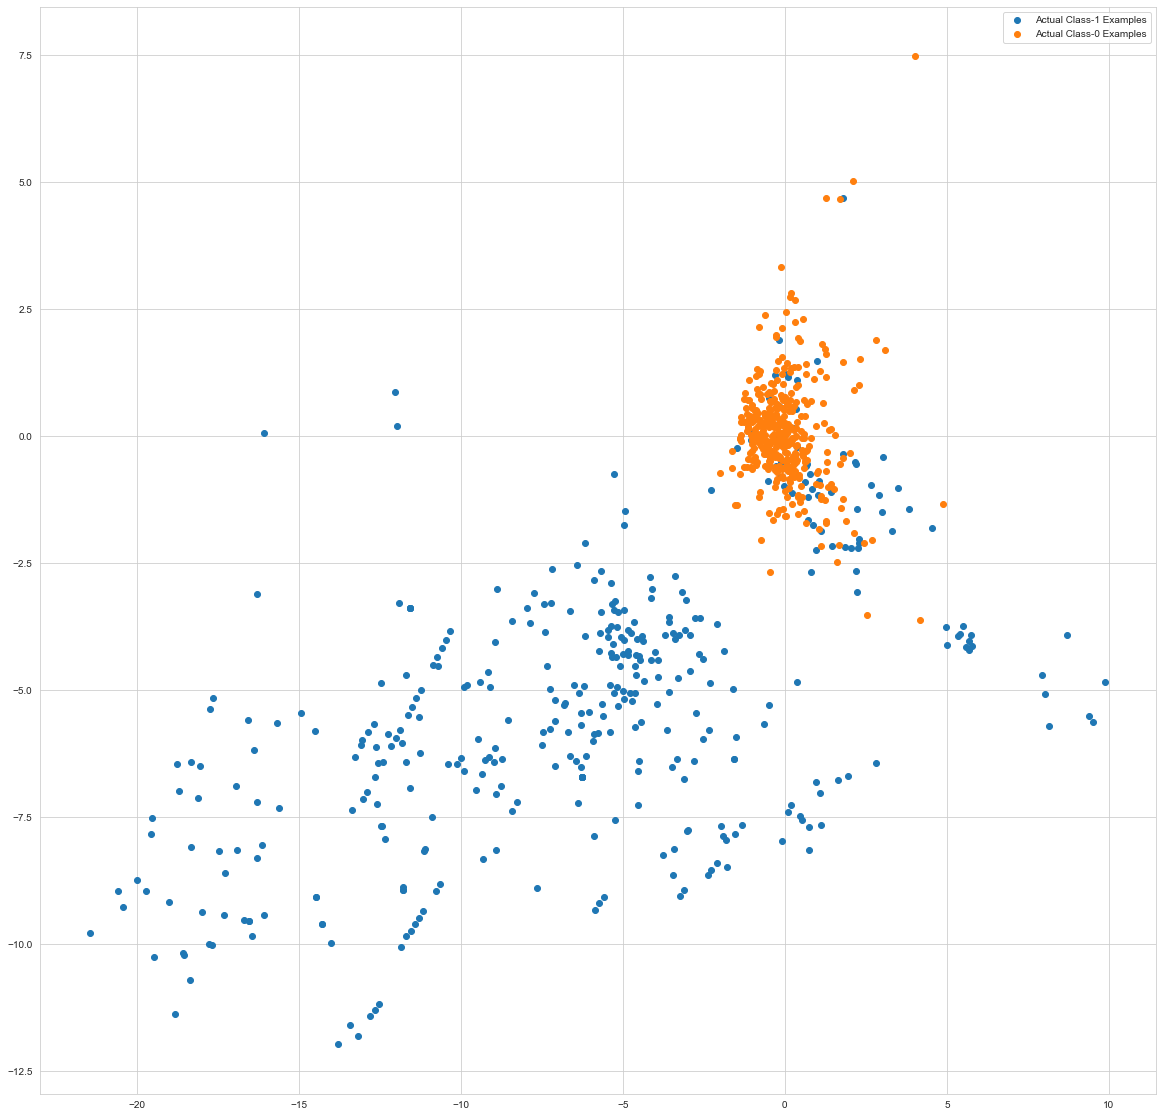

In [ ]:
## Defining a function for important features in the best model obtained on imbalanced datset
def imp_features_bestmodel_imbalanced_data(clf, X_train, y_train):
    var_imp = []
    for i in clf.feature_importances_:
        var_imp.append(i)
    print('Top var =', var_imp.index(np.sort(clf.feature_importances_)[-1])+1)
    print('2nd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-2])+1)
    print('3rd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-3])+1)

    # Variable on Index-16 and Index-13 seems to be the top 2 variables
    top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-1])
    second_top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-2])

    X_train_1 = X_train[np.where(y_train==1.0)]
    X_train_0 = X_train[np.where(y_train==0.0)]

    np.random.shuffle(X_train_0)

    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.rcParams['figure.figsize'] = [20, 20]

    plt.scatter(X_train_1[:, top_var_index], X_train_1[:, second_top_var_index], label='Actual Class-1 Examples')
    plt.scatter(X_train_0[:X_train_1.shape[0], top_var_index], X_train_0[:X_train_1.shape[0], second_top_var_index],
                label='Actual Class-0 Examples')
    plt.legend()
    plt.show()

## Important features of the best model (imbalanced dataset) - XGBoost with StratifiedKFold CV
imp_features_bestmodel_imbalanced_data(clf_xgb_imbal_data, X_train_pt, y_train)

**Observation:** We have successfully verified the `top 2 features` of the best model, namely variables `17` and `14` having `indices 16 and 13` respectively.

## <font color=Brown>Model building with Balancing Classes

##### Perform class balancing with :
- Random Oversampling
- SMOTE
- ADASYN

## <font color=green>**Model Building**
- Build different models on the balanced dataset and see the result

<font color=brown>**Important Note: For all Balanced Dataset models (Oversampling):**</font><br><br><font color=black>**We are using imblearn pipelines, so we shall ONLY pass 'over_sampling instance' along with normal 'TRAIN DATA' which would be oversampled within the pipeline. Advantage of pipelines is that oversampling happens ONLY within training folds during cross-validation and VALIDATION sets are NOT OVERSAMPLED. (Code explained clearly in model building functions.)**<br><br></font>
*Order: Performs oversampling-> Cross-validation (finding optimal hyperparameters) -> Selects Best Classifier/Estimator*

### <font color=brown>**Random Oversampling**

#### <font color=DarkBlue> **2.A Logistic Regression Model - (Sampling Technique - Random Oversampling) - [Balanced Dataset]**

*(Note: num_C and cv_num are defined in the function LogisticRegression_StratifiedKFoldCV_Model()* - (defined earlier)

#### perfom cross validation on the X_train & y_train to create:
- X_train_cv
- X_test_cv
- y_train_cv
- y_test_cv

**Perform StratifiedKFold Cross Validation on X_train (i.e. X_train_pt_df) and y_train**

In [ ]:
## Checking patterns of StratifiedKFold cross-validation (and oversampling training folds using RandomOverSampler)
cv_num= 3                 ## Number of cross-validation splits
skf = StratifiedKFold(n_splits=cv_num, random_state=0, shuffle=True)

for train_index, test_index in skf.split(X_train_pt_df,y_train):
    X_train_cv, X_test_cv = X_train_pt_df.iloc[train_index], X_train_pt_df.iloc[test_index]
    y_train_cv, y_test_cv = y_train.iloc[train_index],  y_train.iloc[test_index]
    print("TRAIN:", train_index, "TEST:", test_index)
    ros = over_sampling.RandomOverSampler(random_state=0)
    X_train_cv, y_train_cv = ros.fit_resample(X_train_cv, y_train_cv)

TRAIN: [     0      1      3 ... 227841 227842 227844] TEST: [     2      4      6 ... 227829 227836 227843]
TRAIN: [     1      2      3 ... 227842 227843 227844] TEST: [     0      9     12 ... 227837 227838 227841]
TRAIN: [     0      2      4 ... 227838 227841 227843] TEST: [     1      3      5 ... 227840 227842 227844]


*We will be performing cross-validation `using RandomizedSearchCV and passing model via 'imblearn pipeline'` as stated in the modeling approach (which performs `Randomoversampling and StratifiedKFold cross-validation in a similar fashion` as seen above).*

#### <font color=DarkBlue> **2.1 Logistic Regression Model - (Sampling Technique - Random Oversampling) - [Balanced Dataset]

****************************************************************************************************
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Data Handling Technique: Power Transformer (RandomOverSampler - Balanced Dataset)
Model Name: Logistic Regression with StratifiedKFoldCV


Evaluation results from cross-validation and optimal hyperparameters
Best Estimator:
 LogisticRegression(C=10000.0, max_iter=1000, n_jobs=-1, penalty='l1',
                   random_state=0, solver='liblinear')
Best ROC_AUC (mean cross-validated score): 0.9803063047320236
Best (Optimal) Parameters: {'logisticregression__solver': 'liblinear', 'logisticregression__penalty': 'l1', 'logisticregression__C': 10000.0}

Optimal hyperparameters:
Best C value: 10000.0
Best penalty: l1
Best solver: liblinear

Prediction and Evaluation results: On Actual TEST SET

Test ROC_AUC: 0.9763523674101042
Test Accuracy: 0.9747726554545135

Confusion Matrix
 Model Stats Scores Summary : 


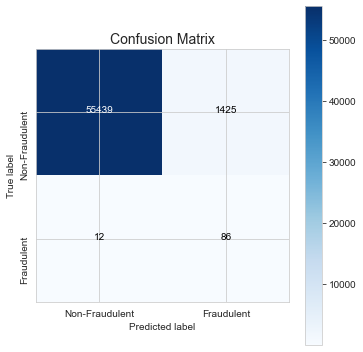

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.88      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.93      0.55     56962
weighted avg       1.00      0.97      0.99     56962

Optimal Threshold: 0.6666920984788242
ROC for test dataset 97.635%


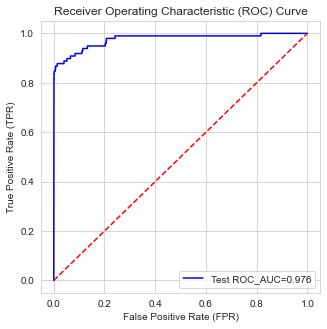


Time required to train the model: 1 minutes
****************************************************************************************************


In [ ]:
## LOGISTIC REGRESSION MODEL (RandomOverSampler) - BALANCED DATASET
ros = over_sampling.RandomOverSampler(random_state=0)                  # Creating a class instance of RandomOverSampler()
X_train_ros, y_train_ros = ros.fit_resample(X_train_pt, y_train)

# Building Model and Evaluating Results
results_df, clf_lr_randomoversampling_bal_data= LogisticRegression_StratifiedKFoldCV_Model(ros, X_train_pt,y_train,
                                     X_test_pt,y_test, "Power Transformer (RandomOverSampler - Balanced Dataset)",
                                        "Logistic Regression with StratifiedKFoldCV", results_df)

#### <font color=DarkBlue> **2.2 Decision Tree Model - (Sampling Technique - Random Oversampling) - [Balanced Dataset]**

****************************************************************************************************
Fitting 3 folds for each of 50 candidates, totalling 150 fits

Data Handling Technique: Power Transformer (RandomOverSampler- Balanced Dataset)
Model Name: Decision Tree with StratifiedKFoldCV


Evaluation results from cross-validation and optimal hyperparameters
Best Estimator:
 DecisionTreeClassifier(criterion='entropy', max_depth=4, max_features='sqrt',
                       min_samples_leaf=20, min_samples_split=50,
                       random_state=0)
Best ROC_AUC (mean cross-validated score): 0.9528699850686996
Best (Optimal) Parameters: {'decisiontreeclassifier__min_samples_split': 50, 'decisiontreeclassifier__min_samples_leaf': 20, 'decisiontreeclassifier__max_features': 'sqrt', 'decisiontreeclassifier__max_depth': 4, 'decisiontreeclassifier__criterion': 'entropy'}

Optimal hyperparameters:
Best min_samples_split: 50
Best min_samples_leaf: 20
Best max_features: sqrt
Best max_

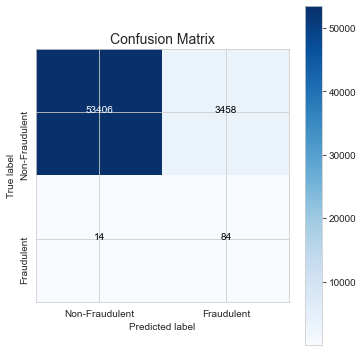

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     56864
           1       0.02      0.86      0.05        98

    accuracy                           0.94     56962
   macro avg       0.51      0.90      0.51     56962
weighted avg       1.00      0.94      0.97     56962

Optimal Threshold: 0.36720997123681687
ROC for test dataset 93.833%


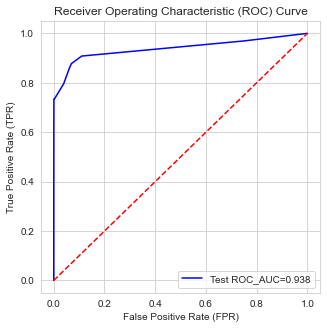


Time required to train the model: 2 minutes
****************************************************************************************************


In [ ]:
## Decision Tree Model (RandomOverSampler) - BALANCED DATASET
# Building Model and Evaluating Results
results_df, clf_dt_randomoversampling_bal_data = DecisionTree_StratifiedKFoldCV_Model(ros, X_train_pt, y_train,
                                            X_test_pt, y_test, "Power Transformer (RandomOverSampler- Balanced Dataset)",
                                                       "Decision Tree with StratifiedKFoldCV", results_df)

#### <font color=DarkBlue> **2.3 XGBoost Model - (Sampling Technique - Random Oversampling) - [Balanced Dataset]**

****************************************************************************************************
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Data Handling Technique: Power Transformer (RandomOverSampler- Balanced Dataset)
Model Name: XGBoost with StratifiedKFoldCV


Evaluation results from cross-validation and optimal hyperparameters
Best Estimator:
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=900, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0)
Best ROC_AUC (mean cross-validated score): 0.9785553

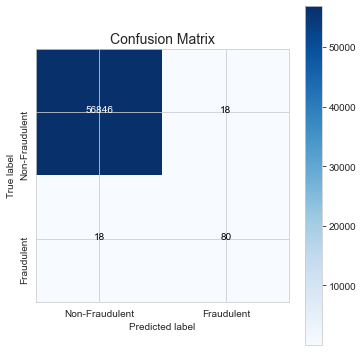

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.82      0.82      0.82        98

    accuracy                           1.00     56962
   macro avg       0.91      0.91      0.91     56962
weighted avg       1.00      1.00      1.00     56962

Optimal Threshold: 0.0037095132
ROC for test dataset 97.753%


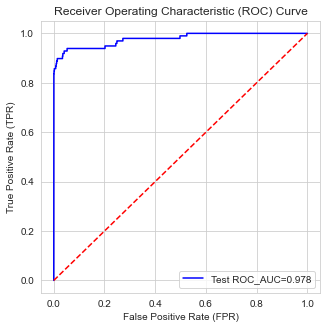


Time required to train the model: 67 minutes
****************************************************************************************************


In [ ]:
## XGBoost Model (RandomOverSampler) - BALANCED DATASET
# Building Model and Evaluating Results
results_df, clf_xgb_randomoversampling_bal_data = XGBoost_StratifiedKFoldCV_Model(ros,
                X_train_pt_df, y_train, X_test_pt_df, y_test, "Power Transformer (RandomOverSampler- Balanced Dataset)",
                                                                        "XGBoost with StratifiedKFoldCV", results_df)

#### <font color=DarkBlue> **2.4 Random Forest Model - (Sampling Technique - Random Oversampling) - [Balanced Dataset]**

****************************************************************************************************
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Data Handling Technique: Power Transformer (RandomOverSampler- Balanced Dataset)
Model Name: Random Forest with StratifiedKFoldCV


Evaluation results from cross-validation and optimal hyperparameters
Best Estimator:
 RandomForestClassifier(class_weight='balanced_subsample', max_depth=7,
                       max_features='log2', min_samples_leaf=4,
                       min_samples_split=5, n_estimators=300, n_jobs=-1,
                       random_state=0, warm_start=True)
Best ROC_AUC (mean cross-validated score): 0.9806380984170775
Best (Optimal) Parameters: {'randomforestclassifier__n_estimators': 300, 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__min_samples_leaf': 4, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__max_depth': 7, 'randomforestclassifier__criterion': 

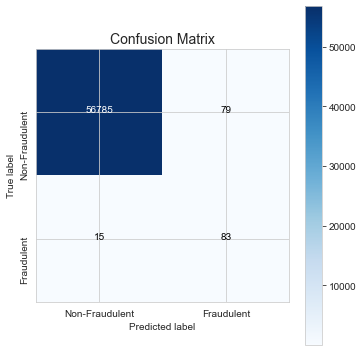

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.51      0.85      0.64        98

    accuracy                           1.00     56962
   macro avg       0.76      0.92      0.82     56962
weighted avg       1.00      1.00      1.00     56962

Optimal Threshold: 0.15413982951733995
ROC for test dataset 98.21%


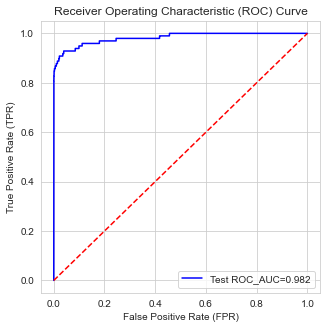


Time required to train the model: 221 minutes
****************************************************************************************************


In [ ]:
## Random Forest Model (RandomOverSampler) - BALANCED DATASET
# Building Model and Evaluating Results
results_df, clf_rfc_randomoversampling_bal_data = RandomForest_StratifiedKFoldCV_Model(ros,"balanced_subsample",
                                                                        X_train_pt, y_train, X_test_pt, y_test,
     "Power Transformer (RandomOverSampler- Balanced Dataset)", "Random Forest with StratifiedKFoldCV", results_df)

#### <font color=DarkBlue> **2.5 SVM Model - (Sampling Technique - Random Oversampling) - [Balanced Dataset]**

**Creating a stratified subset of the training data using StratifiedShuffleSplit - (for SVM oversampling cases)**

In [ ]:
## Importing the split class
from sklearn.model_selection import StratifiedShuffleSplit

## Instantiating the class and splitting
## For creating a small stratified subset for training svm
split_svm= StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=0)

## Creating a simple loop to create stratified sets
for train_index, test_index in split_svm.split(X_train_pt_df,y_train):
    X_train_split_svm, X_test_split_svm = X_train_pt_df.iloc[train_index], X_train_pt_df.iloc[test_index]
    y_train_split_svm, y_test_split_svm = y_train.iloc[train_index], y_train.iloc[test_index]

## Note: Since there are tens of throusands of samples,
## we will be using this stratified set for training (25% of train data) and then testing it on actual TEST data
X_train_svm= X_test_split_svm.copy()
y_train_svm= y_test_split_svm.copy()
print("Shape of X_train_svm:", X_train_svm.shape)
print("Shape of y_train_svm:", y_train_svm.shape)
print("Checking stratified classes in y_train:", Counter(y_train_svm))

Shape of X_train_svm: (56962, 29)
Shape of y_train_svm: (56962,)
Checking stratified classes in y_train: Counter({0: 56863, 1: 99})


**Perform StratifiedKFoldCV on the X_train_svm and y_train_svm**

In [ ]:
## Checking patterns of StratifiedKFold cross-validation (and oversampling training folds using RandomOverSampler) - SVM
cv_num= 3               ## Number of cross-validation splits
skf = StratifiedKFold(n_splits=cv_num, random_state=0, shuffle=True)

for train_index, test_index in skf.split(X_train_svm,y_train_svm):   ## Note: using X_train_svm and y_train_svm here
    X_train_svm_cv, X_test_svm_cv = X_train_svm.iloc[train_index], X_train_svm.iloc[test_index]
    y_train_svm_cv, y_test_svm_cv = y_train_svm.iloc[train_index],  y_train_svm.iloc[test_index]
    print("TRAIN:", train_index, "TEST:", test_index)
    ros = over_sampling.RandomOverSampler(random_state=0)
    X_train_svm_cv, y_train_svm_cv = ros.fit_resample(X_train_svm_cv, y_train_svm_cv)

TRAIN: [    2     3     4 ... 56958 56959 56960] TEST: [    0     1    11 ... 56948 56949 56961]
TRAIN: [    0     1     3 ... 56959 56960 56961] TEST: [    2     4     5 ... 56954 56955 56956]
TRAIN: [    0     1     2 ... 56955 56956 56961] TEST: [    3     6     8 ... 56958 56959 56960]


*We will be performing cross-validation `using RandomizedSearchCV and passing model via 'imblearn pipeline'`  as stated in the modeling approach (which performs `Randomoversampling and StratifiedKFold cross-validation in a similar fashion` as seen above).*

****************************************************************************************************
Fitting 3 folds for each of 7 candidates, totalling 21 fits
[LibSVM]
Data Handling Technique: Power Transformer (RandomOverSampler- Balanced Dataset)
Model Name: SVM with StratifiedKFoldCV


Evaluation results from cross-validation and optimal hyperparameters
Best Estimator:
 SVC(C=0.01, probability=True, random_state=0, verbose=True)
Best ROC_AUC (mean cross-validated score): 0.9905878116665416
Best (Optimal) Parameters: {'svc__C': 0.01}

Optimal hyperparameters:
Best C: 0.01

Prediction and Evaluation results: On Actual TEST SET

Test ROC_AUC: 0.9664301074960091
Test Accuracy: 0.990642884730171

Confusion Matrix
 Model Stats Scores Summary : 


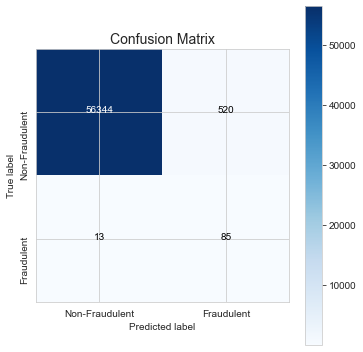

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.14      0.87      0.24        98

    accuracy                           0.99     56962
   macro avg       0.57      0.93      0.62     56962
weighted avg       1.00      0.99      0.99     56962

Optimal Threshold: 0.7986874885624717
ROC for test dataset 96.643%


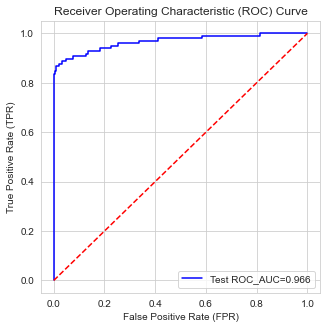


Time required to train the model: 115 minutes
****************************************************************************************************


In [ ]:
## SVM Model Model (RandomOverSampler) - BALANCED DATASET
ros = over_sampling.RandomOverSampler(random_state=0)                # Creating a class instance of RandomOverSampler()
X_train_ros_svm, y_train_ros_svm = ros.fit_resample(X_train_svm, y_train_svm)

# Building Model and Evaluating Results
results_df, clf_svm_randomoversampling_bal_data = SVM_StratifiedKFoldCV_Model(ros, X_train_svm, y_train_svm,
                                            X_test_pt, y_test, "Power Transformer (RandomOverSampler- Balanced Dataset)",
                                                                        "SVM with StratifiedKFoldCV", results_df)

#### <font color=DarkBlue> **2.6 KNN Model - (Sampling Technique - Random Oversampling) --- [Balanced Dataset]**

Using the stratified subset of the training data obtained earlier

**Perform StratifiedKFoldCV on X_train_knn and y_train_knn**

In [ ]:
## Checking patterns of StratifiedKFold cross-validation (and oversampling training folds using RandomOverSampler) - KNN
cv_num= 3               ## Number of cross-validation splits
skf = StratifiedKFold(n_splits=cv_num, random_state=0, shuffle=True)

for train_index, test_index in skf.split(X_train_knn,y_train_knn):   ## Note: using X_train_knn and y_train_knn here
    X_train_knn_cv, X_test_knn_cv = X_train_knn.iloc[train_index], X_train_knn.iloc[test_index]
    y_train_knn_cv, y_test_knn_cv = y_train_knn.iloc[train_index],  y_train_knn.iloc[test_index]
    print("TRAIN:", train_index, "TEST:", test_index)
    ros = over_sampling.RandomOverSampler(random_state=0)
    X_train_knn_cv, y_train_knn_cv = ros.fit_resample(X_train_knn_cv, y_train_knn_cv)

TRAIN: [    0     1     2 ... 22781 22782 22783] TEST: [    6    11    20 ... 22764 22771 22784]
TRAIN: [    0     2     6 ... 22779 22781 22784] TEST: [    1     3     4 ... 22780 22782 22783]
TRAIN: [    1     3     4 ... 22782 22783 22784] TEST: [    0     2     7 ... 22777 22779 22781]


*We will be performing cross-validation `using RandomizedSearchCV and passing model via 'imblearn pipeline'`  as stated in the modeling approach (which performs `Randomoversampling and StratifiedKFold cross-validation in a similar fashion` as seen above).*

In [ ]:
print(X_train_knn.shape)
print(y_train_knn.shape)
print(Counter(y_train_knn))

(22785, 29)
(22785,)
Counter({0: 22746, 1: 39})


****************************************************************************************************
Fitting 3 folds for each of 16 candidates, totalling 48 fits

Data Handling Technique: Power Transformer (RandomOverSampler- Balanced Dataset)
Model Name: KNN with StratifiedKFoldCV


Evaluation results from cross-validation and optimal hyperparameters
Best Estimator:
 KNeighborsClassifier(n_jobs=-1, n_neighbors=27)
Best ROC_AUC (mean cross-validated score): 0.9484237296160272
Best (Optimal) Parameters: {'kneighborsclassifier__n_neighbors': 27}

Optimal hyperparameters:
Best n_neighbors (K): 27

Prediction and Evaluation results: On Actual TEST SET

Test ROC_AUC: 0.9279711779196766
Test Accuracy: 0.9970857764825674

Confusion Matrix
 Model Stats Scores Summary : 


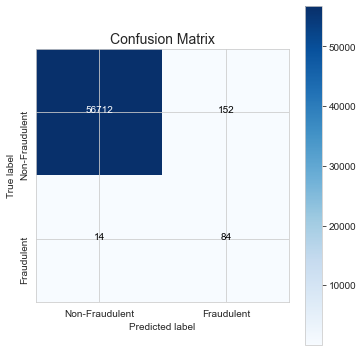

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.36      0.86      0.50        98

    accuracy                           1.00     56962
   macro avg       0.68      0.93      0.75     56962
weighted avg       1.00      1.00      1.00     56962

Optimal Threshold: 0.7407407407407407
ROC for test dataset 92.797%


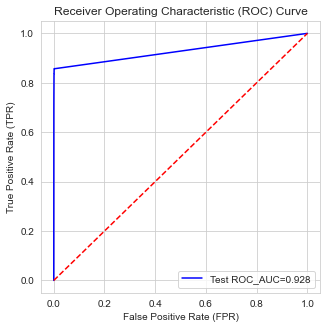


Time required to train the model: 23 minutes
****************************************************************************************************


In [ ]:
## KNN Model (RandomOverSampler) - BALANCED DATASET
ros = over_sampling.RandomOverSampler(random_state=0)                   # Creating a class instance of RandomOverSampler()
X_train_ros_knn, y_train_ros_knn = ros.fit_resample(X_train_knn, y_train_knn)

## Building model and evaluation results
results_df, clf_knn_randomoversampling_bal_data = KNN_StratifiedKFoldCV_Model(ros, X_train_knn, y_train_knn,
                                  X_test_pt, y_test, "Power Transformer (RandomOverSampler- Balanced Dataset)",
                                                                "KNN with StratifiedKFoldCV", results_df)

**Results from Model Building on (Randomoversampling) Balanced Dataset**

In [ ]:
## Results from modeling on (Randomoversampling) balanced dataset
results_ros_bal_df= results_df.copy()
results_ros_bal_df

Data Handling Technique  \
0  Power Transformer (RandomOverSampler - Balanced Dataset)   
1   Power Transformer (RandomOverSampler- Balanced Dataset)   
2   Power Transformer (RandomOverSampler- Balanced Dataset)   
3   Power Transformer (RandomOverSampler- Balanced Dataset)   
4   Power Transformer (RandomOverSampler- Balanced Dataset)   
5   Power Transformer (RandomOverSampler- Balanced Dataset)   

                                        Model  ROC_AUC_cv  ROC_AUC_test  \
0  Logistic Regression with StratifiedKFoldCV    0.980306      0.976352   
1        Decision Tree with StratifiedKFoldCV    0.952870      0.938331   
2              XGBoost with StratifiedKFoldCV    0.978555      0.977530   
3        Random Forest with StratifiedKFoldCV    0.980638      0.982096   
4                  SVM with StratifiedKFoldCV    0.990588      0.966430   
5                  KNN with StratifiedKFoldCV    0.948424      0.927971   

   Threshold  Precision    Recall  F1 score  
0   0.666692   0.056916  0.877551  0.106899  
1   0.367210   0.023715  0.857143  0.046154  
2   0.003710   0.816327  0.816327  0.816327  
3   0.154140   0.512346  0.846939  0.638462  
4   0.798687   0.140496  0.867347  0.241821  
5   0.740741   0.355932  0.857143  0.502994

**<font color=purple>Better performing model on Balanced Dataset (RandomOversampling):**<br><br>
**Observations:**
1. `ROC_AUC` seems to be a `better evaluation metric` in case of `models trained on balanced classes as it is able to clearly distinguish between the classes`. <br>
2. Among Randomoversampling models, **Random Forest with StratifiedKFoldCV [Randomversampling - Balanced Dataset]** seems to give best overall results - `Test AUC (98.2096%)` along with a `high recall score (84.694%)`.

In [ ]:
# Initialize the results_df to store new model results
results_df = pd.DataFrame(columns=['Data Handling Technique','Model', 'ROC_AUC_cv', 'ROC_AUC_test', 'Threshold', 'Precision','Recall','F1 score'])

### <font color=brown>**SMOTE**

#### <font color=DarkBlue> **3.A Logistic Regression Model - (Sampling Technique - SMOTE) --- [Balanced Dataset]**

*(Note: num_C and cv_num are defined in the function LogisticRegression_StratifiedKFoldCV_Model()* - (defined earlier)

#### perfom cross validation on the X_train & y_train to create:
- X_train_cv
- X_test_cv
- y_train_cv
- y_test_cv

**Perform StratifiedKFoldCV on the X_train_pt and y_train**

In [ ]:
## Checking patterns of StratifiedKFold cross-validation (and oversampling training folds using SMOTE)
cv_num= 3                ## Number of cross-validation splits
skf = StratifiedKFold(n_splits=cv_num, random_state=0, shuffle=True)

for train_index, test_index in skf.split(X_train_pt_df,y_train):
    X_train_cv, X_test_cv = X_train_pt_df.iloc[train_index], X_train_pt_df.iloc[test_index]
    y_train_cv, y_test_cv = y_train.iloc[train_index],  y_train.iloc[test_index]
    print("TRAIN:", train_index, "TEST:", test_index)
    sm = over_sampling.SMOTE(random_state=0)
    X_train_cv, y_train_cv = sm.fit_resample(X_train_cv, y_train_cv)

TRAIN: [     0      1      3 ... 227841 227842 227844] TEST: [     2      4      6 ... 227829 227836 227843]
TRAIN: [     1      2      3 ... 227842 227843 227844] TEST: [     0      9     12 ... 227837 227838 227841]
TRAIN: [     0      2      4 ... 227838 227841 227843] TEST: [     1      3      5 ... 227840 227842 227844]


*We will be performing cross-validation `using RandomizedSearchCV and passing model via 'imblearn pipeline'`  as stated in the modeling approach (which performs `SMOTE and StratifiedKFold cross-validation in a similar fashion` as seen above).*

### <font color=purple> Print the class distribution after applying SMOTE

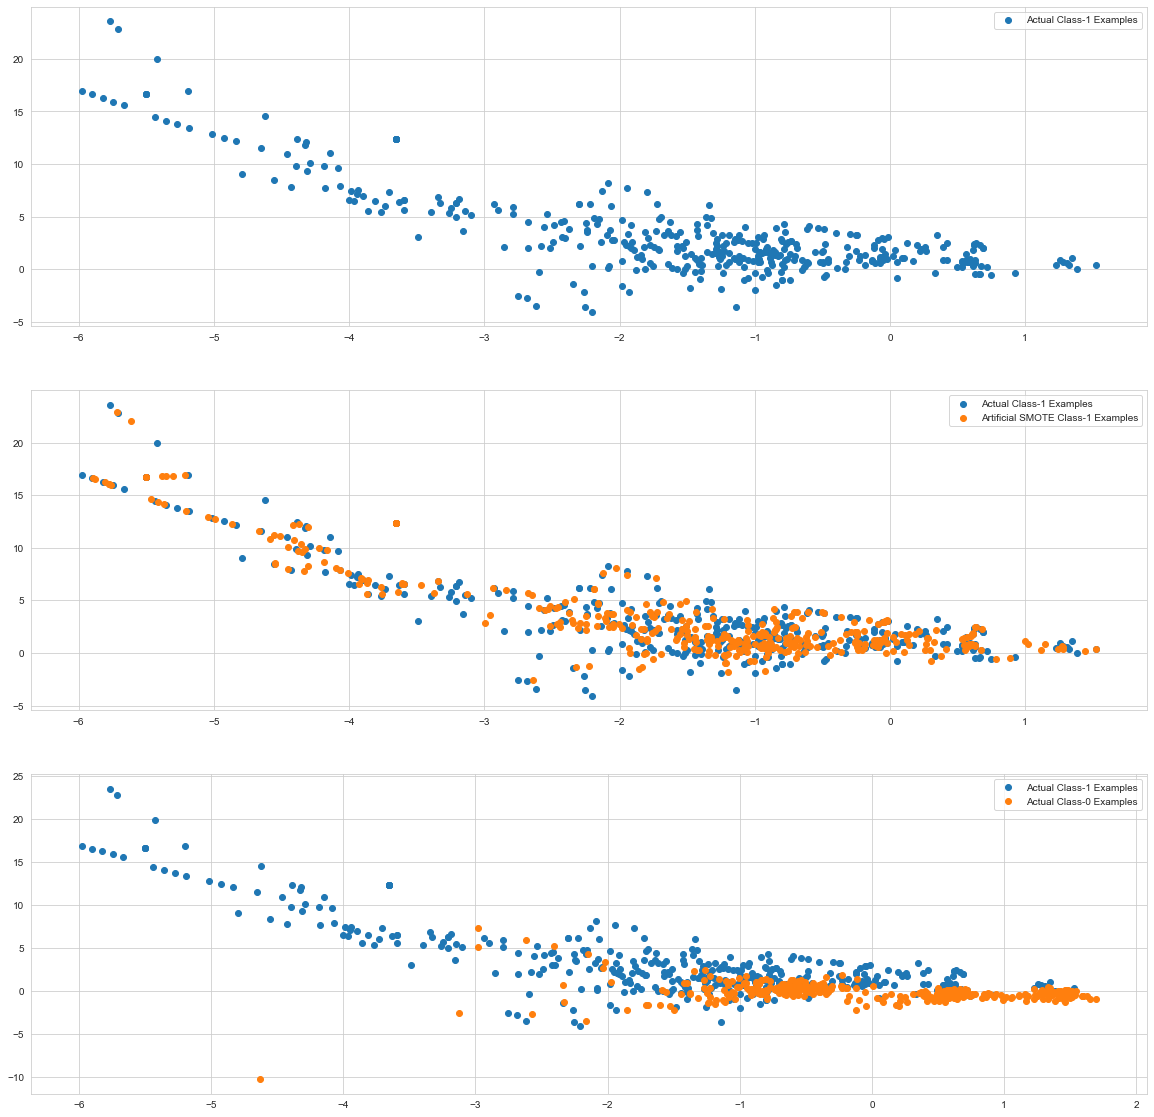

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Creating a function to print class distribution after applying SMOTE
def class_distribution_after_smote(X_train, y_train):
    sm = over_sampling.SMOTE(random_state=0)
    X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)
    # Artificial minority samples and corresponding minority labels from SMOTE are appended
    # below X_train and y_train respectively
    # So to exclusively get the artificial minority samples from SMOTE, we do
    X_train_smote_1 = X_train_smote[X_train.shape[0]:]

    X_train_1 = X_train[np.where(y_train==1.0)]
    X_train_0 = X_train[np.where(y_train==0.0)]


    plt.rcParams['figure.figsize'] = [20, 20]
    fig = plt.figure()

    plt.subplot(3, 1, 1)
    plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
    plt.scatter(X_train_smote_1[:X_train_1.shape[0], 0], X_train_smote_1[:X_train_1.shape[0], 1],
                label='Artificial SMOTE Class-1 Examples')
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
    plt.scatter(X_train_0[:X_train_1.shape[0], 0], X_train_0[:X_train_1.shape[0], 1], label='Actual Class-0 Examples')
    plt.legend()
    plt.show()

## Print class distribution after SMOTE
class_distribution_after_smote(X_train_pt, y_train)

#### <font color=DarkBlue> **3.1 Logistic Regression Model - (Sampling Technique - SMOTE) - [Balanced Dataset]**

****************************************************************************************************
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Data Handling Technique: Power Transformer (SMOTE - Balanced Dataset)
Model Name: Logistic Regression with StratifiedKFoldCV


Evaluation results from cross-validation and optimal hyperparameters
Best Estimator:
 LogisticRegression(C=0.01, max_iter=1000, n_jobs=-1, random_state=0)
Best ROC_AUC (mean cross-validated score): 0.9798592739580264
Best (Optimal) Parameters: {'logisticregression__solver': 'lbfgs', 'logisticregression__penalty': 'l2', 'logisticregression__C': 0.01}

Optimal hyperparameters:
Best C value: 0.01
Best penalty: l2
Best solver: lbfgs

Prediction and Evaluation results: On Actual TEST SET

Test ROC_AUC: 0.9769533358503785
Test Accuracy: 0.9728064323584144

Confusion Matrix
 Model Stats Scores Summary : 


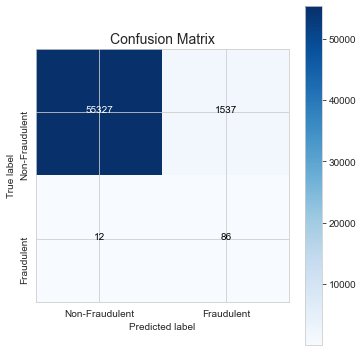

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.05      0.88      0.10        98

    accuracy                           0.97     56962
   macro avg       0.53      0.93      0.54     56962
weighted avg       1.00      0.97      0.98     56962

Optimal Threshold: 0.7559869907893713
ROC for test dataset 97.695%


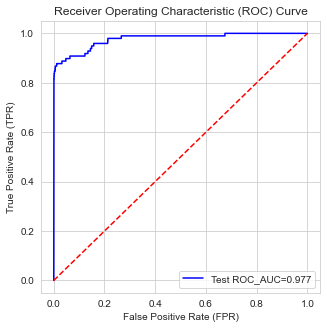


Time required to train the model: 2 minutes
****************************************************************************************************


In [ ]:
## LOGISTIC REGRESSION MODEL (SMOTE) - BALANCED DATASET
sm = over_sampling.SMOTE(random_state=0)                                    # Creating a class instance of SMOTE()
X_train_sm, y_train_sm = sm.fit_resample(X_train_pt, y_train)

# Building Model and Evaluating Results
results_df, clf_lr_smote_bal_data= LogisticRegression_StratifiedKFoldCV_Model(sm,  X_train_pt,y_train, X_test_pt, y_test,
       "Power Transformer (SMOTE - Balanced Dataset)", "Logistic Regression with StratifiedKFoldCV", results_df)

#### <font color=DarkBlue> **3.2 Decision Tree Model - (Sampling Technique - SMOTE) - [Balanced Dataset]**

****************************************************************************************************
Fitting 3 folds for each of 50 candidates, totalling 150 fits

Data Handling Technique: Power Transformer (SMOTE - Balanced Dataset)
Model Name: Decision Tree with StratifiedKFoldCV


Evaluation results from cross-validation and optimal hyperparameters
Best Estimator:
 DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=20,
                       min_samples_split=30, random_state=0)
Best ROC_AUC (mean cross-validated score): 0.9512145469531358
Best (Optimal) Parameters: {'decisiontreeclassifier__min_samples_split': 30, 'decisiontreeclassifier__min_samples_leaf': 20, 'decisiontreeclassifier__max_features': None, 'decisiontreeclassifier__max_depth': 3, 'decisiontreeclassifier__criterion': 'entropy'}

Optimal hyperparameters:
Best min_samples_split: 30
Best min_samples_leaf: 20
Best max_features: None
Best max_depth: 3
Best criterion: entropy

Prediction and Evaluati

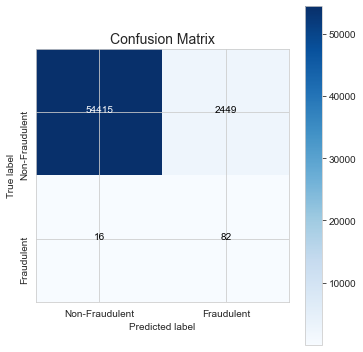

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56864
           1       0.03      0.84      0.06        98

    accuracy                           0.96     56962
   macro avg       0.52      0.90      0.52     56962
weighted avg       1.00      0.96      0.98     56962

Optimal Threshold: 0.27289719626168224
ROC for test dataset 94.722%


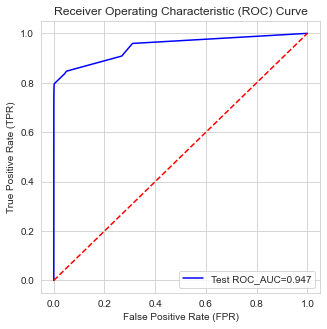


Time required to train the model: 5 minutes
****************************************************************************************************


In [ ]:
## Decision Tree Model (SMOTE) - BALANCED DATASET

# Building Model and Evaluating Results
results_df, clf_dt_smote_bal_data = DecisionTree_StratifiedKFoldCV_Model(sm, X_train_pt, y_train, X_test_pt, y_test,
             "Power Transformer (SMOTE - Balanced Dataset)", "Decision Tree with StratifiedKFoldCV", results_df)

#### <font color=DarkBlue> **3.3 XGBoost Model - (Sampling Technique - SMOTE) - [Balanced Dataset]**

****************************************************************************************************
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Data Handling Technique: Power Transformer (SMOTE - Balanced Dataset)
Model Name: XGBoost with StratifiedKFoldCV


Evaluation results from cross-validation and optimal hyperparameters
Best Estimator:
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=700, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0)
Best ROC_AUC (mean cross-validated score): 0.9769952385735398
Be

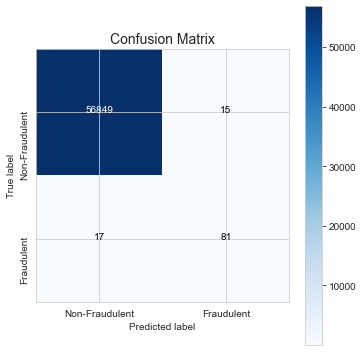

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.84      0.83      0.84        98

    accuracy                           1.00     56962
   macro avg       0.92      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962

Optimal Threshold: 2.1345155e-05
ROC for test dataset 98.841%


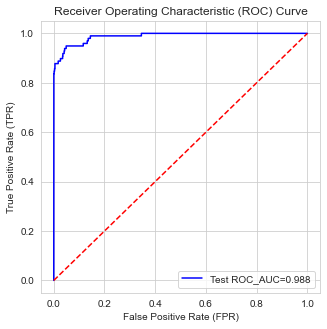


Time required to train the model: 122 minutes
****************************************************************************************************


In [ ]:
## XGBoost Model (SMOTE) - BALANCED DATASET

# Building Model and Evaluating Results
results_df, clf_xgb_smote_bal_data = XGBoost_StratifiedKFoldCV_Model(sm, X_train_pt_df, y_train, X_test_pt_df, y_test,
                  "Power Transformer (SMOTE - Balanced Dataset)", "XGBoost with StratifiedKFoldCV", results_df)

#### <font color=DarkBlue> **3.4 Random Forest Model - (Sampling Technique - SMOTE) - [Balanced Dataset]**

****************************************************************************************************
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Data Handling Technique: Power Transformer (SMOTE - Balanced Dataset)
Model Name: Random Forest with StratifiedKFoldCV


Evaluation results from cross-validation and optimal hyperparameters
Best Estimator:
 RandomForestClassifier(class_weight='balanced_subsample', max_depth=7,
                       max_features='log2', min_samples_leaf=4,
                       min_samples_split=5, n_estimators=300, n_jobs=-1,
                       random_state=0, warm_start=True)
Best ROC_AUC (mean cross-validated score): 0.9816612314949009
Best (Optimal) Parameters: {'randomforestclassifier__n_estimators': 300, 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__min_samples_leaf': 4, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__max_depth': 7, 'randomforestclassifier__criterion': 'gini'}

Op

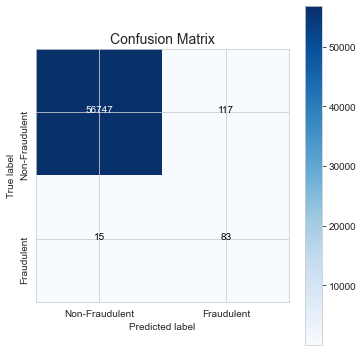

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.41      0.85      0.56        98

    accuracy                           1.00     56962
   macro avg       0.71      0.92      0.78     56962
weighted avg       1.00      1.00      1.00     56962

Optimal Threshold: 0.27530287932436026
ROC for test dataset 98.538%


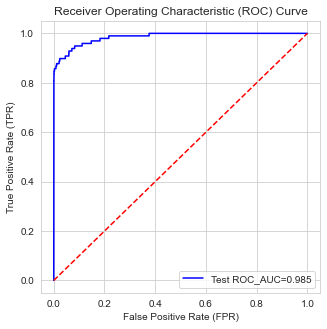


Time required to train the model: 378 minutes
****************************************************************************************************


In [ ]:
## Random Forest Model (SMOTE) - BALANCED DATASET

# Building Model and Evaluating Results
results_df, clf_rfc_smote_bal_data = RandomForest_StratifiedKFoldCV_Model(sm,"balanced_subsample",
                                                                        X_train_pt, y_train, X_test_pt, y_test,
              "Power Transformer (SMOTE - Balanced Dataset)", "Random Forest with StratifiedKFoldCV", results_df)

#### <font color=DarkBlue> **3.5 SVM Model - (Sampling Technique - SMOTE) - [Balanced Dataset]**

Using the stratified subset of training data obtained earlier

**Perform StratifiedKFoldCV on the X_train_svm and y_train_svm**

In [ ]:
## Checking patterns of StratifiedKFold cross-validation (and oversampling training folds using SMOTE) - SVM
cv_num= 3              ## Number of cross-validation splits
skf = StratifiedKFold(n_splits=cv_num, random_state=0, shuffle=True)

for train_index, test_index in skf.split(X_train_svm,y_train_svm):
    X_train_svm_cv, X_test_svm_cv = X_train_svm.iloc[train_index], X_train_svm.iloc[test_index]
    y_train_svm_cv, y_test_svm_cv = y_train_svm.iloc[train_index],  y_train_svm.iloc[test_index]
    print("TRAIN:", train_index, "TEST:", test_index)
    sm = over_sampling.SMOTE(random_state=0)
    X_train_svm_cv, y_train_svm_cv = sm.fit_resample(X_train_svm_cv, y_train_svm_cv)

TRAIN: [    2     3     4 ... 56958 56959 56960] TEST: [    0     1    11 ... 56948 56949 56961]
TRAIN: [    0     1     3 ... 56959 56960 56961] TEST: [    2     4     5 ... 56954 56955 56956]
TRAIN: [    0     1     2 ... 56955 56956 56961] TEST: [    3     6     8 ... 56958 56959 56960]


*We will be performing cross-validation `using RandomizedSearchCV and passing model via 'imblearn pipeline'`  as stated in the modeling approach (which performs `SMOTE and StratifiedKFold cross-validation in a similar fashion` as seen above).*

****************************************************************************************************
Fitting 3 folds for each of 7 candidates, totalling 21 fits
[LibSVM]
Data Handling Technique: Power Transformer (SMOTE - Balanced Dataset)
Model Name: SVM with StratifiedKFoldCV


Evaluation results from cross-validation and optimal hyperparameters
Best Estimator:
 SVC(C=0.01, probability=True, random_state=0, verbose=True)
Best ROC_AUC (mean cross-validated score): 0.990154568012132
Best (Optimal) Parameters: {'svc__C': 0.01}

Optimal hyperparameters:
Best C: 0.01

Prediction and Evaluation results: On Actual TEST SET

Test ROC_AUC: 0.9640606875839812
Test Accuracy: 0.9906779958568871

Confusion Matrix
 Model Stats Scores Summary : 


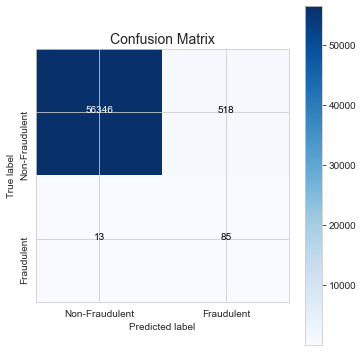

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.14      0.87      0.24        98

    accuracy                           0.99     56962
   macro avg       0.57      0.93      0.62     56962
weighted avg       1.00      0.99      0.99     56962

Optimal Threshold: 0.7110091234161533
ROC for test dataset 96.406%


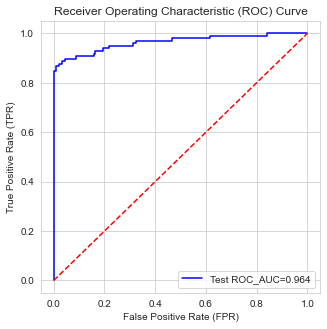


Time required to train the model: 113 minutes
****************************************************************************************************


In [ ]:
## SVM Model (SMOTE) - BALANCED DATASET
sm = over_sampling.SMOTE(random_state=0)                                  # Creating an instance of SMOTE()
X_train_smote_svm, y_train_smote_svm = sm.fit_resample(X_train_svm, y_train_svm)

# Building Model and Evaluating Results
results_df, clf_svm_smote_bal_data= SVM_StratifiedKFoldCV_Model(sm, X_train_svm, y_train_svm, X_test_pt, y_test,
                                "Power Transformer (SMOTE - Balanced Dataset)","SVM with StratifiedKFoldCV", results_df)

#### <font color=DarkBlue> **3.6 KNN Model - (Sampling Technique - SMOTE) - [Balanced Dataset]**

Using the stratified subset of training data obtained earlier

**Perform StratifiedKFoldCV on X_train_knn and y_train_knn**

In [ ]:
## Checking patterns of StratifiedKFold cross-validation (and oversampling training folds using SMOTE) - KNN
cv_num= 3              ## Number of cross-validation splits
skf = StratifiedKFold(n_splits=cv_num, random_state=0, shuffle=True)

for train_index, test_index in skf.split(X_train_knn,y_train_knn):
    X_train_knn_cv, X_test_knn_cv = X_train_knn.iloc[train_index], X_train_knn.iloc[test_index]
    y_train_knn_cv, y_test_knn_cv = y_train_knn.iloc[train_index],  y_train_knn.iloc[test_index]
    print("TRAIN:", train_index, "TEST:", test_index)
    sm = over_sampling.SMOTE(random_state=0)
    X_train_knn_cv, y_train_knn_cv = sm.fit_resample(X_train_knn_cv, y_train_knn_cv)

TRAIN: [    0     1     2 ... 22781 22782 22783] TEST: [    6    11    20 ... 22764 22771 22784]
TRAIN: [    0     2     6 ... 22779 22781 22784] TEST: [    1     3     4 ... 22780 22782 22783]
TRAIN: [    1     3     4 ... 22782 22783 22784] TEST: [    0     2     7 ... 22777 22779 22781]


*We will be performing cross-validation `using RandomizedSearchCV and passing model via 'imblearn pipeline package'` as stated in the modeling approach (which performs `SMOTE and StratifiedKFold cross-validation in a similar fashion` as seen above).*

****************************************************************************************************
Fitting 3 folds for each of 16 candidates, totalling 48 fits

Data Handling Technique: Power Transformer (SMOTE- Balanced Dataset)
Model Name: KNN with StratifiedKFoldCV


Evaluation results from cross-validation and optimal hyperparameters
Best Estimator:
 KNeighborsClassifier(n_jobs=-1, n_neighbors=19)
Best ROC_AUC (mean cross-validated score): 0.9738550818740742
Best (Optimal) Parameters: {'kneighborsclassifier__n_neighbors': 19}

Optimal hyperparameters:
Best n_neighbors (K): 19

Prediction and Evaluation results: On Actual TEST SET

Test ROC_AUC: 0.9276903431603368
Test Accuracy: 0.99501422000632

Confusion Matrix
 Model Stats Scores Summary : 


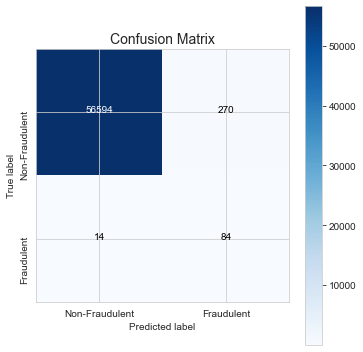

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.24      0.86      0.37        98

    accuracy                           1.00     56962
   macro avg       0.62      0.93      0.68     56962
weighted avg       1.00      1.00      1.00     56962

Optimal Threshold: 0.6842105263157895
ROC for test dataset 92.769%


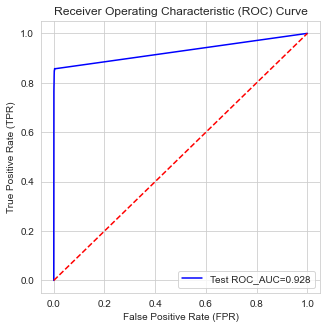


Time required to train the model: 20 minutes
****************************************************************************************************


In [ ]:
## KNN Model (SMOTE) - BALANCED DATASET
sm = over_sampling.SMOTE(random_state=0)                                  # Creating an instance of SMOTE()
X_train_smote_knn, y_train_smote_knn = sm.fit_resample(X_train_knn, y_train_knn)

## Building model and evaluation results
results_df, clf_knn_smote_bal_data = KNN_StratifiedKFoldCV_Model(sm, X_train_knn, y_train_knn, X_test_pt, y_test,
                                                                      "Power Transformer (SMOTE- Balanced Dataset)",
                                                                              "KNN with StratifiedKFoldCV", results_df)

**Results from Model Building on (SMOTE) Balanced Dataset**

In [ ]:
## Results from modeling on (SMOTE) balanced dataset
results_smote_bal_df= results_df.copy()
results_smote_bal_df

Data Handling Technique  \
0  Power Transformer (SMOTE - Balanced Dataset)   
1  Power Transformer (SMOTE - Balanced Dataset)   
2  Power Transformer (SMOTE - Balanced Dataset)   
3  Power Transformer (SMOTE - Balanced Dataset)   
4  Power Transformer (SMOTE - Balanced Dataset)   
5   Power Transformer (SMOTE- Balanced Dataset)   

                                        Model  ROC_AUC_cv  ROC_AUC_test  \
0  Logistic Regression with StratifiedKFoldCV    0.979859      0.976953   
1        Decision Tree with StratifiedKFoldCV    0.951215      0.947220   
2              XGBoost with StratifiedKFoldCV    0.976995      0.988408   
3        Random Forest with StratifiedKFoldCV    0.981661      0.985382   
4                  SVM with StratifiedKFoldCV    0.990155      0.964061   
5                  KNN with StratifiedKFoldCV    0.973855      0.927690   

   Threshold  Precision    Recall  F1 score  
0   0.755987   0.052988  0.877551  0.099942  
1   0.272897   0.032398  0.836735  0.062381  
2   0.000021   0.843750  0.826531  0.835052  
3   0.275303   0.415000  0.846939  0.557047  
4   0.711009   0.140962  0.867347  0.242511  
5   0.684211   0.237288  0.857143  0.371681

**<font color=purple>Better performing model on Balanced Dataset (SMOTE):**<br><br>
**Observations:**
1. `ROC_AUC` seems to be a `better evaluation metric` in case of `models trained on balanced classes as it is able to clearly distinguish between the classes`. <br>
2. Among all SMOTE models, **Random Forest with StratifiedKFoldCV [SMOTE - Balanced Dataset]** seems to give best overall results - `Test AUC (98.54%)` along with a `high recall score (84.694%)`. Some decrease in precision is noticed, but `the model accurately identifies more number of frauds as frauds`, hence some false positives can be dealt with (as per our use case).

In [ ]:
# Initialize the results_df to store new model results
results_df = pd.DataFrame(columns=['Data Handling Technique','Model', 'ROC_AUC_cv', 'ROC_AUC_test', 'Threshold', 'Precision','Recall','F1 score'])

### <font color=brown>**ADASYN**

#### <font color=DarkBlue> **4.A Logistic Regression Model - (Sampling Technique - ADASYN) - [Balanced Dataset]**

*(Note: num_C and cv_num are defined in the function LogisticRegression_StratifiedKFoldCV_Model()* - (defined earlier)

#### perfom cross validation on the X_train & y_train to create:
- X_train_cv
- X_test_cv
- y_train_cv
- y_test_cv

**Perform StratifiedKFold Cross Validation on X_train (i.e. X_train_pt_df) and y_train**

In [ ]:
## Checking patterns of StratifiedKFold cross-validation (and oversampling training folds using ADASYN)
cv_num= 3                 ## Number of cross-validation splits
skf = StratifiedKFold(n_splits=cv_num, random_state=0, shuffle=True)

for train_index, test_index in skf.split(X_train_pt_df,y_train):
    X_train_cv, X_test_cv = X_train_pt_df.iloc[train_index], X_train_pt_df.iloc[test_index]
    y_train_cv, y_test_cv = y_train.iloc[train_index],  y_train.iloc[test_index]
    print("TRAIN:", train_index, "TEST:", test_index)
    ada = over_sampling.ADASYN(random_state=0)
    X_train_cv, y_train_cv = ada.fit_resample(X_train_cv, y_train_cv)

TRAIN: [     0      1      3 ... 227841 227842 227844] TEST: [     2      4      6 ... 227829 227836 227843]
TRAIN: [     1      2      3 ... 227842 227843 227844] TEST: [     0      9     12 ... 227837 227838 227841]
TRAIN: [     0      2      4 ... 227838 227841 227843] TEST: [     1      3      5 ... 227840 227842 227844]


*We will be performing cross-validation `using RandomizedSearchCV and passing model via 'imblearn pipeline package'` as stated in the modeling approach (which performs `ADASYN and StratifiedKFold cross-validation in a similar fashion` as seen above).*

### <font color=purple>Print the class distribution after applying ADASYN

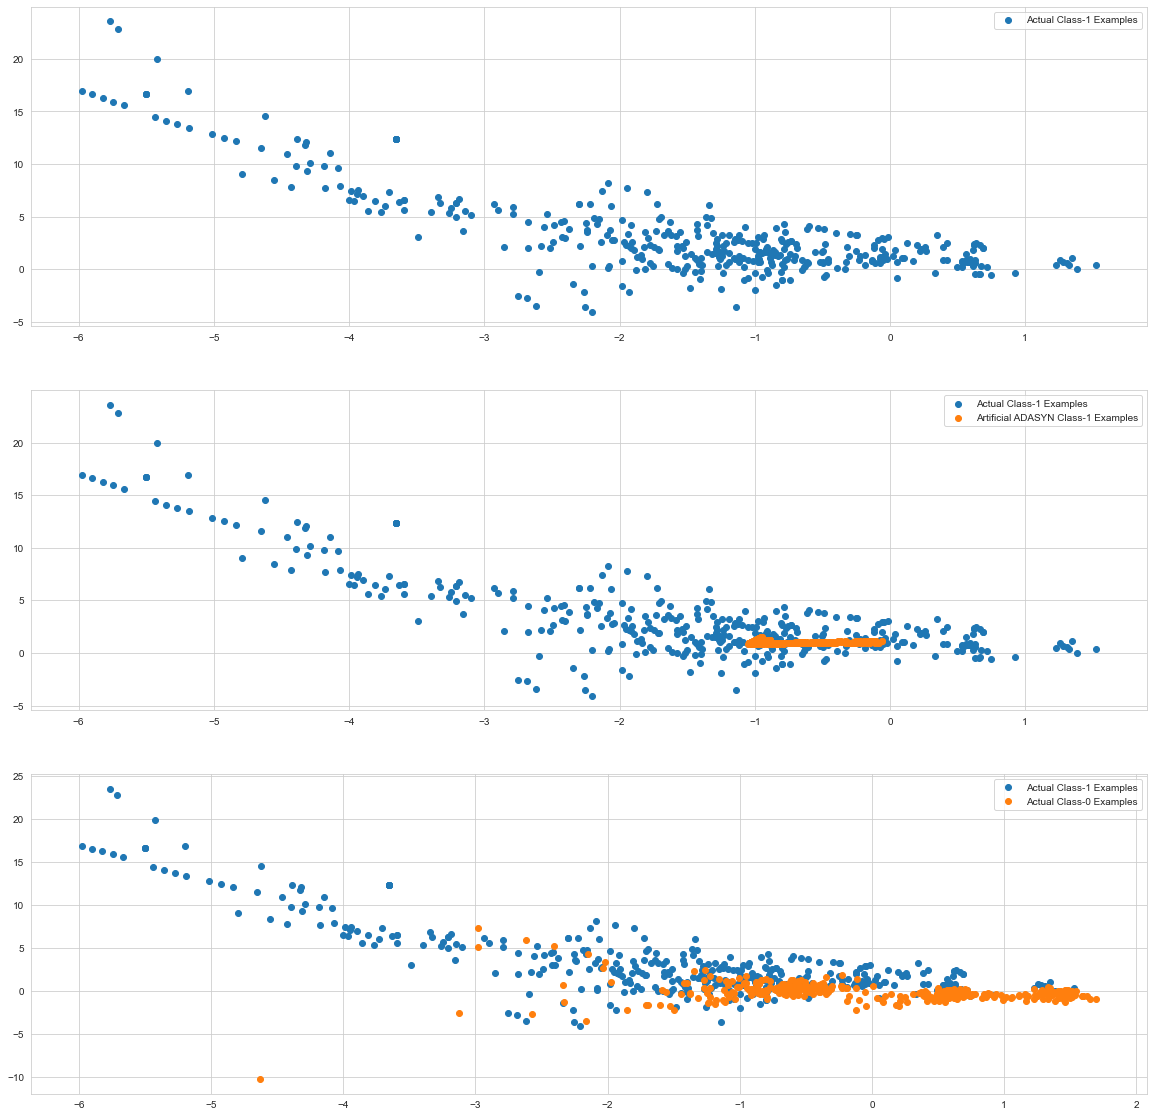

In [ ]:
##Defining a function to print the class distribution after applying ADASYN
import warnings
warnings.filterwarnings("ignore")

from imblearn import over_sampling

def class_distribution_after_adasyn(X_train, y_train):
    ada = over_sampling.ADASYN(random_state=0)
    X_train_adasyn, y_train_adasyn = ada.fit_resample(X_train, y_train)
    # Artificial minority samples and corresponding minority labels from ADASYN are appended
    # below X_train and y_train respectively
    # So to exclusively get the artificial minority samples from ADASYN, we do
    X_train_adasyn_1 = X_train_adasyn[X_train.shape[0]:]

    X_train_1 = X_train[np.where(y_train==1.0)]
    X_train_0 = X_train[np.where(y_train==0.0)]



    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.rcParams['figure.figsize'] = [20, 20]
    fig = plt.figure()

    plt.subplot(3, 1, 1)
    plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
    plt.scatter(X_train_adasyn_1[:X_train_1.shape[0], 0], X_train_adasyn_1[:X_train_1.shape[0], 1],
                label='Artificial ADASYN Class-1 Examples')
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.scatter(X_train_1[:, 0], X_train_1[:, 1], label='Actual Class-1 Examples')
    plt.scatter(X_train_0[:X_train_1.shape[0], 0], X_train_0[:X_train_1.shape[0], 1], label='Actual Class-0 Examples')
    plt.legend()

# Print the class distribution after applying ADASYN
class_distribution_after_adasyn(X_train_pt, y_train)

#### <font color=DarkBlue> **4.1 Logistic Regression Model - (Sampling Technique - ADASYN) - [Balanced Dataset]**

****************************************************************************************************
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Data Handling Technique: Power Transformer (ADASYN - Balanced Dataset)
Model Name: Logistic Regression with StratifiedKFoldCV


Evaluation results from cross-validation and optimal hyperparameters
Best Estimator:
 LogisticRegression(C=0.0001, max_iter=1000, n_jobs=-1, random_state=0,
                   solver='sag')
Best ROC_AUC (mean cross-validated score): 0.9779950355033115
Best (Optimal) Parameters: {'logisticregression__solver': 'sag', 'logisticregression__penalty': 'l2', 'logisticregression__C': 0.0001}

Optimal hyperparameters:
Best C value: 0.0001
Best penalty: l2
Best solver: sag

Prediction and Evaluation results: On Actual TEST SET

Test ROC_AUC: 0.9786976516830705
Test Accuracy: 0.9251255222780099

Confusion Matrix
 Model Stats Scores Summary : 


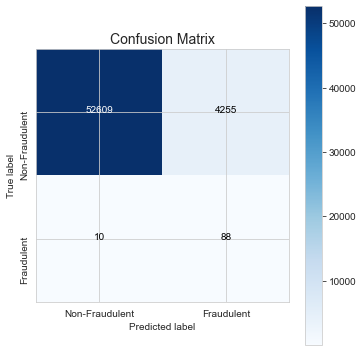

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     56864
           1       0.02      0.90      0.04        98

    accuracy                           0.93     56962
   macro avg       0.51      0.91      0.50     56962
weighted avg       1.00      0.93      0.96     56962

Optimal Threshold: 0.8652342650767199
ROC for test dataset 97.87%


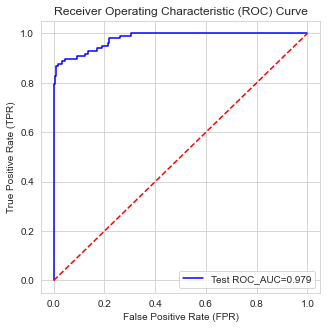


Time required to train the model: 2 minutes
****************************************************************************************************


In [ ]:
## LOGISTIC REGRESSION MODEL (ADASYN) - BALANCED DATASET
ada = over_sampling.ADASYN(random_state=0)          # Creating a class instance of ADASYN()
X_train_adasyn, y_train_adasyn = ada.fit_resample(X_train_pt, y_train)

# Building Model and Evaluating Results
results_df, clf_lr_adasyn_bal_data= LogisticRegression_StratifiedKFoldCV_Model(ada, X_train_pt, y_train, X_test_pt, y_test,
       "Power Transformer (ADASYN - Balanced Dataset)","Logistic Regression with StratifiedKFoldCV", results_df)

#### <font color=DarkBlue> **4.2 Decision Tree Model - (Sampling Technique - ADASYN) - [Balanced Dataset]**

****************************************************************************************************
Fitting 3 folds for each of 50 candidates, totalling 150 fits

Data Handling Technique: Power Transformer (ADASYN - Balanced Dataset)
Model Name: Decision Tree with StratifiedKFoldCV


Evaluation results from cross-validation and optimal hyperparameters
Best Estimator:
 DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_leaf=20,
                       min_samples_split=20, random_state=0)
Best ROC_AUC (mean cross-validated score): 0.9483455268018556
Best (Optimal) Parameters: {'decisiontreeclassifier__min_samples_split': 20, 'decisiontreeclassifier__min_samples_leaf': 20, 'decisiontreeclassifier__max_features': None, 'decisiontreeclassifier__max_depth': 4, 'decisiontreeclassifier__criterion': 'entropy'}

Optimal hyperparameters:
Best min_samples_split: 20
Best min_samples_leaf: 20
Best max_features: None
Best max_depth: 4
Best criterion: entropy

Prediction and Evaluat

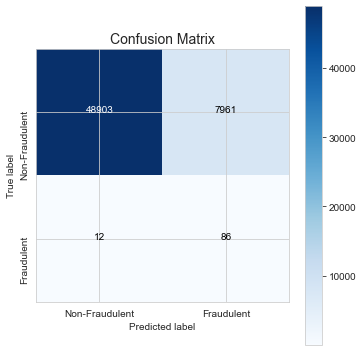

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.86      0.92     56864
           1       0.01      0.88      0.02        98

    accuracy                           0.86     56962
   macro avg       0.51      0.87      0.47     56962
weighted avg       1.00      0.86      0.92     56962

Optimal Threshold: 0.9723942088357153
ROC for test dataset 94.02%


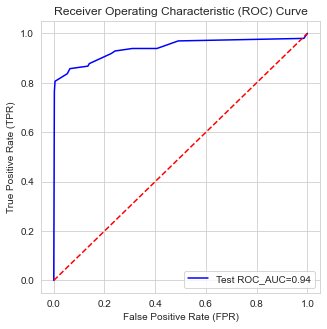


Time required to train the model: 5 minutes
****************************************************************************************************


In [ ]:
## Decision Tree Model (ADASYN) - BALANCED DATASET
# Building Model and Evaluating Results
results_df, clf_dt_adasyn_bal_data = DecisionTree_StratifiedKFoldCV_Model(ada, X_train_pt, y_train,
                                 X_test_pt, y_test, "Power Transformer (ADASYN - Balanced Dataset)",
                                                "Decision Tree with StratifiedKFoldCV", results_df)

#### <font color=DarkBlue> **4.3 XGBoost Model - (Sampling Technique - ADASYN) - [Balanced Dataset]**

****************************************************************************************************
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Data Handling Technique: Power Transformer (ADASYN - Balanced Dataset)
Model Name: XGBoost with StratifiedKFoldCV


Evaluation results from cross-validation and optimal hyperparameters
Best Estimator:
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=700, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0)
Best ROC_AUC (mean cross-validated score): 0.9793603077135608
B

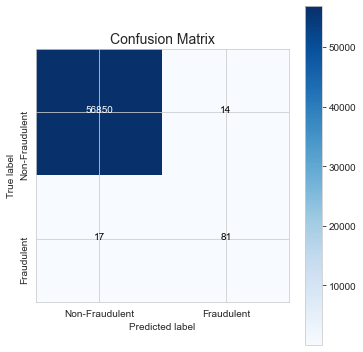

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.83      0.84        98

    accuracy                           1.00     56962
   macro avg       0.93      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962

Optimal Threshold: 5.4409404e-05
ROC for test dataset 98.593%


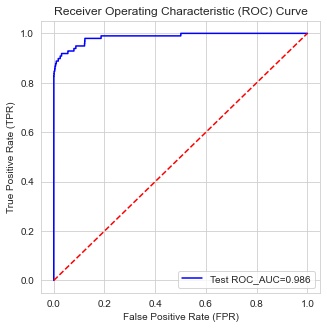


Time required to train the model: 112 minutes
****************************************************************************************************


In [ ]:
## XGBoost Model (ADASYN) - BALANCED DATASET
# Building Model and Evaluating Results
results_df, clf_xgb_adasyn_bal_data = XGBoost_StratifiedKFoldCV_Model(ada, X_train_pt_df, y_train, X_test_pt_df, y_test,
                    "Power Transformer (ADASYN - Balanced Dataset)", "XGBoost with StratifiedKFoldCV", results_df)

#### <font color=DarkBlue> **4.4 Random Forest Model - (Sampling Technique - ADASYN) - [Balanced Dataset]**

****************************************************************************************************
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Data Handling Technique: Power Transformer (ADASYN - Balanced Dataset)
Model Name: Random Forest with StratifiedKFoldCV


Evaluation results from cross-validation and optimal hyperparameters
Best Estimator:
 RandomForestClassifier(class_weight='balanced_subsample', max_depth=7,
                       max_features='log2', min_samples_leaf=4,
                       min_samples_split=5, n_estimators=300, n_jobs=-1,
                       random_state=0, warm_start=True)
Best ROC_AUC (mean cross-validated score): 0.9809670083590504
Best (Optimal) Parameters: {'randomforestclassifier__n_estimators': 300, 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__min_samples_leaf': 4, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__max_depth': 7, 'randomforestclassifier__criterion': 'gini'}

O

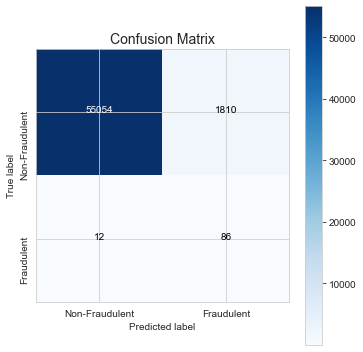

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56864
           1       0.05      0.88      0.09        98

    accuracy                           0.97     56962
   macro avg       0.52      0.92      0.53     56962
weighted avg       1.00      0.97      0.98     56962

Optimal Threshold: 0.33827086974704573
ROC for test dataset 98.429%


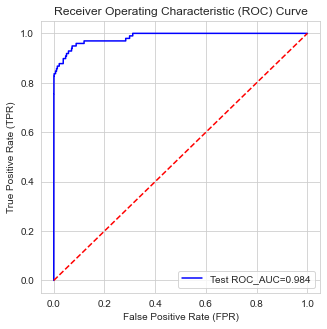


Time required to train the model: 364 minutes
****************************************************************************************************


In [ ]:
## Random Forest Model (ADASYN) - BALANCED DATASET
# Building Model and Evaluating Results
results_df, clf_rfc_adasyn_bal_data = RandomForest_StratifiedKFoldCV_Model(ada, "balanced_subsample",
                               X_train_pt, y_train, X_test_pt, y_test, "Power Transformer (ADASYN - Balanced Dataset)",
                                                     "Random Forest with StratifiedKFoldCV", results_df)

#### <font color=DarkBlue> **4.5 SVM Model - (Sampling Technique - ADASYN) - [Balanced Dataset]**

Using the stratified subset of training data defined earlier

**Perform StratifiedKFoldCV on X_train_svm and y_train_svm**

In [ ]:
## Checking patterns of StratifiedKFold cross-validation (and oversampling training folds using ADASYN)  - SVM
cv_num= 3              ## Number of cross-validation splits
skf = StratifiedKFold(n_splits=cv_num, random_state=0, shuffle=True)

for train_index, test_index in skf.split(X_train_svm,y_train_svm):
    X_train_svm_cv, X_test_svm_cv = X_train_svm.iloc[train_index], X_train_svm.iloc[test_index]
    y_train_svm_cv, y_test_svm_cv = y_train_svm.iloc[train_index],  y_train_svm.iloc[test_index]
    print("TRAIN:", train_index, "TEST:", test_index)
    ada = over_sampling.ADASYN(random_state=0)
    X_train_svm_cv, y_train_svm_cv = ada.fit_resample(X_train_svm_cv, y_train_svm_cv)

TRAIN: [    2     3     4 ... 56958 56959 56960] TEST: [    0     1    11 ... 56948 56949 56961]
TRAIN: [    0     1     3 ... 56959 56960 56961] TEST: [    2     4     5 ... 56954 56955 56956]
TRAIN: [    0     1     2 ... 56955 56956 56961] TEST: [    3     6     8 ... 56958 56959 56960]


*We will be performing cross-validation `using RandomizedSearchCV and passing model via 'imblearn pipeline package'` as stated in the modeling approach (which performs `ADASYN and StratifiedKFold cross-validation in a similar fashion` as seen above).*

****************************************************************************************************
Fitting 3 folds for each of 7 candidates, totalling 21 fits
[LibSVM]
Data Handling Technique: Power Transformer (ADASYN- Balanced Dataset)
Model Name: SVM with StratifiedKFoldCV


Evaluation results from cross-validation and optimal hyperparameters
Best Estimator:
 SVC(C=0.01, probability=True, random_state=0, verbose=True)
Best ROC_AUC (mean cross-validated score): 0.9878156336430374
Best (Optimal) Parameters: {'svc__C': 0.01}

Optimal hyperparameters:
Best C: 0.01

Prediction and Evaluation results: On Actual TEST SET

Test ROC_AUC: 0.9605569823596293
Test Accuracy: 0.9842526596678487

Confusion Matrix
 Model Stats Scores Summary : 


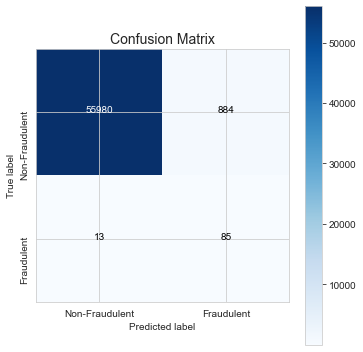

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.09      0.87      0.16        98

    accuracy                           0.98     56962
   macro avg       0.54      0.93      0.58     56962
weighted avg       1.00      0.98      0.99     56962

Optimal Threshold: 0.3084352676793928
ROC for test dataset 96.056%


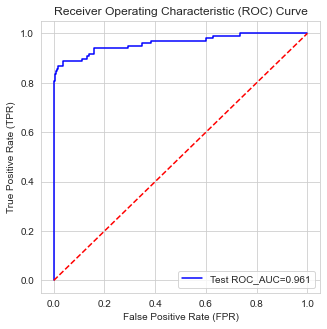


Time required to train the model: 138 minutes
****************************************************************************************************


In [ ]:
## SVM Model (ADASYN) - BALANCED DATASET
ada = over_sampling.ADASYN(random_state=0)                                # Creating a class instance of ADASYN()
X_train_adasyn_svm, y_train_adasyn_svm = ada.fit_resample(X_train_svm, y_train_svm)

# Building Model and Evaluating Results
results_df, clf_svm_adasyn_bal_data = SVM_StratifiedKFoldCV_Model(ada, X_train_svm, y_train_svm,
                                            X_test_pt, y_test, "Power Transformer (ADASYN- Balanced Dataset)",
                                                                        "SVM with StratifiedKFoldCV", results_df)

#### <font color=DarkBlue> **4.6 KNN Model - (Sampling Technique - ADASYN) - [Balanced Dataset]**

Using the stratified subset of training data defined earlier

**Perform StratifiedKFoldCV on X_train_knn and y_train_knn**

In [ ]:
## Checking patterns of StratifiedKFold cross-validation (and oversampling training folds using ADASYN) - KNN
cv_num= 3              ## Number of cross-validation splits
skf = StratifiedKFold(n_splits=cv_num, random_state=0, shuffle=True)

for train_index, test_index in skf.split(X_train_knn,y_train_knn):
    X_train_knn_cv, X_test_knn_cv = X_train_knn.iloc[train_index], X_train_knn.iloc[test_index]
    y_train_knn_cv, y_test_knn_cv = y_train_knn.iloc[train_index],  y_train_knn.iloc[test_index]
    print("TRAIN:", train_index, "TEST:", test_index)
    ada = over_sampling.ADASYN(random_state=0)
    X_train_knn_cv, y_train_knn_cv = ada.fit_resample(X_train_knn_cv, y_train_knn_cv)

TRAIN: [    0     1     2 ... 22781 22782 22783] TEST: [    6    11    20 ... 22764 22771 22784]
TRAIN: [    0     2     6 ... 22779 22781 22784] TEST: [    1     3     4 ... 22780 22782 22783]
TRAIN: [    1     3     4 ... 22782 22783 22784] TEST: [    0     2     7 ... 22777 22779 22781]


*We will be performing cross-validation `using RandomizedSearchCV and passing model via 'imblearn pipeline package'` as stated in the modeling approach (which performs `ADASYN and StratifiedKFold cross-validation in a similar fashion` as seen above).*

****************************************************************************************************
Fitting 3 folds for each of 16 candidates, totalling 48 fits

Data Handling Technique: Power Transformer (ADASYN- Balanced Dataset)
Model Name: KNN with StratifiedKFoldCV


Evaluation results from cross-validation and optimal hyperparameters
Best Estimator:
 KNeighborsClassifier(n_jobs=-1, n_neighbors=19)
Best ROC_AUC (mean cross-validated score): 0.9738517000453166
Best (Optimal) Parameters: {'kneighborsclassifier__n_neighbors': 19}

Optimal hyperparameters:
Best n_neighbors (K): 19

Prediction and Evaluation results: On Actual TEST SET

Test ROC_AUC: 0.9276799352267638
Test Accuracy: 0.9949615533162459

Confusion Matrix
 Model Stats Scores Summary : 


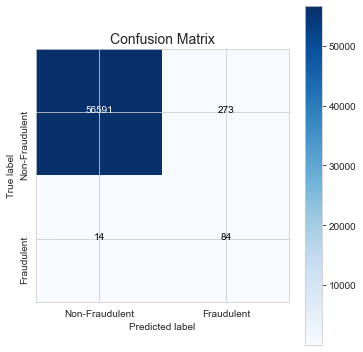

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.24      0.86      0.37        98

    accuracy                           0.99     56962
   macro avg       0.62      0.93      0.68     56962
weighted avg       1.00      0.99      1.00     56962

Optimal Threshold: 0.6842105263157895
ROC for test dataset 92.768%


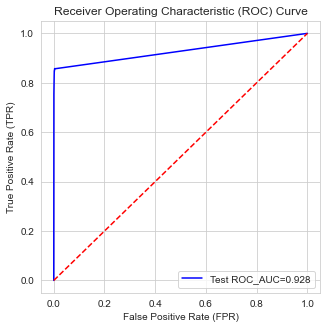


Time required to train the model: 20 minutes
****************************************************************************************************


In [ ]:
### KNN Model (ADASYN) - BALANCED DATASET
ada = over_sampling.ADASYN(random_state=0)                                # Creating a class instance of ADASYN()
X_train_adasyn_knn, y_train_adasyn_knn = ada.fit_resample(X_train_knn, y_train_knn)

## Building model and evaluation results
results_df, clf_knn_adasyn_bal_data = KNN_StratifiedKFoldCV_Model(ada, X_train_knn, y_train_knn, X_test_pt, y_test,
                                                                    "Power Transformer (ADASYN- Balanced Dataset)",
                                                                      "KNN with StratifiedKFoldCV", results_df)

**Results from Building Models on (ADASYN) Balanced Dataset**

In [ ]:
## Results from building models on (ADASYN) balanced dataset
results_adasyn_bal_df= results_df.copy()
results_adasyn_bal_df

Data Handling Technique  \
0  Power Transformer (ADASYN - Balanced Dataset)   
1  Power Transformer (ADASYN - Balanced Dataset)   
2  Power Transformer (ADASYN - Balanced Dataset)   
3  Power Transformer (ADASYN - Balanced Dataset)   
4   Power Transformer (ADASYN- Balanced Dataset)   
5   Power Transformer (ADASYN- Balanced Dataset)   

                                        Model  ROC_AUC_cv  ROC_AUC_test  \
0  Logistic Regression with StratifiedKFoldCV    0.977995      0.978698   
1        Decision Tree with StratifiedKFoldCV    0.948346      0.940200   
2              XGBoost with StratifiedKFoldCV    0.979360      0.985928   
3        Random Forest with StratifiedKFoldCV    0.980967      0.984289   
4                  SVM with StratifiedKFoldCV    0.987816      0.960557   
5                  KNN with StratifiedKFoldCV    0.973852      0.927680   

   Threshold  Precision    Recall  F1 score  
0   0.865234   0.020262  0.897959  0.039631  
1   0.972394   0.010687  0.877551  0.021117  
2   0.000054   0.852632  0.826531  0.839378  
3   0.338271   0.045359  0.877551  0.086259  
4   0.308435   0.087719  0.867347  0.159325  
5   0.684211   0.235294  0.857143  0.369231

**<font color=purple>Better performing model on Balanced Dataset (ADASYN):**<br><br>
**Observations:**
1. `ROC_AUC` seems to be a `better evaluation metric` in case of `models trained on balanced classes as it is able to clearly distinguish between the classes`. <br>
2. Among different competitive models, **Random Forest with StratifiedKFoldCV [ADASYN - Balanced Dataset]** seems to give best overall results - `Test AUC (98.43%)` along with a `high recall score (87.76%)`. A considerable decrease in precision is noticed but higher recall score meets our business objective and evaluation criteria as it identifies more number of fraud cases as frauds.

In [ ]:
# Initialize the results_df to store new model results
results_df = pd.DataFrame(columns=['Data Handling Technique','Model', 'ROC_AUC_cv', 'ROC_AUC_test', 'Threshold', 'Precision','Recall','F1 score'])

### <font color=green> Select the oversampling method which shows the best result on a model</font>
- Apply the best hyperparameter on the model
- Predict on the test dataset
<br>*(Note: already done above. Results can be seen below)*

In [ ]:
# Concatenating all the results to get the final results dataframe
df1= results_imbal_df.copy()                  # Results from imbalanced dataset models
df2= results_ros_bal_df.copy()                # Results from randomoversampling balanced dataset models
df3= results_smote_bal_df.copy()              # Results from SMOTE balanced dataset models
df4= results_adasyn_bal_df.copy()             # Results from ADASYN balanced dataset models
final_results_df= results_df.append([df1,df2,df3,df4], ignore_index=True)     # All results
final_results_df

Data Handling Technique  \
0                     Power Transformer (Imbalanced Dataset)   
1                     Power Transformer (Imbalanced Dataset)   
2                     Power Transformer (Imbalanced Dataset)   
3                     Power Transformer (Imbalanced Dataset)   
4                     Power Transformer (Imbalanced Dataset)   
5                     Power Transformer (Imbalanced Dataset)   
6   Power Transformer (RandomOverSampler - Balanced Dataset)   
7    Power Transformer (RandomOverSampler- Balanced Dataset)   
8    Power Transformer (RandomOverSampler- Balanced Dataset)   
9    Power Transformer (RandomOverSampler- Balanced Dataset)   
10   Power Transformer (RandomOverSampler- Balanced Dataset)   
11   Power Transformer (RandomOverSampler- Balanced Dataset)   
12              Power Transformer (SMOTE - Balanced Dataset)   
13              Power Transformer (SMOTE - Balanced Dataset)   
14              Power Transformer (SMOTE - Balanced Dataset)   
15              Power Transformer (SMOTE - Balanced Dataset)   
16              Power Transformer (SMOTE - Balanced Dataset)   
17               Power Transformer (SMOTE- Balanced Dataset)   
18             Power Transformer (ADASYN - Balanced Dataset)   
19             Power Transformer (ADASYN - Balanced Dataset)   
20             Power Transformer (ADASYN - Balanced Dataset)   
21             Power Transformer (ADASYN - Balanced Dataset)   
22              Power Transformer (ADASYN- Balanced Dataset)   
23              Power Transformer (ADASYN- Balanced Dataset)   

                                         Model  ROC_AUC_cv  ROC_AUC_test  \
0   Logistic Regression with StratifiedKFoldCV    0.979647      0.975363   
1         Decision Tree with StratifiedKFoldCV    0.969650      0.952778   
2               XGBoost with StratifiedKFoldCV    0.979287      0.978473   
3         Random Forest with StratifiedKFoldCV    0.980539      0.981732   
4                   SVM with StratifiedKFoldCV    0.964697      0.965862   
5                   KNN with StratifiedKFoldCV    0.948238      0.927915   
6   Logistic Regression with StratifiedKFoldCV    0.980306      0.976352   
7         Decision Tree with StratifiedKFoldCV    0.952870      0.938331   
8               XGBoost with StratifiedKFoldCV    0.978555      0.977530   
9         Random Forest with StratifiedKFoldCV    0.980638      0.982096   
10                  SVM with StratifiedKFoldCV    0.990588      0.966430   
11                  KNN with StratifiedKFoldCV    0.948424      0.927971   
12  Logistic Regression with StratifiedKFoldCV    0.979859      0.976953   
13        Decision Tree with StratifiedKFoldCV    0.951215      0.947220   
14              XGBoost with StratifiedKFoldCV    0.976995      0.988408   
15        Random Forest with StratifiedKFoldCV    0.981661      0.985382   
16                  SVM with StratifiedKFoldCV    0.990155      0.964061   
17                  KNN with StratifiedKFoldCV    0.973855      0.927690   
18  Logistic Regression with StratifiedKFoldCV    0.977995      0.978698   
19        Decision Tree with StratifiedKFoldCV    0.948346      0.940200   
20              XGBoost with StratifiedKFoldCV    0.979360      0.985928   
21        Random Forest with StratifiedKFoldCV    0.980967      0.984289   
22                  SVM with StratifiedKFoldCV    0.987816      0.960557   
23                  KNN with StratifiedKFoldCV    0.973852      0.927680   

    Threshold  Precision    Recall  F1 score  
0    0.004027   0.880597  0.602041  0.715152  
1    0.022727   0.884615  0.704082  0.784091  
2    0.000299   0.949367  0.765306  0.847458  
3    0.002577   0.958904  0.714286  0.818713  
4    0.006253   0.930556  0.683673  0.788235  
5    0.037037   0.844828  0.500000  0.628205  
6    0.666692   0.056916  0.877551  0.106899  
7    0.367210   0.023715  0.857143  0.046154  
8    0.003710   0.816327  0.816327  0.816327  
9    0.154140   0.512346  0.846939  0.638462  
10   0.798687   0.

**Inference:**<br><br>
(i) In case of `balanced classes (oversampling methods)`, `ROC_AUC acts as a good metric to evaluate the performance of the classifier` because it can clearly distinguish between the classes.<br>
(ii) In addition to this, `we would also conclude our decision on the basis of our model evaluation criteria - to identify fraudulent transactions as fraudulent than the non-fradulent ones (high recall score).`<br><br>
**<font color=purple>Best Model (Oversampling Methods)</font><br><br>**
Amongst different competitive models, **Random Forest with StratifiedKFoldCV - (SMOTE) [Balanced Dataset]** gives the best overall results with `Test ROC_AUC (98.538%)` and a `high recall score of approximately (84.694%).`

In [ ]:
# For Best Model in Oversampling methods

# Loading the best oversampled model in clf   (Best Model: Random Forest with StratifiedKFoldCV - SMOTE)
clf = clf_rfc_smote_bal_data     #initialise the model with optimum hyperparameters
clf.fit(X_train_sm, y_train_sm)  # fit on the balanced dataset (SMOTE)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=7,
                       max_features='log2', min_samples_leaf=4,
                       min_samples_split=5, n_estimators=300, n_jobs=-1,
                       random_state=0, warm_start=True)

### <font color=purple>Print the important features of the best model to understand the dataset

Top var = 14
2nd Top var = 10
3rd Top var = 12


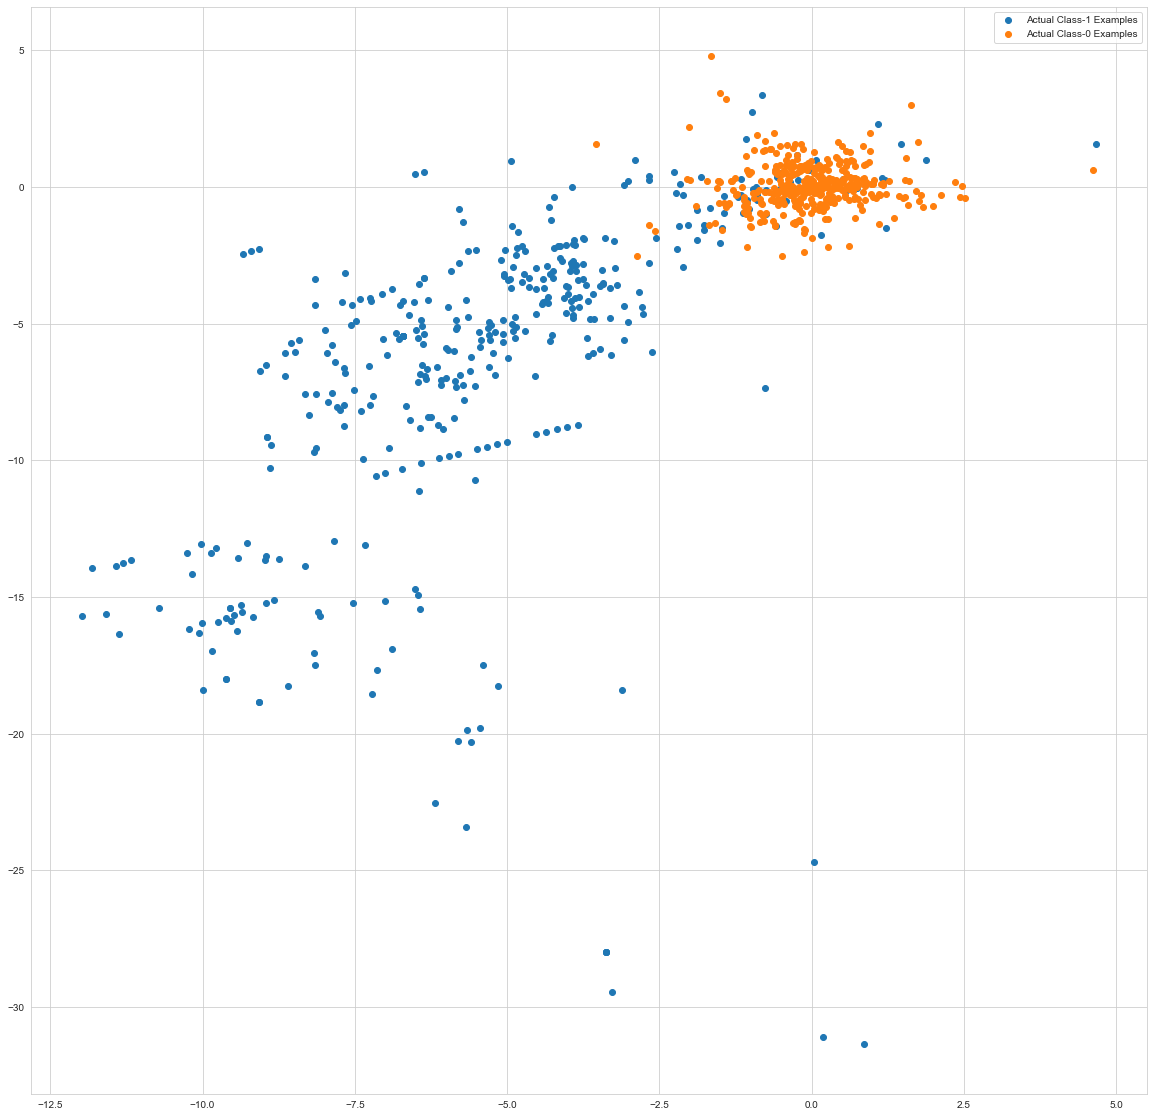

In [ ]:
# Function to print the important features from the best model (obtained from oversampling method)
def imp_features_best_model_oversampling_method(clf, X_train, y_train):
    var_imp = []
    for i in clf.feature_importances_:
        var_imp.append(i)
    print('Top var =', var_imp.index(np.sort(clf.feature_importances_)[-1])+1)
    print('2nd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-2])+1)
    print('3rd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-3])+1)

    # Variable on Index-13 and Index-9 seems to be the top 2 variables
    top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-1])
    second_top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-2])

    X_train_1 = X_train[np.where(y_train==1.0)]
    X_train_0 = X_train[np.where(y_train==0.0)]

    np.random.shuffle(X_train_0)

    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.rcParams['figure.figsize'] = [20, 20]

    plt.scatter(X_train_1[:, top_var_index], X_train_1[:, second_top_var_index], label='Actual Class-1 Examples')
    plt.scatter(X_train_0[:X_train_1.shape[0], top_var_index], X_train_0[:X_train_1.shape[0], second_top_var_index],
              label='Actual Class-0 Examples')
    plt.legend()
    plt.show()

# Printing the important features from the best model (obtained from oversampling method)
imp_features_best_model_oversampling_method(clf_rfc_smote_bal_data, X_train_pt, y_train)

**Inference:** We have successfully verified the `top 2 features` of the best model (in oversampled methods), namely variables `14` and `10` having `indices 13 and 9` respectively.

In [ ]:
# Printing results (Best Model: Oversampling method) Here, clf: Best Model (Random Forest with SMOTE model)
print('Train auc (mean cross-validation score) = ', final_results_df['ROC_AUC_cv'][15])
print('Train auc (best estimator) =', metrics.roc_auc_score(y_true= y_train_sm, y_score=  clf.predict_proba(X_train_sm)[:,1]));print()

# Evaluation results on Test set
print("Test auc =", metrics.roc_auc_score(y_true= y_test, y_score= clf.predict_proba(X_test_pt)[:,1]))
fpr, tpr, thresholds = metrics.roc_curve(y_true= y_test, y_score= clf.predict_proba(X_test_pt)[:,1])
threshold = thresholds[np.argmax(tpr-fpr)]
#Print threshold
print("Threshold =",threshold)

Train auc (mean cross-validation score) =  0.9816612314949009
Train auc (best estimator) = 0.9974699533425319

Test auc = 0.9853815189553593
Threshold = 0.27530287932436026
